<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/PROJETO__ESTRESSE_FIGS_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # BIBLIOTECAS

In [ ]:
from IPython.display import clear_output

In [ ]:
! pip install open-ephys-python-tools

clear_output()

In [ ]:
! pip install pactools
clear_output()

In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn

from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy.stats import wilcoxon

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pactools
from pactools import Comodulogram, REFERENCES

import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

> # FUNÇÕES



In [ ]:
def preview(path):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  data_filt = signal.filtfilt(b, a, data)

  return (pd.DataFrame(data_filt))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def preview_plot(data):

  for i in range(0,32):
    plt.figure()
    plt.plot(data[i])
    plt.title('ch' + str (i+1))

In [ ]:
# CARREGAR O DADO E EXTRAIR MOMENTOS DE IMOBILIDADE

def load_data(path,inicio,final,ch_prl,ch_ca1d,ch_ca1v,ch_bla):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_bla)-1)]
  data_ca1d = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_ca1d)-1)]
  data_ca1v = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_ca1v)-1)]


  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  CA1D = signal.filtfilt(b, a, data_ca1d)
  CA1V = signal.filtfilt(b, a, data_ca1v)


  return(pd.DataFrame({'data_PRL': PRL,'data_BLA': BLA, 'data_dhpc': CA1D, 'data_vhpc': CA1V}))

In [ ]:
def media_coherence(df, condicao, r1, r2, grupo):
    filtro = (df['condicao'] == condicao) & (df['r1'] == r1) & (df['r2'] == r2) & (df['grupo'] == grupo)
    media_coherence = df[filtro].groupby('animal')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao,'grupo': grupo})
    return result_df

In [ ]:
# Função para mapear o valor da frequencia da coerencia para o nome da banda
def mapear_banda(valor):
    if 0 <= valor <= 4:
        return 'Delta'
    elif 5 <= valor <= 10:
        return 'Theta'
    elif 11 <= valor <= 29:
        return 'Alpha/beta'
    elif 30 <= valor <= 50:
        return 'Low gamma'
    elif 51 <= valor <= 90:
        return 'Mid gamma'
    else:
        return 'High gamma'

In [ ]:
def load_acelerometer(path):
    load = Session(path).recordnodes[0].recordings[0]
    t_raw = load.continuous[0].timestamps
    t = t_raw - t_raw[0]

    x = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 32]
    y = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 33]
    z = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 34]

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    acel = np.abs(np.sqrt(x**2 + y**2 + z**2))

    df_acel = pd.DataFrame({'acel': acel})
    df_acel['animal'] = str(rato)
    df_acel['condicao'] = str(condicao)

    return df_acel

In [ ]:
def group_consecutive_numbers(num_list):
    groups = []  # Lista para armazenar os grupos de números consecutivos
    current_group = [num_list[0]]  # Inicializando o primeiro grupo com o primeiro número

    # Iterando sobre a lista de números a partir do segundo elemento
    for num in num_list[1:]:
        if num == current_group[-1] + 1:  # Verificando se o número é consecutivo
            current_group.append(num)  # Se for, adiciona ao grupo atual
        else:
            groups.append(current_group)  # Se não, salva o grupo atual
            current_group = [num]  # Começa um novo grupo

    # Adicionando o último grupo se ele não estiver vazio
    if current_group:
        groups.append(current_group)

    return groups

In [ ]:

# Identificar os grupos de índices consecutivos não-NaN e seus comprimentos para cortar momentos de imobilidade menores que 2s
def find_consecutive_groups(arr):
    # Encontrar as mudanças de NaN para não-NaN e vice-versa
    diff = np.diff(np.isnan(arr).view(np.int8))
    idx, = diff.nonzero()

    # Adicionar o índice do primeiro e último elemento
    idx = np.r_[0, idx + 1, len(arr)]
    idx_pairs = zip(idx[:-1], idx[1:])  # Formar pares de índices

    return [(start, end) for start, end in idx_pairs if not np.isnan(arr[start])]

In [ ]:
def concatenar_listas(lista_de_listas):
    """Concatena uma lista de listas em uma única lista.

    Returns:
   Uma única lista com todos os elementos das sub-listas.
    """
    return [item for sublist in lista_de_listas for item in sublist]

In [ ]:
def load_data_full(path,ch_prl,ch_bla,ch_dhpc, ch_vhpc):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_bla)-1)]
  data_dhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_dhpc)-1)]
  data_vhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_vhpc)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  dHPC = signal.filtfilt(b, a, data_dhpc)
  vHPC = signal.filtfilt(b, a, data_vhpc)

  return(pd.DataFrame({'data_PRL': PRL,'data_BLA': BLA, 'data_DHPC': dHPC, 'data_VHPC': vHPC}))

In [ ]:
def data_slicing_imovel( rato, condicao ): #cria lista que contém os momentos de imobilidade

  path = ratos[str(rato)]['condicao'][str(condicao)]

  ch_prl =  ratos[rato]['canais']['prl']
  ch_bla =  ratos[rato]['canais']['bla']
  ch_dhpc =  ratos[rato]['canais']['dhpc']
  ch_vhpc =  ratos[rato]['canais']['vhpc']

  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_bla)-1)]
  data_dhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_dhpc)-1)]
  data_vhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_vhpc)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  dHPC = signal.filtfilt(b, a, data_dhpc)
  vHPC = signal.filtfilt(b, a, data_vhpc)

  # Recuperando dado da acelerometria para definir momentos de atividade
  data_acel = df_acel[(df_acel['animal'] == str(rato)) & (df_acel['condicao'] == str(condicao))]['acel']

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )

  index_parado_all = []
  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)

  group_index_parado = group_consecutive_numbers(index_parado_all) #essa função irá agrupar números que são consecutivos em listas separadas

  index_parado = []

  for i in range(len(group_index_parado)): #esse for está selecionando apenas as listas que tem mais de 2s de dado
    if len(group_index_parado[i]) > 2000:
      index_parado.append(group_index_parado[i])

  PRL_cut = [] # ESSA LISTA VAI CONTER OS MOMENTOS DE IMOBILIDADE DO RATO CORRESPONDENTE (ela que será concatenada)

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      PRL_cut.append(PRL[inicio:final])

  BLA_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      BLA_cut.append(BLA[inicio:final])

  dHPC_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      dHPC_cut.append(dHPC[inicio:final])

  vHPC_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      vHPC_cut.append(vHPC[inicio:final])

  return PRL_cut, BLA_cut, dHPC_cut, vHPC_cut

In [ ]:
# def data_slicing_ativo( rato, condicao ): #cria lista que contém os momentos de atividade

#   path = ratos[str(rato)]['condicao'][str(condicao)]

#   ch_prl =  ratos[rato]['canais']['prl']
#   ch_cg =  ratos[rato]['canais']['cg']
#   ch_il =  ratos[rato]['canais']['il']

#   load = Session(path).recordnodes[0].recordings[0]
#   t_raw= load.continuous[0].timestamps
#   t = t_raw-t_raw[0]

#   data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
#   data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_cg)-1)]
#   data_il = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_il)-1)]

#   srate = 1000
#   fc_low = 59
#   fc_high = 61
#   order = 5
#   b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

#   PRL = signal.filtfilt(b, a, data_prl)
#   ACC = signal.filtfilt(b, a, data_cg)
#   IL = signal.filtfilt(b, a, data_il)

#   # Recuperando dado da acelerometria para definir momentos de atividade
#   data_acel = df_acel[(df_acel['animal'] == str(rato)) & (df_acel['condicao'] == str(condicao))]['acel']

#   acel = np.array(data_acel)
#   acel = np.diff(acel, axis = 0)
#   acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

#   # array booleano dizendo onde animal mexeu e não mexeu
#   ativo_bool = np.array(acel >= 0.005 )

#   index_ativo_all = []
#   for x in range(len(ativo_bool)):
#       if ativo_bool[x] == True:
#         index_ativo_all.append(x)

#   group_index_ativo = group_consecutive_numbers(index_ativo_all) #essa função irá agrupar números que são consecutivos em listas separadas

#   index_ativo = []

#   for i in range(len(group_index_ativo)): #esse for está selecionando apenas as listas que tem mais de 2s de dado
#     if len(group_index_ativo[i]) > 2000:
#       index_ativo.append(group_index_ativo[i])

#   PRL_cut = [] # ESSA LISTA VAI CONTER OS MOMENTOS DE IMOBILIDADE DO RATO CORRESPONDENTE (ela que será concatenada)

#   for i in range(len(index_ativo)):
#       inicio = index_ativo[i][0]
#       final = index_ativo[i][-1]

#       PRL_cut.append(PRL[inicio:final])

#   ACC_cut = []

#   for i in range(len(index_ativo)):
#       inicio = index_ativo[i][0]
#       final = index_ativo[i][-1]

#       ACC_cut.append(ACC[inicio:final])

#   IL_cut = []

#   for i in range(len(index_ativo)):
#       inicio = index_ativo[i][0]
#       final = index_ativo[i][-1]

#       IL_cut.append(IL[inicio:final])

#   return PRL_cut, ACC_cut, IL_cut

In [ ]:
def get_psd( data_psd  ):

  f, p = welch(data_psd, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
  df_psd = pd.DataFrame({'PSD': p, 'F': f})

  return(df_psd )

In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:
def bandpass(data, cutfreq, filtorder, sampling_rate):

        fny = sampling_rate/2

        b, a = signal.butter(N = filtorder, Wn=np.array(cutfreq) / fny,
                                         btype='bandpass')
        dataout = signal.filtfilt(b, a, data)

        return dataout

In [ ]:
# FILTRO SIMPLES

def eegfilt(data,srate,flow,fhigh):

    # fir LS
    trans = 0.15
    nyq = srate*0.5
    f=[0, (1-trans)*flow/nyq, flow/nyq, fhigh/nyq, (1+trans)*fhigh/nyq, 1]
    m=[0,0,1,1,0,0]
    filt_order = 3*np.fix(srate/flow)
    if filt_order % 2 == 0:
        filt_order = filt_order + 1

    filtwts = signal.firls(filt_order,f,np.double(m))
    data_filt = signal.filtfilt(filtwts,1, data)

    return(data_filt)


In [ ]:
#ExTRAINDO O MODULATION INDEX

def modulation_index(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)

    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    entrop = -1*(np.sum(p*np.log(p)))
    mi = (np.log(numbin)-entrop)/np.log(numbin)

    return(mi)

In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO

def pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# ACOP FASE AMPL ENTRE DUAS REGIÕES

def pac_entre_regioes(lfp_alta,lfp_lenta,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_alta,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))


    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp_lenta,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))


    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))


    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# Causalidade de granger

def grangercausality(data1,data2,r1, r2, condicao, rato,frate,flow,fhigh):

  envelope_data_1 = np.abs(signal.hilbert(eegfilt(data1,frate,flow,fhigh)))
  test_data_1 = np.squeeze(envelope_data_1)

  envelope_data_2 = np.abs(signal.hilbert(eegfilt(data2,frate,flow,fhigh)))
  test_data_2 = np.squeeze(envelope_data_2)

  matrix_test = np.vstack([np.diff(test_data_1),np.diff(test_data_2)]).T
  lag = [int(math.sqrt(len(matrix_test)))]
  gc = grangercausalitytests(matrix_test,lag,verbose = False)
  results_test_r = [gc[lag[0]][0]['ssr_ftest'][1],gc[lag[0]][0]['ssr_ftest'][0]]

  p_label = []
  p = results_test_r[0]
  if p <= 0.01:
    p_label.append('p<0.01')
  elif 0.01 < p < 0.05:
    p_label.append('p<0.05')
  elif p == 0.05:
    p_label.append('p=0.05')
  else:
    p_label.append('p>0.05')

  df_granger = pd.DataFrame({ 'Granger Causality':  results_test_r[1], 'P value': p_label, 'r1': r1, 'r2': r2, 'condicao': condicao}, index=['Results'])

  return(df_granger )

In [ ]:

def phase_amp_hist(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)


    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    return(p)


def pac_histogram(lfp_amp,lfp_fase,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_amp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])

    Pf1 = 4
    Pf2 = 12
    PhaseFreq=eegfilt(lfp_fase,srate,Pf1,Pf2)
    analytic_signal = signal.hilbert(PhaseFreq)
    faselenta = np.angle(analytic_signal)[mask]

    hist_freqs = []

    for count_rapida,rapida in enumerate(AmpFreqTransformed1):

        hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


    return(hist_freqs)

> # ANÁLISE DOS DADOS

In [ ]:
# ATENÇÃO: aqui os canais iniciam em 1 e não em 0 (i+1), ou seja, ch1 == ch0, ch32 == ch31....


#'CCM64': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_24_08_2023/GRUPO_ESCAPAVEL/CCM64_OF_PRE_EXP',
                      #              'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_24_08_2023/GRUPO_ESCAPAVEL/CCM64_OF_POS_EXP'},
                      # 'grupo': { 'ESCAPAVEL'},

                      # 'canais': {'prl': 22,
                      #             'cg': 31,
                      #             'il': 25 ,
                      #             'ca1-d': 1 ,
                      #             'ca1-v': 14 ,
                      #             'bla': 19 },

                      # 'inicio': { 'OF_pre': 1000 ,
                      #             'OF_pos': 345000} },  # ESTE ANIMAL ESTÁ SÓ COM 4S DE REGISTRO DE OF POS EXP!!!!!!



          # 'CCM04': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO INESCAPAVEL/CCM04_OF_PRE_EXP',
          #                          'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO INESCAPAVEL/CCM04_OF_POS_EXP'},
          #             'grupo': 'INESCAPAVEL',

          #             'canais': {'prl': 22 ,
          #                         'cg': 29 ,
          #                         'il': 27 ,
          #                         'ca1-d':11 ,
          #                         'ca1-v': 13 ,
          #                         'bla': 19 },

          #             'inicio': { 'OF_pre': 90000  ,
          #                         'OF_pos': 1000 } },   # OF PRE ESTÁ SÓ COM 20000 PONTOS!!!!!!!

ratos = { 'CCM68': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO ESCAPAVEL/CCM68_OF_PRE_EXP',
                                         'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO ESCAPAVEL/CCM68_OF_POS_EXP'},

                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl':31 ,
                                  'cg':23 ,
                                  'il': 27 ,
                                  'dhpc': 1 ,
                                  'vhpc': 12 ,
                                  'bla':20  },

                      'inicio': { 'OF_pre': 270000 ,
                                  'OF_pos': 80000} }, # VERIFICADO OF PRE E POS OK

          'CCM65': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_31_08_2023/GRUPO ESCAPAVEL/CCM65_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_31_08_2023/GRUPO ESCAPAVEL/CCM65_OF_POS_EXP'},
                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl': 26 ,
                                  'cg': 32 ,
                                  'il': 24 ,
                                  'dhpc': 7 ,
                                  'vhpc': 16,
                                  'bla': 17 },

                      'inicio': { 'OF_pre': 1000  ,
                                  'OF_pos': 360000 } },  # VERIFICADO OF PRE E POS OK

          'CCM191': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_13_10_2023/GRUPO_ESCAPAVEL/CCM191_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_13_10_2023/GRUPO_ESCAPAVEL/CCM191_OF_POS_EXP'},
                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl': 23,
                                  'cg': 31,
                                  'il': 28 ,
                                  'dhpc': 7 ,
                                  'vhpc': 11 ,
                                  'bla': 13  },

                      'inicio': { 'OF_pre': 20000 ,
                                  'OF_pos': 75000} },  # VERIFICADO OF PRE E POS OK

          'CCM05': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_08_2023/GRUPO INESCAPAVEL/CCM05_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_08_2023/GRUPO INESCAPAVEL/CCM05_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl': 24 ,
                                  'cg': 30,
                                  'il': 28 ,
                                  'dhpc': 6  ,
                                  'vhpc': 12 ,
                                  'bla': 17 },

                      'inicio': { 'OF_pre': 205000 ,
                                  'OF_pos': 265000 } },  # VERIFICADO OF PRE E POS OK

          'CCM192': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl':22 ,
                                  'cg':31 ,
                                  'il': 27 ,
                                  'dhpc':5  ,
                                  'vhpc':12  ,
                                  'bla': 20 },

                      'inicio': { 'OF_pre': 140000 ,
                                  'OF_pos': 170000 } },   # VERIFICADO OF PRE E POS OK



          'CCM193': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_10_2023/GRUPO INESCAPAVEL/CCM193_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_10_2023/GRUPO INESCAPAVEL/CCM193_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl': 23,
                                  'cg': 29,
                                  'il': 25 ,
                                  'dhpc':6  ,
                                  'vhpc': 11 ,
                                  'bla': 19 },

                      'inicio': { 'OF_pre': 1000 ,
                                  'OF_pos': 268000} }}   # VERIFICADO OF PRE E POS OK



In [ ]:
x = preview( '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_PRE_EXP')
# preview_plot(x)

/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_PRE_EXP/Record Node 101/experiment1/recording1/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))


# THETA BASED ON ACELEROMETER

In [ ]:
# calcular o espectro para cada pedacinho separadamente e depois tirar a média de todos os pedacinhos
# colocar o nperseg 2000 (mesmo tamanho do menor fragmento)


# a unidade do plot será: Power Ratio (a.u.)

In [ ]:
# CRIANDO DF COM OS DADOS COMPLETOS

dataframes_full = []
for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():

      path = ratos[str(rato)]['condicao'][str(condicao)]

      grupo = ratos[rato]['grupo']
      ch_prl =  ratos[rato]['canais']['prl']
      ch_bla = ratos[rato]['canais']['bla']
      ch_dhpc = ratos[rato]['canais']['dhpc']
      ch_vhpc = ratos[rato]['canais']['vhpc']

      df_temp_full = load_data_full(path,ch_prl,ch_bla,ch_dhpc, ch_vhpc)
      df_temp_full['animal'] = str(rato)
      df_temp_full['condicao'] = str(condicao)
      df_temp_full['grupo'] = str(grupo)

      dataframes_full.append(df_temp_full)

df_full = pd.concat(dataframes_full)
clear_output()

In [ ]:
# OBTENDO DADOS DO ACELEROMETRO

data_acel = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
        path = ratos[str(rato)]['condicao'][str(condicao)]
        grupo = ratos[rato]['grupo']
        df_temp_acel = load_acelerometer(str(path))
        df_temp_acel['grupo'] = str(grupo)
        data_acel.append(df_temp_acel)

df_acel = pd.concat(data_acel)
clear_output()


In [ ]:
# CORTANDO MOMENTOS DE IMOBILIDADE A PARTIR DO ACELEROMETRO

# ESCAP
PRL_CCM68_PRE_P, BLA_CCM68_PRE_P , dHPC_CCM68_PRE_P, vHPC_CCM68_PRE_P = data_slicing_imovel( 'CCM68', 'OF_pre' ) #ESSA FUNÇÃO PRODUZ LISTAS QUE CONTÉM LISTAS COM MOMENTOS DE IMOBILIDADE POR MAIS DE 2S
PRL_CCM68_POS_P, BLA_CCM68_POS_P , dHPC_CCM68_POS_P, vHPC_CCM68_POS_P = data_slicing_imovel( 'CCM68', 'OF_pos' )

PRL_CCM65_PRE_P, BLA_CCM65_PRE_P , dHPC_CCM65_PRE_P, vHPC_CCM65_PRE_P = data_slicing_imovel( 'CCM65', 'OF_pre' )
PRL_CCM65_POS_P, BLA_CCM65_POS_P , dHPC_CCM65_POS_P, vHPC_CCM65_POS_P = data_slicing_imovel( 'CCM65', 'OF_pos' )

PRL_CCM191_PRE_P, BLA_CCM191_PRE_P , dHPC_CCM191_PRE_P, vHPC_CCM191_PRE_P = data_slicing_imovel( 'CCM191', 'OF_pre' )
PRL_CCM191_POS_P, BLA_CCM191_POS_P , dHPC_CCM191_POS_P, vHPC_CCM191_POS_P = data_slicing_imovel( 'CCM191', 'OF_pos' )


# INESCAP
PRL_CCM05_PRE_P, BLA_CCM05_PRE_P , dHPC_CCM05_PRE_P, vHPC_CCM05_PRE_P = data_slicing_imovel( 'CCM05', 'OF_pre' )
PRL_CCM05_POS_P, BLA_CCM05_POS_P , dHPC_CCM05_POS_P, vHPC_CCM05_POS_P = data_slicing_imovel( 'CCM05', 'OF_pos' )

PRL_CCM192_PRE_P, BLA_CCM192_PRE_P , dHPC_CCM192_PRE_P, vHPC_CCM192_PRE_P = data_slicing_imovel( 'CCM192', 'OF_pre' )
PRL_CCM192_POS_P, BLA_CCM192_POS_P , dHPC_CCM192_POS_P, vHPC_CCM192_POS_P = data_slicing_imovel( 'CCM192', 'OF_pos' )

PRL_CCM193_PRE_P, BLA_CCM193_PRE_P , dHPC_CCM193_PRE_P, vHPC_CCM193_PRE_P = data_slicing_imovel( 'CCM193', 'OF_pre' )
PRL_CCM193_POS_P, BLA_CCM193_POS_P , dHPC_CCM193_POS_P, vHPC_CCM193_POS_P = data_slicing_imovel( 'CCM193', 'OF_pos' )
clear_output()

In [ ]:
#ESSA FUNÇÃO NORMALIZA O Power E RETORNA O Power MÉDIO DOS FRAGMENTOS


def pds_mean_por_animal(lista_dados):
    lista_welch = []

    for i in range(len(lista_dados)):
        f, p = welch(lista_dados[i], fs=1000, nperseg=1000, noverlap=int(0.9 * 1000), nfft=10 * 1000)
        p_normal = p / np.mean(p)  # normalizando
        lista_welch.append(p_normal)

    return f, np.mean(lista_welch, axis=0)

In [ ]:
# NESSA PARTE DO CÓDIGO FOI FEITA A INSPEÇÃO VISUAL DE CADA LISTA GERADA NA CELULA ANTERIOR E ESTÃO SENDO SELECIONADOS APENAS PEDAÇOS DO DADO QUE CONTÉM MENOS RUIDO,
#EM SEGUIDA OS FRAGMENTOS SELECIONADOS SÃO CONCATENADOS


# ESCAPAVEL

# PRL_CCM68_PRE_PARADO = []
# BLA_CCM68_PRE_PARADO = []
# dHPC_CCM68_PRE_PARADO  = []
# vHPC_CCM68_PRE_PARADO = []


# for i in range(len(PRL_CCM68_PRE_P)):
#     if i == 14:
#         PRL_CCM68_PRE_PARADO.append(PRL_CCM68_PRE_P[i])
#         BLA_CCM68_PRE_PARADO.append(BLA_CCM68_PRE_P[i])
#         dHPC_CCM68_PRE_PARADO.append(dHPC_CCM68_PRE_P[i])
#         vHPC_CCM68_PRE_PARADO.append(vHPC_CCM68_PRE_P[i][8000:17500])
#         vHPC_CCM68_PRE_PARADO.append(vHPC_CCM68_PRE_P[i][29000:39000])
#         vHPC_CCM68_PRE_PARADO.append(vHPC_CCM68_PRE_P[i][50000:56000])
#         vHPC_CCM68_PRE_PARADO.append(vHPC_CCM68_PRE_P[i][231000:])


f, power_prl_ccm68_pre_parado = pds_mean_por_animal( PRL_CCM68_PRE_P ) #ESSA FUNÇÃO NORMALIZA O P E RETORNA O P MÉDIO DOS FRAGMENTOS
f, power_bla_ccm68_pre_parado = pds_mean_por_animal( BLA_CCM68_PRE_P )
f, power_dhpc_ccm68_pre_parado = pds_mean_por_animal( dHPC_CCM68_PRE_P )
f, power_vhpc_ccm68_pre_parado = pds_mean_por_animal( vHPC_CCM68_PRE_P )

df_ccm68_pre1 = pd.DataFrame( { 'PSD' :   power_prl_ccm68_pre_parado, 'F': f,  'REGIAO': 'PRL',  'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm68_pre2 = pd.DataFrame( {'PSD': power_bla_ccm68_pre_parado, 'F': f,'REGIAO': 'BLA', 'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm68_pre3 = pd.DataFrame( { 'PSD': power_dhpc_ccm68_pre_parado,'F': f, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm68_pre4 = pd.DataFrame( { 'PSD': power_vhpc_ccm68_pre_parado,'F': f, 'REGIAO': 'vHPC','ANIMAL': 'CCM68', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm68_pre = pd.concat([df_ccm68_pre1, df_ccm68_pre2, df_ccm68_pre3, df_ccm68_pre4])


# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm68_pre1 = pd.DataFrame( { 'DATA' :   PRL_CCM68_PRE_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm68_pre2 = pd.DataFrame( {'DATA': BLA_CCM68_PRE_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm68_pre3 = pd.DataFrame( { 'DATA': dHPC_CCM68_PRE_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm68_pre4 = pd.DataFrame( { 'DATA': vHPC_CCM68_PRE_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM68', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm68_pre = pd.concat([data_ccm68_pre1, data_ccm68_pre2, data_ccm68_pre3, data_ccm68_pre4])
# ########

# PRL_CCM68_POS_PARADO = []
# BLA_CCM68_POS_PARADO = []
# dHPC_CCM68_POS_PARADO  = []
# vHPC_CCM68_POS_PARADO = []

# for i in range(len(PRL_CCM68_POS_P)):
#     if i == 4:
#         PRL_CCM68_POS_PARADO.append(PRL_CCM68_POS_P[i])
#         BLA_CCM68_POS_PARADO.append(BLA_CCM68_POS_P[i])
#         dHPC_CCM68_POS_PARADO.append(dHPC_CCM68_POS_P[i])
#         vHPC_CCM68_POS_PARADO.append(vHPC_CCM68_POS_P[i][30000:90000])
#     if i == 5:
#         PRL_CCM68_POS_PARADO.append(PRL_CCM68_POS_P[i])
#         BLA_CCM68_POS_PARADO.append(BLA_CCM68_POS_P[i])
#         dHPC_CCM68_POS_PARADO.append(dHPC_CCM68_POS_P[i][0:60000])

#     if i == 7:
#         PRL_CCM68_POS_PARADO.append(PRL_CCM68_POS_P[i][0:50000])
#         BLA_CCM68_POS_PARADO.append(BLA_CCM68_POS_P[i][0:50000])
#         dHPC_CCM68_POS_PARADO.append(dHPC_CCM68_POS_P[i][0:50000])
#         vHPC_CCM68_POS_PARADO.append(vHPC_CCM68_POS_P[i][27000:52500])
#     if i == 8:
#         PRL_CCM68_POS_PARADO.append(PRL_CCM68_POS_P[i][:60000])
#         BLA_CCM68_POS_PARADO.append(BLA_CCM68_POS_P[i][:60000])
#         dHPC_CCM68_POS_PARADO.append(dHPC_CCM68_POS_P[i][:60000])
#         vHPC_CCM68_POS_PARADO.append(vHPC_CCM68_POS_P[i][:32000])
#     if i == 9:
#         PRL_CCM68_POS_PARADO.append(PRL_CCM68_POS_P[i][10000:])
#         BLA_CCM68_POS_PARADO.append(BLA_CCM68_POS_P[i][10000:])
#         dHPC_CCM68_POS_PARADO.append(dHPC_CCM68_POS_P[i][10000:])
#         vHPC_CCM68_POS_PARADO.append(vHPC_CCM68_POS_P[i][:32500])

f, power_prl_ccm68_pos_parado = pds_mean_por_animal( PRL_CCM68_POS_P )
f, power_bla_ccm68_pos_parado = pds_mean_por_animal( BLA_CCM68_POS_P )
f, power_dhpc_ccm68_pos_parado = pds_mean_por_animal( dHPC_CCM68_POS_P )
f, power_vhpc_ccm68_pos_parado = pds_mean_por_animal( vHPC_CCM68_POS_P )



# # A FUNÇÃO CONCATENAR LISTAS FAZ O QUE O NOME DIZ
df_ccm68_pos1 = pd.DataFrame( { 'PSD' :   power_prl_ccm68_pos_parado, 'F': f,'REGIAO': 'PRL',  'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm68_pos2 = pd.DataFrame( {'PSD': power_bla_ccm68_pos_parado,'F': f, 'REGIAO': 'BLA', 'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm68_pos3 = pd.DataFrame( { 'PSD': power_dhpc_ccm68_pos_parado, 'F': f,'REGIAO': 'dHPC', 'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm68_pos4 = pd.DataFrame( { 'PSD': power_vhpc_ccm68_pos_parado, 'F': f,'REGIAO': 'vHPC','ANIMAL': 'CCM68', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm68_pos = pd.concat([df_ccm68_pos1, df_ccm68_pos2, df_ccm68_pos3, df_ccm68_pos4])

df_ccm68 = pd.concat([df_ccm68_pre,df_ccm68_pos]) # GERANDO UM DF PARA CADA ANIMAL QUE VAI SER USADO PARA O BARPLOT


# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm68_pos1 = pd.DataFrame( { 'DATA' :   PRL_CCM68_POS_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm68_pos2 = pd.DataFrame( {'DATA': BLA_CCM68_POS_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm68_pos3 = pd.DataFrame( { 'DATA': dHPC_CCM68_POS_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM68', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm68_pos4 = pd.DataFrame( { 'DATA': vHPC_CCM68_POS_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM68', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm68_pos = pd.concat([data_ccm68_pos1, data_ccm68_pos2, data_ccm68_pos3, data_ccm68_pos4])

# data_ccm68 = pd.concat([data_ccm68_pre,data_ccm68_pos])
# ########

In [ ]:
# ESCAPAVEL

# PRL_CCM65_PRE_PARADO = []
# BLA_CCM65_PRE_PARADO = []
# dHPC_CCM65_PRE_PARADO  = []
# vHPC_CCM65_PRE_PARADO = []


# for i in range(len(PRL_CCM65_PRE_P)):
#     if i == 0:
#         PRL_CCM65_PRE_PARADO.append(PRL_CCM65_PRE_P[i][8000:])
#         BLA_CCM65_PRE_PARADO.append(BLA_CCM65_PRE_P[i][8000:])
#         dHPC_CCM65_PRE_PARADO.append(dHPC_CCM65_PRE_P[i][12000:15000])
#         vHPC_CCM65_PRE_PARADO.append(vHPC_CCM65_PRE_P[i][8000:])
#     if i == 2:
#         PRL_CCM65_PRE_PARADO.append(PRL_CCM65_PRE_P[i][:30000])
#         BLA_CCM65_PRE_PARADO.append(BLA_CCM65_PRE_P[i][:15000])
#         BLA_CCM65_PRE_PARADO.append(BLA_CCM65_PRE_P[i][21000:28000])
#         dHPC_CCM65_PRE_PARADO.append(dHPC_CCM65_PRE_P[i][:10000])
#         vHPC_CCM65_PRE_PARADO.append(vHPC_CCM65_PRE_P[i][:15000])
#         vHPC_CCM65_PRE_PARADO.append(vHPC_CCM65_PRE_P[i][16000:])
#     if i == 4:
#         PRL_CCM65_PRE_PARADO.append(PRL_CCM65_PRE_P[i])
#         BLA_CCM65_PRE_PARADO.append(BLA_CCM65_PRE_P[i])
#         vHPC_CCM65_PRE_PARADO.append(vHPC_CCM65_PRE_P[i])
#     if i == 8:
#         PRL_CCM65_PRE_PARADO.append(PRL_CCM65_PRE_P[i])
#         BLA_CCM65_PRE_PARADO.append(BLA_CCM65_PRE_P[i])
#         dHPC_CCM65_PRE_PARADO.append(dHPC_CCM65_PRE_P[i][4000:])
#         vHPC_CCM65_PRE_PARADO.append(vHPC_CCM65_PRE_P[i])
#     if i == 9:
#         PRL_CCM65_PRE_PARADO.append(PRL_CCM65_PRE_P[i])
#         BLA_CCM65_PRE_PARADO.append(BLA_CCM65_PRE_P[i])
#         dHPC_CCM65_PRE_PARADO.append(dHPC_CCM65_PRE_P[i][21000:])
#         vHPC_CCM65_PRE_PARADO.append(vHPC_CCM65_PRE_P[i])
#     if i ==10:
#         PRL_CCM65_PRE_PARADO.append(PRL_CCM65_PRE_P[i])
#         BLA_CCM65_PRE_PARADO.append(BLA_CCM65_PRE_P[i])

#         vHPC_CCM65_PRE_PARADO.append(vHPC_CCM65_PRE_P[i])


f, power_prl_ccm65_pre_parado = pds_mean_por_animal( PRL_CCM65_PRE_P) #ESSA FUNÇÃO NORMALIZA O P E RETORNA O P MÉDIO DOS FRAGMENTOS
f, power_bla_ccm65_pre_parado = pds_mean_por_animal( BLA_CCM65_PRE_P )
f, power_dhpc_ccm65_pre_parado = pds_mean_por_animal( dHPC_CCM65_PRE_P )
f, power_vhpc_ccm65_pre_parado = pds_mean_por_animal( vHPC_CCM65_PRE_P )






# # todos verificados!!!
df_ccm65_pre1 = pd.DataFrame( { 'PSD' : power_prl_ccm65_pre_parado, 'F': f, 'REGIAO': 'PRL',  'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm65_pre2 = pd.DataFrame( {'PSD': power_bla_ccm65_pre_parado,'F': f, 'REGIAO': 'BLA', 'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm65_pre3 = pd.DataFrame( { 'PSD': power_dhpc_ccm65_pre_parado,'F': f, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm65_pre4 = pd.DataFrame( { 'PSD': power_vhpc_ccm65_pre_parado,'F': f ,'REGIAO': 'vHPC','ANIMAL': 'CCM65', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm65_pre = pd.concat([df_ccm65_pre1, df_ccm65_pre2, df_ccm65_pre3, df_ccm65_pre4])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm65_pre1 = pd.DataFrame( { 'DATA' :   PRL_CCM65_PRE_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm65_pre2 = pd.DataFrame( {'DATA': BLA_CCM65_PRE_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm65_pre3 = pd.DataFrame( { 'DATA': dHPC_CCM65_PRE_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm65_pre4 = pd.DataFrame( { 'DATA': vHPC_CCM65_PRE_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM65', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm65_pre = pd.concat([data_ccm65_pre1, data_ccm65_pre2, data_ccm65_pre3, data_ccm65_pre4])
# ########


# PRL_CCM65_POS_PARADO = []
# BLA_CCM65_POS_PARADO = []
# dHPC_CCM65_POS_PARADO  = []
# vHPC_CCM65_POS_PARADO = []


# for i in range(len(PRL_CCM65_POS_P)):
#     if i == 4:
#         PRL_CCM65_POS_PARADO.append(PRL_CCM65_POS_P[i])
#         BLA_CCM65_POS_PARADO.append(BLA_CCM65_POS_P[i][0:20000])
#         BLA_CCM65_POS_PARADO.append(BLA_CCM65_POS_P[i][49000:])
#         dHPC_CCM65_POS_PARADO.append(dHPC_CCM65_POS_P[i][:20000])
#         dHPC_CCM65_POS_PARADO.append(dHPC_CCM65_POS_P[i][30000:40000])
#         vHPC_CCM65_POS_PARADO.append(vHPC_CCM65_POS_P[i])
#     if i == 7:
#         PRL_CCM65_POS_PARADO.append(PRL_CCM65_POS_P[i][:15000])
#         BLA_CCM65_POS_PARADO.append(BLA_CCM65_POS_P[i][:12000])
#         dHPC_CCM65_POS_PARADO.append(dHPC_CCM65_POS_P[i][:12000])
#         vHPC_CCM65_POS_PARADO.append(vHPC_CCM65_POS_P[i][:15000])
#     if i == 8:
#         PRL_CCM65_POS_PARADO.append(PRL_CCM65_POS_P[i])
#         BLA_CCM65_POS_PARADO.append(BLA_CCM65_POS_P[i][0:18000])
#         BLA_CCM65_POS_PARADO.append(BLA_CCM65_POS_P[i][35000:51000])
#         BLA_CCM65_POS_PARADO.append(BLA_CCM65_POS_P[i][70000:85000])
#         dHPC_CCM65_POS_PARADO.append(dHPC_CCM65_POS_P[i][70000:82000])
#         vHPC_CCM65_POS_PARADO.append(vHPC_CCM65_POS_P[i])

f, power_prl_ccm65_pos_parado = pds_mean_por_animal( PRL_CCM65_POS_P)
f, power_bla_ccm65_pos_parado = pds_mean_por_animal( BLA_CCM65_POS_P )
f, power_dhpc_ccm65_pos_parado = pds_mean_por_animal( dHPC_CCM65_POS_P )
f, power_vhpc_ccm65_pos_parado = pds_mean_por_animal( vHPC_CCM65_POS_P )




df_ccm65_pos1 = pd.DataFrame( { 'PSD' : power_prl_ccm65_pos_parado,'F': f, 'REGIAO': 'PRL',  'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm65_pos2 = pd.DataFrame( {'PSD':   power_bla_ccm65_pos_parado,'F': f, 'REGIAO': 'BLA', 'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm65_pos3 = pd.DataFrame( { 'PSD': power_dhpc_ccm65_pos_parado, 'F': f,'REGIAO': 'dHPC', 'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm65_pos4 = pd.DataFrame( { 'PSD': power_vhpc_ccm65_pos_parado,'F': f, 'REGIAO': 'vHPC','ANIMAL': 'CCM65', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm65_pos = pd.concat([df_ccm65_pos1, df_ccm65_pos2, df_ccm65_pos3, df_ccm65_pos4])

df_ccm65 = pd.concat([df_ccm65_pre,df_ccm65_pos])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm65_pos1 = pd.DataFrame( { 'DATA' :   PRL_CCM65_POS_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm65_pos2 = pd.DataFrame( {'DATA': BLA_CCM65_POS_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm65_pos3 = pd.DataFrame( { 'DATA': dHPC_CCM65_POS_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM65', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm65_pos4 = pd.DataFrame( { 'DATA': vHPC_CCM65_POS_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM65', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm65_pos = pd.concat([data_ccm65_pos1, data_ccm65_pos2, data_ccm65_pos3, data_ccm65_pos4])

# data_ccm65 = pd.concat([data_ccm65_pre,data_ccm65_pos])
# ########


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ESCAPAVEL

# PRL_CCM191_PRE_PARADO = []
# BLA_CCM191_PRE_PARADO = []
# dHPC_CCM191_PRE_PARADO = []
# vHPC_CCM191_PRE_PARADO = []

# excluir_ccm191_pre = [0,3,4,5,9,11,12,13,15]

# for i in range(len(PRL_CCM191_PRE_P)):
#   if i in excluir_ccm191_pre:
#     continue
#   else:
#     PRL_CCM191_PRE_PARADO.append(PRL_CCM191_PRE_P[i])
#     BLA_CCM191_PRE_PARADO.append(BLA_CCM191_PRE_P[i])
#     dHPC_CCM191_PRE_PARADO.append(dHPC_CCM191_PRE_P[i])
#     vHPC_CCM191_PRE_PARADO.append(vHPC_CCM191_PRE_P[i])

f, power_prl_ccm191_pre_parado = pds_mean_por_animal( PRL_CCM191_PRE_P ) #ESSA FUNÇÃO NORMALIZA O P E RETORNA O P MÉDIO DOS FRAGMENTOS
f, power_bla_ccm191_pre_parado = pds_mean_por_animal( BLA_CCM191_PRE_P )
f, power_dhpc_ccm191_pre_parado = pds_mean_por_animal( dHPC_CCM191_PRE_P )
f, power_vhpc_ccm191_pre_parado = pds_mean_por_animal( vHPC_CCM191_PRE_P )


df_ccm191_pre1 = pd.DataFrame( { 'PSD' :   power_prl_ccm191_pre_parado,'F': f, 'REGIAO': 'PRL',  'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm191_pre2 = pd.DataFrame( {'PSD': power_bla_ccm191_pre_parado, 'F': f,'REGIAO': 'BLA', 'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm191_pre3 = pd.DataFrame( { 'PSD': power_dhpc_ccm191_pre_parado, 'F': f,'REGIAO': 'dHPC', 'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm191_pre4 = pd.DataFrame( { 'PSD': power_vhpc_ccm191_pre_parado,'F': f, 'REGIAO': 'vHPC','ANIMAL': 'CCM191', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm191_pre = pd.concat([df_ccm191_pre1, df_ccm191_pre2, df_ccm191_pre3, df_ccm191_pre4])


# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm191_pre1 = pd.DataFrame( { 'DATA' :   PRL_CCM191_PRE_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm191_pre2 = pd.DataFrame( {'DATA': BLA_CCM191_PRE_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm191_pre3 = pd.DataFrame( { 'DATA': dHPC_CCM191_PRE_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm191_pre4 = pd.DataFrame( { 'DATA': vHPC_CCM191_PRE_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM191', 'CONDICAO': 'OF_pre' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm191_pre = pd.concat([data_ccm191_pre1, data_ccm191_pre2, data_ccm191_pre3, data_ccm191_pre4])
# ########


# PRL_CCM191_POS_PARADO = []
# BLA_CCM191_POS_PARADO = []
# dHPC_CCM191_POS_PARADO = []
# vHPC_CCM191_POS_PARADO = []

# incluir_ccm191_pos = [9,10,11,12,13 ]
# for i in range(len(  PRL_CCM191_POS_P   )):
#   if i == 1 :
#     dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i])
#   if i == 2:
#         PRL_CCM191_POS_PARADO.append(PRL_CCM191_POS_P[i])
#         BLA_CCM191_POS_PARADO.append(BLA_CCM191_POS_P[i])
#         dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i][8000:])
#         vHPC_CCM191_POS_PARADO.append(vHPC_CCM191_POS_P[i])
#   if i == 3:
#         PRL_CCM191_POS_PARADO.append(PRL_CCM191_POS_P[i])
#         BLA_CCM191_POS_PARADO.append(BLA_CCM191_POS_P[i][22000:])
#         dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i][27000:])
#         vHPC_CCM191_POS_PARADO.append(vHPC_CCM191_POS_P[i][:14000])
#         vHPC_CCM191_POS_PARADO.append(vHPC_CCM191_POS_P[i][22000:])
#   if i == 4:
#     dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i])
#   if i == 6:
#         PRL_CCM191_POS_PARADO.append(PRL_CCM191_POS_P[i][0:18000])
#         BLA_CCM191_POS_PARADO.append(BLA_CCM191_POS_P[i][24000:])
#         dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i][25000:])
#         vHPC_CCM191_POS_PARADO.append(vHPC_CCM191_POS_P[i][0:21000])
#   if i == 7:
#     dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i])
#   if i == 8:
#         PRL_CCM191_POS_PARADO.append(PRL_CCM191_POS_P[i])
#         BLA_CCM191_POS_PARADO.append(BLA_CCM191_POS_P[i])
#         dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i][:10000])
#         dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i][30000:])
#         vHPC_CCM191_POS_PARADO.append(vHPC_CCM191_POS_P[i])
#   if i in incluir_ccm191_pos:
#       dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i])
#   if i == 14:
#         PRL_CCM191_POS_PARADO.append(PRL_CCM191_POS_P[i][0:40000])
#         PRL_CCM191_POS_PARADO.append(PRL_CCM191_POS_P[i][88000:])
#         BLA_CCM191_POS_PARADO.append(BLA_CCM191_POS_P[i][88000:])
#         dHPC_CCM191_POS_PARADO.append(dHPC_CCM191_POS_P[i][92000:100000])
#         vHPC_CCM191_POS_PARADO.append(vHPC_CCM191_POS_P[i][92000:])

f, power_prl_ccm191_pos_parado = pds_mean_por_animal( PRL_CCM191_POS_P )
f, power_bla_ccm191_pos_parado = pds_mean_por_animal( BLA_CCM191_POS_P )
f, power_dhpc_ccm191_pos_parado = pds_mean_por_animal( dHPC_CCM191_POS_P )
f, power_vhpc_ccm191_pos_parado = pds_mean_por_animal( vHPC_CCM191_POS_P )


df_ccm191_pos1 = pd.DataFrame( { 'PSD' : power_prl_ccm191_pos_parado,'F': f, 'REGIAO': 'PRL',  'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm191_pos2 = pd.DataFrame( {'PSD':   power_bla_ccm191_pos_parado,'F': f, 'REGIAO': 'BLA', 'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm191_pos3 = pd.DataFrame( { 'PSD': power_dhpc_ccm191_pos_parado,'F': f, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm191_pos4 = pd.DataFrame( { 'PSD': power_vhpc_ccm191_pos_parado, 'F': f,'REGIAO': 'vHPC','ANIMAL': 'CCM191', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm191_pos = pd.concat([df_ccm191_pos1, df_ccm191_pos2, df_ccm191_pos3, df_ccm191_pos4])

df_ccm191 = pd.concat([df_ccm191_pre,df_ccm191_pos])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm191_pos1 = pd.DataFrame( { 'DATA' :   PRL_CCM191_POS_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm191_pos2 = pd.DataFrame( {'DATA': BLA_CCM191_POS_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm191_pos3 = pd.DataFrame( { 'DATA': dHPC_CCM191_POS_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM191', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm191_pos4 = pd.DataFrame( { 'DATA': vHPC_CCM191_POS_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM191', 'CONDICAO': 'OF_pos' , 'GRUPO': 'ESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm191_pos = pd.concat([data_ccm191_pos1, data_ccm191_pos2, data_ccm191_pos3, data_ccm191_pos4])

# data_ccm191 = pd.concat([data_ccm191_pre,data_ccm191_pos])
# ########


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# INESCAP

# PRL_CCM05_PRE_PARADO = []
# BLA_CCM05_PRE_PARADO = []
# dHPC_CCM05_PRE_PARADO = []
# vHPC_CCM05_PRE_PARADO = []

# for i in range(len(PRL_CCM05_PRE_P )):
#   if i == 14:
#     PRL_CCM05_PRE_PARADO.append(PRL_CCM05_PRE_P[i])
#     BLA_CCM05_PRE_PARADO.append(BLA_CCM05_PRE_P[i])
#     dHPC_CCM05_PRE_PARADO.append(dHPC_CCM05_PRE_P[i])
#     vHPC_CCM05_PRE_PARADO.append(vHPC_CCM05_PRE_P[i])


f, power_prl_ccm05_pre_parado = pds_mean_por_animal( PRL_CCM05_PRE_P) #ESSA FUNÇÃO NORMALIZA O P E RETORNA O P MÉDIO DOS FRAGMENTOS
f, power_bla_ccm05_pre_parado = pds_mean_por_animal( BLA_CCM05_PRE_P )
f, power_dhpc_ccm05_pre_parado = pds_mean_por_animal( dHPC_CCM05_PRE_P )
f, power_vhpc_ccm05_pre_parado = pds_mean_por_animal( vHPC_CCM05_PRE_P )


df_ccm05_pre1 = pd.DataFrame( { 'PSD' : power_prl_ccm05_pre_parado,'F': f, 'REGIAO': 'PRL',  'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm05_pre2 = pd.DataFrame( {'PSD':   power_bla_ccm05_pre_parado, 'F': f,'REGIAO': 'BLA', 'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm05_pre3 = pd.DataFrame( { 'PSD': power_dhpc_ccm05_pre_parado, 'F': f,'REGIAO': 'dHPC', 'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm05_pre4 = pd.DataFrame( { 'PSD':power_vhpc_ccm05_pre_parado, 'F': f,'REGIAO': 'vHPC','ANIMAL': 'CCM05', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm05_pre = pd.concat([df_ccm05_pre1, df_ccm05_pre2, df_ccm05_pre3, df_ccm05_pre4])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm05_pre1 = pd.DataFrame( { 'DATA' :   PRL_CCM05_PRE_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm05_pre2 = pd.DataFrame( {'DATA': BLA_CCM05_PRE_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm05_pre3 = pd.DataFrame( { 'DATA': dHPC_CCM05_PRE_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm05_pre4 = pd.DataFrame( { 'DATA': vHPC_CCM05_PRE_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM05', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm05_pre = pd.concat([data_ccm05_pre1, data_ccm05_pre2, data_ccm05_pre3, data_ccm05_pre4])
# ########


# PRL_CCM05_POS_PARADO = []
# BLA_CCM05_POS_PARADO = []
# dHPC_CCM05_POS_PARADO = []
# vHPC_CCM05_POS_PARADO = []


# for i in range(len(PRL_CCM05_PRE_P )):
#   if i ==4:
#     PRL_CCM05_POS_PARADO.append(PRL_CCM05_POS_P[i])
#     BLA_CCM05_POS_PARADO.append(BLA_CCM05_POS_P[i])
#     dHPC_CCM05_POS_PARADO.append(dHPC_CCM05_POS_P[i])
#     vHPC_CCM05_POS_PARADO.append(vHPC_CCM05_POS_P[i][40000:100000])
#   if i ==5:
#     PRL_CCM05_POS_PARADO.append(PRL_CCM05_POS_P[i])
#     BLA_CCM05_POS_PARADO.append(BLA_CCM05_POS_P[i])
#     dHPC_CCM05_POS_PARADO.append(dHPC_CCM05_POS_P[i])

#   if i == 7:
#     PRL_CCM05_POS_PARADO.append(PRL_CCM05_POS_P[i][0:50000])
#     BLA_CCM05_POS_PARADO.append(BLA_CCM05_POS_P[i][0:50000])
#     dHPC_CCM05_POS_PARADO.append(dHPC_CCM05_POS_P[i][0:50000])
#     vHPC_CCM05_POS_PARADO.append(vHPC_CCM05_POS_P[i][25000:50000])

#   if i == 8:
#     PRL_CCM05_POS_PARADO.append(PRL_CCM05_POS_P[i][0:60000])
#     BLA_CCM05_POS_PARADO.append(BLA_CCM05_POS_P[i][0:60000])
#     dHPC_CCM05_POS_PARADO.append(dHPC_CCM05_POS_P[i][0:60000])


#   if i == 9:
#     PRL_CCM05_POS_PARADO.append(PRL_CCM05_POS_P[i][5000:])
#     BLA_CCM05_POS_PARADO.append(BLA_CCM05_POS_P[i][5000:])
#     dHPC_CCM05_POS_PARADO.append(dHPC_CCM05_POS_P[i][5000:])
#     vHPC_CCM05_POS_PARADO.append(vHPC_CCM05_POS_P[i][5000:30000])



f, power_prl_ccm05_pos_parado = pds_mean_por_animal( PRL_CCM05_POS_P )
f, power_bla_ccm05_pos_parado = pds_mean_por_animal( BLA_CCM05_POS_P )
f, power_dhpc_ccm05_pos_parado = pds_mean_por_animal( dHPC_CCM05_POS_P )
f, power_vhpc_ccm05_pos_parado = pds_mean_por_animal( vHPC_CCM05_POS_P )



df_ccm05_pos1 = pd.DataFrame( { 'PSD' :power_prl_ccm05_pos_parado,'F': f, 'REGIAO': 'PRL',  'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm05_pos2 = pd.DataFrame( {'PSD':  power_bla_ccm05_pos_parado, 'F': f,'REGIAO': 'BLA', 'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm05_pos3 = pd.DataFrame( { 'PSD': power_dhpc_ccm05_pos_parado,'F': f, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm05_pos4 = pd.DataFrame( { 'PSD': power_vhpc_ccm05_pos_parado,'F': f, 'REGIAO': 'vHPC','ANIMAL': 'CCM05', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm05_pos = pd.concat([df_ccm05_pos1, df_ccm05_pos2, df_ccm05_pos3, df_ccm05_pos4])

df_ccm05 = pd.concat([df_ccm05_pre,df_ccm05_pos])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm05_pos1 = pd.DataFrame( { 'DATA' :   PRL_CCM05_POS_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm05_pos2 = pd.DataFrame( {'DATA': BLA_CCM05_POS_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm05_pos3 = pd.DataFrame( { 'DATA': dHPC_CCM05_POS_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM05', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm05_pos4 = pd.DataFrame( { 'DATA': vHPC_CCM05_POS_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM05', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm05_pos = pd.concat([data_ccm05_pos1, data_ccm05_pos2, data_ccm05_pos3, data_ccm05_pos4])

# data_ccm05 = pd.concat([data_ccm05_pre,data_ccm05_pos])
# ########


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# INESCAP

# PRL_CCM192_PRE_PARADO = []
# BLA_CCM192_PRE_PARADO = [ ]
# dHPC_CCM192_PRE_PARADO = []
# vHPC_CCM192_PRE_PARADO = []


# incluir_ccm192_pre = [1,4,8,9,10  ]
# for i in range(len(PRL_CCM192_PRE_P )):

#   if i == 0:
#     PRL_CCM192_PRE_PARADO.append(PRL_CCM192_PRE_P[i][5000:])
#     BLA_CCM192_PRE_PARADO.append(BLA_CCM192_PRE_P[i][5000:])
#     dHPC_CCM192_PRE_PARADO.append(dHPC_CCM192_PRE_P[i][5000:])
#     vHPC_CCM192_PRE_PARADO.append(vHPC_CCM192_PRE_P[i][5000:])

#   if i == 2:
#     PRL_CCM192_PRE_PARADO.append(PRL_CCM192_PRE_P[i][0:30000])
#     BLA_CCM192_PRE_PARADO.append(BLA_CCM192_PRE_P[i][0:15000])
#     BLA_CCM192_PRE_PARADO.append(BLA_CCM192_PRE_P[i][19000:28000])
#     dHPC_CCM192_PRE_PARADO.append(dHPC_CCM192_PRE_P[i][10000:])
#     vHPC_CCM192_PRE_PARADO.append(vHPC_CCM192_PRE_P[i][0:15000])
#     vHPC_CCM192_PRE_PARADO.append(vHPC_CCM192_PRE_P[i][16000:])

#   if i ==4:
#      dHPC_CCM192_PRE_PARADO.append(dHPC_CCM192_PRE_P[i][0:30000])
#   if i ==10:
#     dHPC_CCM192_PRE_PARADO.append(dHPC_CCM192_PRE_P[i][0:40000])

#   if i in incluir_ccm192_pre:

#     PRL_CCM192_PRE_PARADO.append(PRL_CCM192_PRE_P[i])
#     BLA_CCM192_PRE_PARADO.append(BLA_CCM192_PRE_P[i])

#     vHPC_CCM192_PRE_PARADO.append(vHPC_CCM192_PRE_P[i])

f, power_prl_ccm192_pre_parado = pds_mean_por_animal( PRL_CCM192_PRE_P ) #ESSA FUNÇÃO NORMALIZA O P E RETORNA O P MÉDIO DOS FRAGMENTOS
f, power_bla_ccm192_pre_parado = pds_mean_por_animal( BLA_CCM192_PRE_P )
f, power_dhpc_ccm192_pre_parado = pds_mean_por_animal( dHPC_CCM192_PRE_P )
f, power_vhpc_ccm192_pre_parado = pds_mean_por_animal( vHPC_CCM192_PRE_P )



df_ccm192_pre1 = pd.DataFrame( {'PSD': power_prl_ccm192_pre_parado,'F': f, 'REGIAO': 'PRL',  'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm192_pre2 = pd.DataFrame( {'PSD': power_bla_ccm192_pre_parado, 'F': f,'REGIAO': 'BLA', 'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm192_pre3 = pd.DataFrame( {'PSD': power_dhpc_ccm192_pre_parado,'F': f, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm192_pre4 = pd.DataFrame( {'PSD': power_vhpc_ccm192_pre_parado, 'F': f,'REGIAO': 'vHPC','ANIMAL': 'CCM192', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm192_pre = pd.concat([df_ccm192_pre1, df_ccm192_pre2, df_ccm192_pre3, df_ccm192_pre4])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm192_pre1 = pd.DataFrame( { 'DATA' :   PRL_CCM192_PRE_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm192_pre2 = pd.DataFrame( {'DATA': BLA_CCM192_PRE_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm192_pre3 = pd.DataFrame( { 'DATA': dHPC_CCM192_PRE_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm192_pre4 = pd.DataFrame( { 'DATA': vHPC_CCM192_PRE_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM192', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm192_pre = pd.concat([data_ccm192_pre1, data_ccm192_pre2, data_ccm192_pre3, data_ccm192_pre4])
# ########


# PRL_CCM192_POS_PARADO = []
# BLA_CCM192_POS_PARADO = []
# dHPC_CCM192_POS_PARADO = []
# vHPC_CCM192_POS_PARADO = []

# incluir_ccm192_pos = [ 4,7,8 ]


# for i in range(len(PRL_CCM192_POS_P )):
#   if i in incluir_ccm192_pos:
#     PRL_CCM192_POS_PARADO.append(PRL_CCM192_POS_P[i])
#     vHPC_CCM192_POS_PARADO.append(vHPC_CCM192_POS_P[i])

#   if i == 4:
#     BLA_CCM192_POS_PARADO.append(BLA_CCM192_POS_P[i])
#     BLA_CCM192_POS_PARADO.append(BLA_CCM192_POS_P[i][0:30000])
#     BLA_CCM192_POS_PARADO.append(BLA_CCM192_POS_P[i][50000:])

#     dHPC_CCM192_POS_PARADO.append(dHPC_CCM192_POS_P[i][0:38000])

#   if i == 7:
#     BLA_CCM192_POS_PARADO.append(BLA_CCM192_POS_P[i][0:18000])
#     dHPC_CCM192_POS_PARADO.append(dHPC_CCM192_POS_P[i][0:10000])

#   if i ==8:
#     BLA_CCM192_POS_PARADO.append(BLA_CCM192_POS_P[i][0:20000])
#     BLA_CCM192_POS_PARADO.append(BLA_CCM192_POS_P[i][30000:52000])
#     BLA_CCM192_POS_PARADO.append(BLA_CCM192_POS_P[i][70000:85000])
#     dHPC_CCM192_POS_PARADO.append(dHPC_CCM192_POS_P[i][65000:80000])


f, power_prl_ccm192_pos_parado = pds_mean_por_animal( PRL_CCM192_POS_P )
f, power_bla_ccm192_pos_parado = pds_mean_por_animal( BLA_CCM192_POS_P )
f, power_dhpc_ccm192_pos_parado = pds_mean_por_animal( dHPC_CCM192_POS_P )
f, power_vhpc_ccm192_pos_parado = pds_mean_por_animal( vHPC_CCM192_POS_P )


df_ccm192_pos1 = pd.DataFrame( { 'PSD' : power_prl_ccm192_pos_parado, 'F': f,'REGIAO': 'PRL',  'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm192_pos2 = pd.DataFrame( {'PSD':  power_bla_ccm192_pos_parado, 'F': f,'REGIAO': 'BLA', 'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm192_pos3 = pd.DataFrame( { 'PSD': power_dhpc_ccm192_pos_parado, 'F': f,'REGIAO': 'dHPC', 'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm192_pos4 = pd.DataFrame( { 'PSD': power_vhpc_ccm192_pos_parado,'F': f, 'REGIAO': 'vHPC','ANIMAL': 'CCM192', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm192_pos = pd.concat([df_ccm192_pos1, df_ccm192_pos2, df_ccm192_pos3, df_ccm192_pos4])

df_ccm192 = pd.concat([df_ccm192_pre,df_ccm192_pos])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm192_pos1 = pd.DataFrame( { 'DATA' :   PRL_CCM192_POS_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm192_pos2 = pd.DataFrame( {'DATA': BLA_CCM192_POS_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm192_pos3 = pd.DataFrame( { 'DATA': dHPC_CCM192_POS_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM192', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm192_pos4 = pd.DataFrame( { 'DATA': vHPC_CCM192_POS_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM192', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm192_pos = pd.concat([data_ccm192_pos1, data_ccm192_pos2, data_ccm192_pos3, data_ccm192_pos4])

# data_ccm192 = pd.concat([data_ccm192_pre,data_ccm192_pos])
########

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# INESCAP

# PRL_CCM193_PRE_PARADO = []
# BLA_CCM193_PRE_PARADO = []
# dHPC_CCM193_PRE_PARADO = []
# vHPC_CCM193_PRE_PARADO = []

# incluir_ccm193_pre = [1,2,5,6,7,8,10,12,14]

# for i in range(len(PRL_CCM193_PRE_P )):
#   if i in incluir_ccm193_pre:
#     PRL_CCM193_PRE_PARADO.append(PRL_CCM193_PRE_P[i])
#     BLA_CCM193_PRE_PARADO.append(BLA_CCM193_PRE_P[i])
#     dHPC_CCM193_PRE_PARADO.append(dHPC_CCM193_PRE_P[i])
#     vHPC_CCM193_PRE_PARADO.append(vHPC_CCM193_PRE_P[i])

f, power_prl_ccm193_pre_parado = pds_mean_por_animal( PRL_CCM193_PRE_P) #ESSA FUNÇÃO NORMALIZA O P E RETORNA O P MÉDIO DOS FRAGMENTOS
f, power_bla_ccm193_pre_parado = pds_mean_por_animal( BLA_CCM193_PRE_P )
f, power_dhpc_ccm193_pre_parado = pds_mean_por_animal( dHPC_CCM193_PRE_P )
f, power_vhpc_ccm193_pre_parado = pds_mean_por_animal( vHPC_CCM193_PRE_P )


df_ccm193_pre1 = pd.DataFrame( {'PSD': power_prl_ccm193_pre_parado, 'F': f,'REGIAO': 'PRL',  'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm193_pre2 = pd.DataFrame( {'PSD': power_bla_ccm193_pre_parado, 'F': f,'REGIAO': 'BLA', 'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm193_pre3 = pd.DataFrame( {'PSD': power_dhpc_ccm193_pre_parado, 'F': f,'REGIAO': 'dHPC', 'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm193_pre4 = pd.DataFrame( {'PSD': power_vhpc_ccm193_pre_parado, 'F': f,'REGIAO': 'vHPC','ANIMAL': 'CCM193', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm193_pre = pd.concat([df_ccm193_pre1, df_ccm193_pre2, df_ccm193_pre3, df_ccm193_pre4])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm193_pre1 = pd.DataFrame( { 'DATA' :   PRL_CCM193_PRE_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm193_pre2 = pd.DataFrame( {'DATA': BLA_CCM193_PRE_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm193_pre3 = pd.DataFrame( { 'DATA': dHPC_CCM193_PRE_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm193_pre4 = pd.DataFrame( { 'DATA': vHPC_CCM193_PRE_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM193', 'CONDICAO': 'OF_pre' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm193_pre = pd.concat([data_ccm193_pre1, data_ccm193_pre2, data_ccm193_pre3, data_ccm193_pre4])
# ########


# PRL_CCM193_POS_PARADO = []
# BLA_CCM193_POS_PARADO = []
# dHPC_CCM193_POS_PARADO = []
# vHPC_CCM193_POS_PARADO = []

# incluir_ccm193_pos = [2,3,8]
# for i in range(len(PRL_CCM193_POS_P )):

#   if i in incluir_ccm193_pos:
#     PRL_CCM193_POS_PARADO.append(PRL_CCM193_POS_P[i])
#     BLA_CCM193_POS_PARADO.append(BLA_CCM193_POS_P[i])

#     vHPC_CCM193_POS_PARADO.append(vHPC_CCM193_POS_P[i])

#   if i == 2:
#     dHPC_CCM193_POS_PARADO.append(dHPC_CCM193_POS_P[i][:4000])
#     dHPC_CCM193_POS_PARADO.append(dHPC_CCM193_POS_P[i][8000:])

#   if i ==3 or i ==8:
#     dHPC_CCM193_POS_PARADO.append(dHPC_CCM193_POS_P[i])

#   if i ==5 :
#     PRL_CCM193_POS_PARADO.append(PRL_CCM193_POS_P[i][0:20000])
#     BLA_CCM193_POS_PARADO.append(BLA_CCM193_POS_P[i][0:20000])
#     dHPC_CCM193_POS_PARADO.append(dHPC_CCM193_POS_P[i][30000:])
#     vHPC_CCM193_POS_PARADO.append(vHPC_CCM193_POS_P[i][0:20000])

#   if i==6:
#     PRL_CCM193_POS_PARADO.append(PRL_CCM193_POS_P[i][0:20000])
#     BLA_CCM193_POS_PARADO.append(BLA_CCM193_POS_P[i][0:20000])
#     dHPC_CCM193_POS_PARADO.append(dHPC_CCM193_POS_P[i][0:20000])
#     vHPC_CCM193_POS_PARADO.append(vHPC_CCM193_POS_P[i][0:20000])
#   if i == 14:
#     PRL_CCM193_POS_PARADO.append(PRL_CCM193_POS_P[i][0:50000])
#     BLA_CCM193_POS_PARADO.append(BLA_CCM193_POS_P[i][0:20000])
#     BLA_CCM193_POS_PARADO.append(BLA_CCM193_POS_P[i][92000:])
#     vHPC_CCM193_POS_PARADO.append(vHPC_CCM193_POS_P[i][0:50000])

#     PRL_CCM193_POS_PARADO.append(PRL_CCM193_POS_P[i][95000:])

#     dHPC_CCM193_POS_PARADO.append(dHPC_CCM193_POS_P[i][95000:])
#     vHPC_CCM193_POS_PARADO.append(vHPC_CCM193_POS_P[i][95000:])


f, power_prl_ccm193_pos_parado = pds_mean_por_animal( PRL_CCM193_POS_P )
f, power_bla_ccm193_pos_parado = pds_mean_por_animal( BLA_CCM193_POS_P )
f, power_dhpc_ccm193_pos_parado = pds_mean_por_animal( dHPC_CCM193_POS_P )
f, power_vhpc_ccm193_pos_parado = pds_mean_por_animal( vHPC_CCM193_POS_P )


df_ccm193_pos1 = pd.DataFrame( { 'PSD' : power_prl_ccm193_pos_parado,'F': f, 'REGIAO': 'PRL',  'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm193_pos2 = pd.DataFrame( {'PSD':   power_bla_ccm193_pos_parado, 'F': f,'REGIAO': 'BLA', 'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm193_pos3 = pd.DataFrame( { 'PSD': power_dhpc_ccm193_pos_parado,'F': f, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
df_ccm193_pos4 = pd.DataFrame( { 'PSD':power_vhpc_ccm193_pos_parado, 'F': f,'REGIAO': 'vHPC','ANIMAL': 'CCM193', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

df_ccm193_pos = pd.concat([df_ccm193_pos1, df_ccm193_pos2, df_ccm193_pos3, df_ccm193_pos4])

df_ccm193 = pd.concat([df_ccm193_pre,df_ccm193_pos])

# ###########
# # NESSE PEDAÇO ESTOU SALVANDO EM UM DF OS DADOS QUE FORAM SELECIONADOS (PARA FAZER COHERENCE E PAC)
# data_ccm193_pos1 = pd.DataFrame( { 'DATA' :   PRL_CCM193_POS_PARADO,   'REGIAO': 'PRL',  'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm193_pos2 = pd.DataFrame( {'DATA': BLA_CCM193_POS_PARADO, 'REGIAO': 'BLA', 'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm193_pos3 = pd.DataFrame( { 'DATA': dHPC_CCM193_POS_PARADO, 'REGIAO': 'dHPC', 'ANIMAL': 'CCM193', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )
# data_ccm193_pos4 = pd.DataFrame( { 'DATA': vHPC_CCM193_POS_PARADO, 'REGIAO': 'vHPC','ANIMAL': 'CCM193', 'CONDICAO': 'OF_pos' , 'GRUPO': 'INESCAPAVEL' ,'STATUS': 'PARADO'   }    )

# data_ccm193_pos = pd.concat([data_ccm193_pos1, data_ccm193_pos2, data_ccm193_pos3, data_ccm193_pos4])

# data_ccm193 = pd.concat([data_ccm193_pre,data_ccm193_pos])
# ########

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# data_animals_escap = pd.concat([ data_ccm68,data_ccm65,data_ccm191  ])
# data_animals_inescap = pd.concat([ data_ccm05,data_ccm192, data_ccm193   ])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> # LOW x HIGH ACTIVITY


In [ ]:

def activity_versus_imobility( rato, condicao,regiao  ):
  nperseg = 1000
  sampling_rate = 1000

  data = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == str(condicao))][str(regiao)]
  cutfreq = [4,18]

  data_filt = bandpass(data, cutfreq, 3, sampling_rate)

  data_acel = df_acel[(df_acel['animal'] == str(rato)) & (df_acel['condicao'] == str(condicao))]['acel']

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )
  parado_bool = np.append(parado_bool, 0) #aqui foi adicionado um 0 pois a função diff retira um elemento do vetor, assim ele volta ao tamanho original

  index_parado_all = []
  index_ativo_all = []
  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)
      elif parado_bool[x] == False:
        index_ativo_all.append(x)

  vector_nan = np.full(len(data_filt), np.nan)

  vector_nan[index_parado_all] = data_filt[index_parado_all]

  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups = find_consecutive_groups(vector_nan)

  for start, end in groups:
      length = end - start
      if length < 2000:
            vector_nan[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask_low = np.where(~np.isnan(vector_nan))[0] #pegando apenas os indices dos valores que não são Nan

  vector_nan_high = np.full(len(data_filt), np.nan)

  vector_nan_high[index_ativo_all] = data_filt[index_ativo_all]


  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups_high = find_consecutive_groups(vector_nan_high)

  for start, end in groups_high:
      length_high = end - start
      if length_high < 2000:
            vector_nan_high[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask_high = np.where(~np.isnan(vector_nan_high))[0] #pegando apenas os indices dos valores que não são Nan


  f, p = welch(data_filt[mask_high], fs=1000, nperseg=1000, noverlap=int(0.9 * 1000), nfft=10 * 1000)
  p_normal = p / np.mean(p)  # normalizando

  f, p_low = welch(data_filt[mask_low], fs=1000, nperseg=1000, noverlap=int(0.9 * 1000), nfft=10 * 1000)
  p_normal_low = p_low / np.mean(p_low)  # normalizando


  return f, p_normal_low, p_normal

In [ ]:
# PRE

sxx_low = []
sxx_high = []

for rato in ratos.keys():
  f, s_low, s_high = activity_versus_imobility( str(rato), 'OF_pre','data_DHPC'  )
  sxx_low.append(s_low)
  sxx_high.append(s_high)

# POS ESCAPAVEL

sxx_low_escap = []
sxx_high_escap = []

for rato in ratos.keys():
  if ratos[rato]['grupo'] == 'ESCAPAVEL':
    f, s_low_escap, s_high_escap = activity_versus_imobility( str(rato), 'OF_pos','data_DHPC'  )
    sxx_low_escap.append(s_low_escap)
    sxx_high_escap.append(s_high_escap)

# POS INESCAP

sxx_low_inescap = []
sxx_high_inescap = []

for rato in ratos.keys():
  if ratos[rato]['grupo'] == 'INESCAPAVEL':
    f, s_low_inescap, s_high_inescap = activity_versus_imobility( str(rato), 'OF_pos','data_DHPC'  )
    sxx_low_inescap.append(s_low_inescap)
    sxx_high_inescap.append(s_high_inescap)


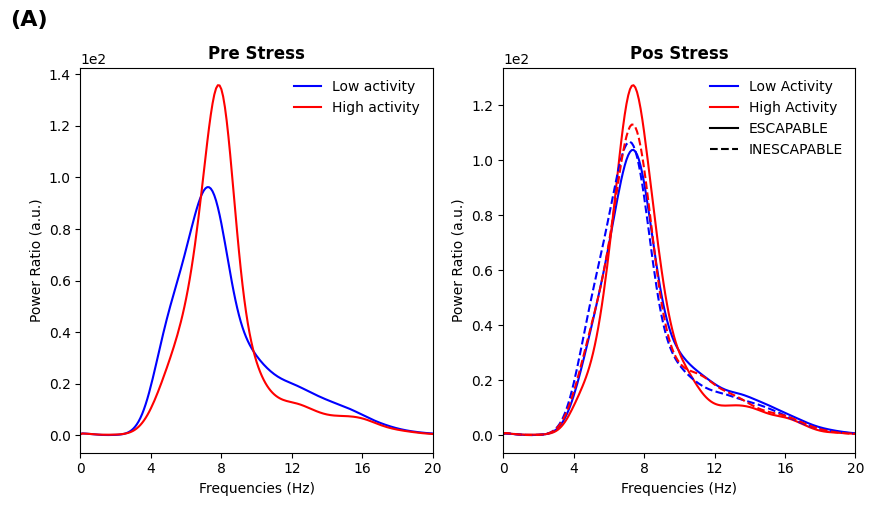

In [ ]:
import matplotlib.lines as mlines

s_low = np.mean(sxx_low, 0)
s_high = np.mean(sxx_high, 0)

s_low_escap = np.mean(sxx_low_escap, 0)
s_high_escap = np.mean(sxx_high_escap, 0)

s_low_inescap = np.mean(sxx_low_inescap, 0)
s_high_inescap = np.mean(sxx_high_inescap, 0)





figura = plt.figure(figsize=(10,5))
ax1 = figura.add_subplot(121)
# plt.suptitle('Low x High Activity', fontweight='bold'  )
ax1.text(-0.20, 1.15, "(A)", transform=ax1.transAxes, fontsize=16, fontweight="bold", va="top")

# plt.subplot(1,2,1)

plt.plot(f, s_low, color='b', label = 'Low activity')
plt.plot(f, s_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Pre Stress', fontweight='bold')
plt.ylabel('Power Ratio (a.u.)')
plt.xlabel('Frequencies (Hz)')
plt.legend(frameon=False)

ax1 = figura.add_subplot(122)
# plt.subplot(1,2,2)

plt.plot(f, s_low_escap, color='b', label = 'Low activity')
plt.plot(f, s_high_escap, color='r', label = 'High activity')
plt.plot(f, s_low_inescap, color='b', linestyle='--', label = 'Low activity')
plt.plot(f, s_high_inescap, color='r', linestyle='--', label = 'High activity')



line_solid = mlines.Line2D([], [], color='black', label='ESCAPABLE', linestyle='-')
line_dashed = mlines.Line2D([], [], color='black', label='INESCAPABLE', linestyle='--')

# Para a cor
line_blue = mlines.Line2D([], [], color='blue', label='Low Activity', linestyle='-')
line_red = mlines.Line2D([], [], color='red', label='High Activity', linestyle='-')

# Adicionando as legendas ao gráfico
first_legend = plt.legend(handles=[ line_blue, line_red, line_solid, line_dashed ], loc='upper right')
first_legend.set_frame_on(False)

# Configurações finais do gráfico
plt.xlim(0, 20)
plt.xticks(np.arange(0, 21, 4))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Pos Stress', fontweight='bold')
plt.ylabel('Power Ratio (a.u.)')
plt.xlabel('Frequencies (Hz)')



plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/low_versus_high_activ.jpeg')

># LOW x HIGH ACTIVITY PRL

In [ ]:
# PRE

sxx_low = []
sxx_high = []

for rato in ratos.keys():
  f, s_low, s_high = activity_versus_imobility( str(rato), 'OF_pre','data_PRL'  )
  sxx_low.append(s_low)
  sxx_high.append(s_high)

# POS ESCAPAVEL

sxx_low_escap = []
sxx_high_escap = []

for rato in ratos.keys():
  if ratos[rato]['grupo'] == 'ESCAPAVEL':
    f, s_low_escap, s_high_escap = activity_versus_imobility( str(rato), 'OF_pos','data_PRL'  )
    sxx_low_escap.append(s_low_escap)
    sxx_high_escap.append(s_high_escap)

# POS INESCAP

sxx_low_inescap = []
sxx_high_inescap = []

for rato in ratos.keys():
  if ratos[rato]['grupo'] == 'INESCAPAVEL':
    f, s_low_inescap, s_high_inescap = activity_versus_imobility( str(rato), 'OF_pos','data_PRL'  )
    sxx_low_inescap.append(s_low_inescap)
    sxx_high_inescap.append(s_high_inescap)


Text(0.5, 0, 'Frequencies (Hz)')

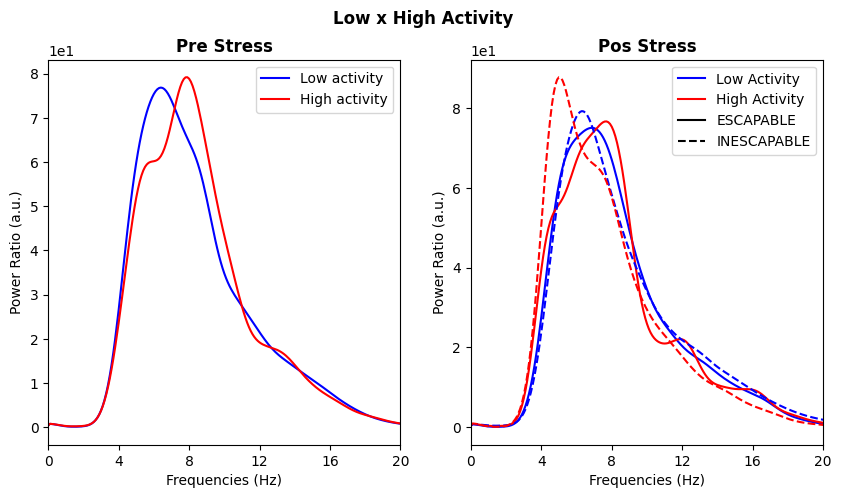

In [ ]:
import matplotlib.lines as mlines

s_low = np.mean(sxx_low, 0)
s_high = np.mean(sxx_high, 0)

s_low_escap = np.mean(sxx_low_escap, 0)
s_high_escap = np.mean(sxx_high_escap, 0)

s_low_inescap = np.mean(sxx_low_inescap, 0)
s_high_inescap = np.mean(sxx_high_inescap, 0)


plt.figure(figsize=(10,5))
plt.suptitle('Low x High Activity', fontweight='bold'  )

plt.subplot(1,2,1)

plt.plot(f, s_low, color='b', label = 'Low activity')
plt.plot(f, s_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Pre Stress', fontweight='bold')
plt.ylabel('Power Ratio (a.u.)')
plt.xlabel('Frequencies (Hz)')
plt.legend()


plt.subplot(1,2,2)

plt.plot(f, s_low_escap, color='b', label = 'Low activity')
plt.plot(f, s_high_escap, color='r', label = 'High activity')
plt.plot(f, s_low_inescap, color='b', linestyle='--', label = 'Low activity')
plt.plot(f, s_high_inescap, color='r', linestyle='--', label = 'High activity')



line_solid = mlines.Line2D([], [], color='black', label='ESCAPABLE', linestyle='-')
line_dashed = mlines.Line2D([], [], color='black', label='INESCAPABLE', linestyle='--')

# Para a cor
line_blue = mlines.Line2D([], [], color='blue', label='Low Activity', linestyle='-')
line_red = mlines.Line2D([], [], color='red', label='High Activity', linestyle='-')

# Adicionando as legendas ao gráfico
first_legend = plt.legend(handles=[ line_blue, line_red, line_solid, line_dashed ], loc='upper right')
# first_legend.set_frame_on(False)

# Configurações finais do gráfico
plt.xlim(0, 20)
plt.xticks(np.arange(0, 21, 4))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Pos Stress', fontweight='bold')
plt.ylabel('Power Ratio (a.u.)')
plt.xlabel('Frequencies (Hz)')



# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/low_versus_high_activ_PRL.jpeg')

> # FIG 1: LFP representative traces

In [ ]:
# LFP ESCAPABLE
prl_pre_escap = data_animals_escap[(data_animals_escap['ANIMAL'] == 'CCM65') & (data_animals_escap['CONDICAO'] == 'OF_pre') & (data_animals_escap['REGIAO'] == 'PRL') ]['DATA']
prl_pre_escap = prl_pre_escap[0][0:1000]
prl_pos_escap = data_animals_escap[(data_animals_escap['ANIMAL'] == 'CCM65') & (data_animals_escap['CONDICAO'] == 'OF_pos') & (data_animals_escap['REGIAO'] == 'PRL') ]['DATA']
prl_pos_escap = prl_pos_escap[0][0:1000]

bla_pre_escap = data_animals_escap[(data_animals_escap['ANIMAL'] == 'CCM65') & (data_animals_escap['CONDICAO'] == 'OF_pre') & (data_animals_escap['REGIAO'] == 'BLA') ]['DATA']
bla_pre_escap = bla_pre_escap[0][0:1000]
bla_pos_escap = data_animals_escap[(data_animals_escap['ANIMAL'] == 'CCM65') & (data_animals_escap['CONDICAO'] == 'OF_pos') & (data_animals_escap['REGIAO'] == 'BLA') ]['DATA']
bla_pos_escap = bla_pos_escap[0][0:1000]

dHPC_pre_escap = data_animals_escap[(data_animals_escap['ANIMAL'] == 'CCM65') & (data_animals_escap['CONDICAO'] == 'OF_pre') & (data_animals_escap['REGIAO'] == 'dHPC') ]['DATA']
dHPC_pre_escap = dHPC_pre_escap[0][0:1000]
dHPC_pos_escap = data_animals_escap[(data_animals_escap['ANIMAL'] == 'CCM65') & (data_animals_escap['CONDICAO'] == 'OF_pos') & (data_animals_escap['REGIAO'] == 'dHPC') ]['DATA']
dHPC_pos_escap = dHPC_pos_escap[0][0:1000]

vHPC_pre_escap = data_animals_escap[(data_animals_escap['ANIMAL'] == 'CCM65') & (data_animals_escap['CONDICAO'] == 'OF_pre') & (data_animals_escap['REGIAO'] == 'vHPC') ]['DATA']
vHPC_pre_escap = vHPC_pre_escap[0][0:1000]
vHPC_pos_escap = data_animals_escap[(data_animals_escap['ANIMAL'] == 'CCM65') & (data_animals_escap['CONDICAO'] == 'OF_pos') & (data_animals_escap['REGIAO'] == 'vHPC') ]['DATA']
vHPC_pos_escap = vHPC_pos_escap[0][0:1000]
lfp_signals = [prl_pre_escap, bla_pre_escap, dHPC_pre_escap, vHPC_pre_escap]


titles = ["PRL", "BLA", "dHPC", "vHPC"]
colors = ['darkred', 'darkblue', 'darkgreen','olivedrab' ]

fig, axes = plt.subplots(4, 1, figsize=(10, 8))  #

# Determinando o valor máximo de x para todos os sinais para alinhar a escala
max_length = max([len(signal) for signal in lfp_signals])

for i, sinal in enumerate(lfp_signals):
    ax = axes[i]
    ax.plot(sinal, color=colors[i])
    ax.set_title(titles[i], loc="left")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color((0, 0, 0, 0))

    ax.set_xlim([0, max_length + 200])  # +200 para acomodar a barra de escala

# Desenhando a escala de mV e ms no último sinal
ax = axes[-1]
ylim = ax.get_ylim()
xlim = ax.get_xlim()


scale_x_position = max_length  # Alinhado com o final do sinal LFP
ax.plot([scale_x_position, scale_x_position - 250], [ylim[0], ylim[0]], color='black', lw=2)


vertical_scale_value = 200
ax.plot([scale_x_position, scale_x_position], [ylim[0], ylim[0] + vertical_scale_value], color='black', lw=2)


ax.text(scale_x_position - 125, ylim[0] - 60 , '250 ms', ha='center', va='top')
ax.text(scale_x_position + 0.02 * (xlim[1] - xlim[0]), ylim[0] + 50 , '200 mV', ha='left', va='center', rotation='vertical')


plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/lfp_escapable.jpeg')
plt.show()




NameError: name 'data_animals_escap' is not defined

In [ ]:
# LFP INESCAPABLE
prl_pre_inescap = data_animals_inescap[(data_animals_inescap['ANIMAL'] == 'CCM192') & (data_animals_inescap['CONDICAO'] == 'OF_pre') & (data_animals_inescap['REGIAO'] == 'PRL') ]['DATA']
prl_pre_inescap = prl_pre_inescap[0][8000:9000]
prl_pos_inescap = data_animals_inescap[(data_animals_inescap['ANIMAL'] == 'CCM192') & (data_animals_inescap['CONDICAO'] == 'OF_pos') & (data_animals_inescap['REGIAO'] == 'PRL') ]['DATA']
prl_pos_inescap = prl_pos_inescap[0][8000:9000]

bla_pre_inescap = data_animals_inescap[(data_animals_inescap['ANIMAL'] == 'CCM192') & (data_animals_inescap['CONDICAO'] == 'OF_pre') & (data_animals_inescap['REGIAO'] == 'BLA') ]['DATA']
bla_pre_inescap = bla_pre_inescap[0][8000:9000]
bla_pos_inescap = data_animals_inescap[(data_animals_inescap['ANIMAL'] == 'CCM192') & (data_animals_inescap['CONDICAO'] == 'OF_pos') & (data_animals_inescap['REGIAO'] == 'BLA') ]['DATA']
bla_pos_inescap = bla_pos_inescap[0][8000:9000]

dHPC_pre_inescap = data_animals_inescap[(data_animals_inescap['ANIMAL'] == 'CCM192') & (data_animals_inescap['CONDICAO'] == 'OF_pre') & (data_animals_inescap['REGIAO'] == 'dHPC') ]['DATA']
dHPC_pre_inescap = dHPC_pre_inescap[0][8000:9000]
dHPC_pos_inescap = data_animals_inescap[(data_animals_inescap['ANIMAL'] == 'CCM192') & (data_animals_inescap['CONDICAO'] == 'OF_pos') & (data_animals_inescap['REGIAO'] == 'dHPC') ]['DATA']
dHPC_pos_inescap = dHPC_pos_inescap[0][8000:9000]

vHPC_pre_inescap = data_animals_inescap[(data_animals_inescap['ANIMAL'] == 'CCM192') & (data_animals_inescap['CONDICAO'] == 'OF_pre') & (data_animals_inescap['REGIAO'] == 'vHPC') ]['DATA']
vHPC_pre_inescap = vHPC_pre_inescap[0][8000:9000]
vHPC_pos_inescap = data_animals_inescap[(data_animals_inescap['ANIMAL'] == 'CCM192') & (data_animals_inescap['CONDICAO'] == 'OF_pos') & (data_animals_inescap['REGIAO'] == 'vHPC') ]['DATA']
vHPC_pos_inescap = vHPC_pos_inescap[0][8000:9000]
lfp_signals_inescap = [prl_pre_inescap, bla_pre_inescap, dHPC_pre_inescap, vHPC_pre_inescap]

titles = ["PRL", "BLA", "dHPC", "vHPC"]
colors = ['darkred', 'darkblue', 'darkgreen','olivedrab' ]

fig, axes = plt.subplots(4, 1, figsize=(10, 8))  #

# Determinando o valor máximo de x para todos os sinais para alinhar a escala
max_length = max([len(signal) for signal in lfp_signals_inescap])

for i, sinal in enumerate(lfp_signals_inescap):
    ax = axes[i]
    ax.plot(sinal, color=colors[i])
    ax.set_title(titles[i], loc="left")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color((0, 0, 0, 0))

    ax.set_xlim([0, max_length + 200])  # +200 para acomodar a barra de escala

# Desenhando a escala de mV e ms no último sinal
ax = axes[-1]
ylim = ax.get_ylim()
xlim = ax.get_xlim()


scale_x_position = max_length  # Alinhado com o final do sinal LFP
ax.plot([scale_x_position, scale_x_position - 250], [ylim[0], ylim[0]], color='black', lw=2)


vertical_scale_value = 200
ax.plot([scale_x_position, scale_x_position], [ylim[0], ylim[0] + vertical_scale_value], color='black', lw=2)


ax.text(scale_x_position - 125, ylim[0] - 60 , '250 ms', ha='center', va='top')
ax.text(scale_x_position + 0.02 * (xlim[1] - xlim[0]), ylim[0] + 50 , '200 mV', ha='left', va='center', rotation='vertical')


plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/lfp_inescapable.jpeg')
plt.show()


> # THETA TRACE FILTERED

In [ ]:
# from scipy import signal as sp_signal  # Importa o módulo signal com um alias para evitar conflitos





theta_fcut = [4, 18]

lfp_PRE = bandpass(PRL_CCM68_PRE_P[0],  [4, 18], 4, 1000)
# lfp_POS = basspass(bla_pos_inescap, theta_fcut, 4, 1000)
lfp_pre_II = eegfilt(PRL_CCM68_PRE_P[0],1000,4,18)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(8500.0, 10000.0)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


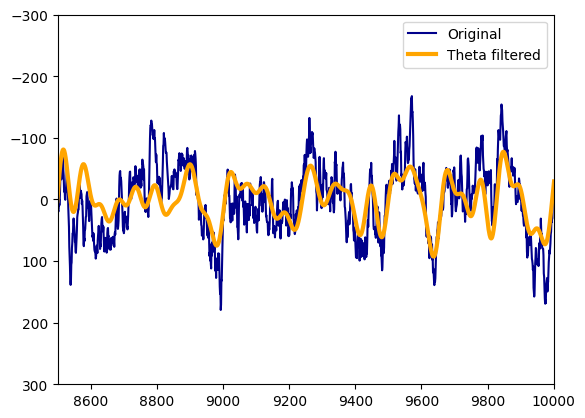

In [ ]:
plt.plot(PRL_CCM68_PRE_P[0], color = 'darkblue', label = 'Original')
plt.plot(lfp_pre_II, color = 'orange', lw = 3,label = 'Theta filtered')
plt.legend()
plt.ylim(300,-300)
plt.xlim(8500,10000)

(9000.0, 10000.0)

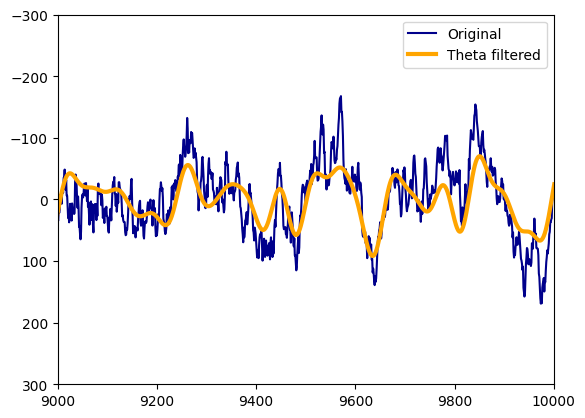

In [ ]:
plt.plot(PRL_CCM68_PRE_P[0], color = 'darkblue', label = 'Original')
plt.plot(lfp_PRE, color = 'orange', lw = 3,label = 'Theta filtered')
plt.legend()
plt.ylim(300,-300)
plt.xlim(9000,10000)

> # PSD

In [ ]:
# esse df possui o psd de cada animal

df_psd_animals_escap = pd.concat([ df_ccm68,df_ccm65,df_ccm191  ])
df_psd_animals_inescap = pd.concat([ df_ccm05,df_ccm192, df_ccm193   ])

In [ ]:
# ESCAP

mean_p_prl_pre_parado_escap = np.mean([power_prl_ccm68_pre_parado,  power_prl_ccm65_pre_parado, power_prl_ccm191_pre_parado  ],axis = 0)
mean_p_prl_pos_parado_escap = np.mean([power_prl_ccm68_pos_parado, power_prl_ccm65_pos_parado, power_prl_ccm191_pos_parado   ],axis = 0)

mean_p_bla_pre_parado_escap = np.mean([power_bla_ccm68_pre_parado, power_bla_ccm65_pre_parado, power_bla_ccm191_pre_parado  ],axis = 0)
mean_p_bla_pos_parado_escap = np.mean([power_bla_ccm68_pos_parado, power_bla_ccm65_pos_parado , power_bla_ccm191_pos_parado   ],axis = 0)


mean_p_dhpc_pre_parado_escap = np.mean([power_dhpc_ccm68_pre_parado, power_dhpc_ccm65_pre_parado,  power_dhpc_ccm191_pre_parado   ],axis = 0)
mean_p_dhpc_pos_parado_escap = np.mean([power_dhpc_ccm68_pos_parado, power_dhpc_ccm65_pos_parado, power_dhpc_ccm191_pos_parado    ],axis = 0)

mean_p_vhpc_pre_parado_escap = np.mean([power_vhpc_ccm68_pre_parado, power_vhpc_ccm65_pre_parado, power_vhpc_ccm191_pre_parado   ],axis = 0)
mean_p_vhpc_pos_parado_escap = np.mean([power_vhpc_ccm68_pos_parado, power_vhpc_ccm65_pos_parado, power_vhpc_ccm191_pos_parado   ],axis = 0)

#INESCAP
mean_p_prl_pre_parado_inescap = np.mean([power_prl_ccm05_pre_parado, power_prl_ccm192_pre_parado   , power_prl_ccm193_pre_parado  ],axis = 0)
mean_p_prl_pos_parado_inescap = np.mean([power_prl_ccm05_pos_parado,  power_prl_ccm192_pos_parado, power_prl_ccm193_pos_parado   ],axis = 0)


mean_p_bla_pre_parado_inescap = np.mean([ power_bla_ccm05_pre_parado , power_bla_ccm192_pre_parado , power_bla_ccm193_pre_parado ],axis = 0)
mean_p_bla_pos_parado_inescap = np.mean([ power_bla_ccm05_pos_parado , power_bla_ccm192_pos_parado, power_bla_ccm193_pos_parado ],axis = 0)

mean_p_dhpc_pre_parado_inescap = np.mean([ power_dhpc_ccm05_pre_parado, power_dhpc_ccm192_pre_parado , power_dhpc_ccm193_pre_parado ],axis = 0)
mean_p_dhpc_pos_parado_inescap = np.mean([ power_dhpc_ccm05_pos_parado ,  power_dhpc_ccm192_pos_parado, power_dhpc_ccm193_pos_parado   ],axis = 0)

mean_p_vhpc_pre_parado_inescap = np.mean([ power_vhpc_ccm05_pre_parado, power_vhpc_ccm192_pre_parado , power_vhpc_ccm193_pre_parado   ],axis = 0)
mean_p_vhpc_pos_parado_inescap = np.mean([ power_vhpc_ccm05_pos_parado ,  power_vhpc_ccm192_pos_parado, power_vhpc_ccm193_pos_parado ],axis = 0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ESSES DATAFRAMES CONTÉM A MÉDIA DO PSD DE TODOS OS ANIMAIS
#GRUPO ESCAPAVEL


df_welch_pre_escap = pd.DataFrame({'mean_power_prl':mean_p_prl_pre_parado_escap, 'mean_power_bla': mean_p_bla_pre_parado_escap, 'mean_power_dhpc': mean_p_dhpc_pre_parado_escap, 'mean_power_vhpc': mean_p_vhpc_pre_parado_escap,'f':f})
df_welch_pre_escap['banda'] = df_welch_pre_escap['f'].apply(mapear_banda)

df_welch_pos_escap = pd.DataFrame({'mean_power_prl':mean_p_prl_pos_parado_escap, 'mean_power_bla':mean_p_bla_pos_parado_escap, 'mean_power_dhpc': mean_p_dhpc_pos_parado_escap,'mean_power_vhpc': mean_p_vhpc_pos_parado_escap, 'f':f})
df_welch_pos_escap['banda'] = df_welch_pos_escap['f'].apply(mapear_banda)

In [ ]:
# ESSES DATAFRAMES CONTÉM A MÉDIA DO PSD DE TODOS OS ANIMAIS
#GRUPO INESCAPAVEL

df_welch_pre_inescap = pd.DataFrame({'mean_power_prl':mean_p_prl_pre_parado_inescap, 'mean_power_bla':mean_p_bla_pre_parado_inescap, 'mean_power_dhpc': mean_p_dhpc_pre_parado_inescap, 'mean_power_vhpc': mean_p_vhpc_pre_parado_inescap,'f':f})
df_welch_pre_inescap['banda'] = df_welch_pre_inescap['f'].apply(mapear_banda)

df_welch_pos_inescap = pd.DataFrame({'mean_power_prl':mean_p_prl_pos_parado_inescap, 'mean_power_bla':mean_p_bla_pos_parado_inescap, 'mean_power_dhpc': mean_p_dhpc_pos_parado_inescap,'mean_power_vhpc': mean_p_vhpc_pos_parado_inescap, 'f':f})
df_welch_pos_inescap['banda'] = df_welch_pos_inescap['f'].apply(mapear_banda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> #  FIG 2: PSD FIGURES

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


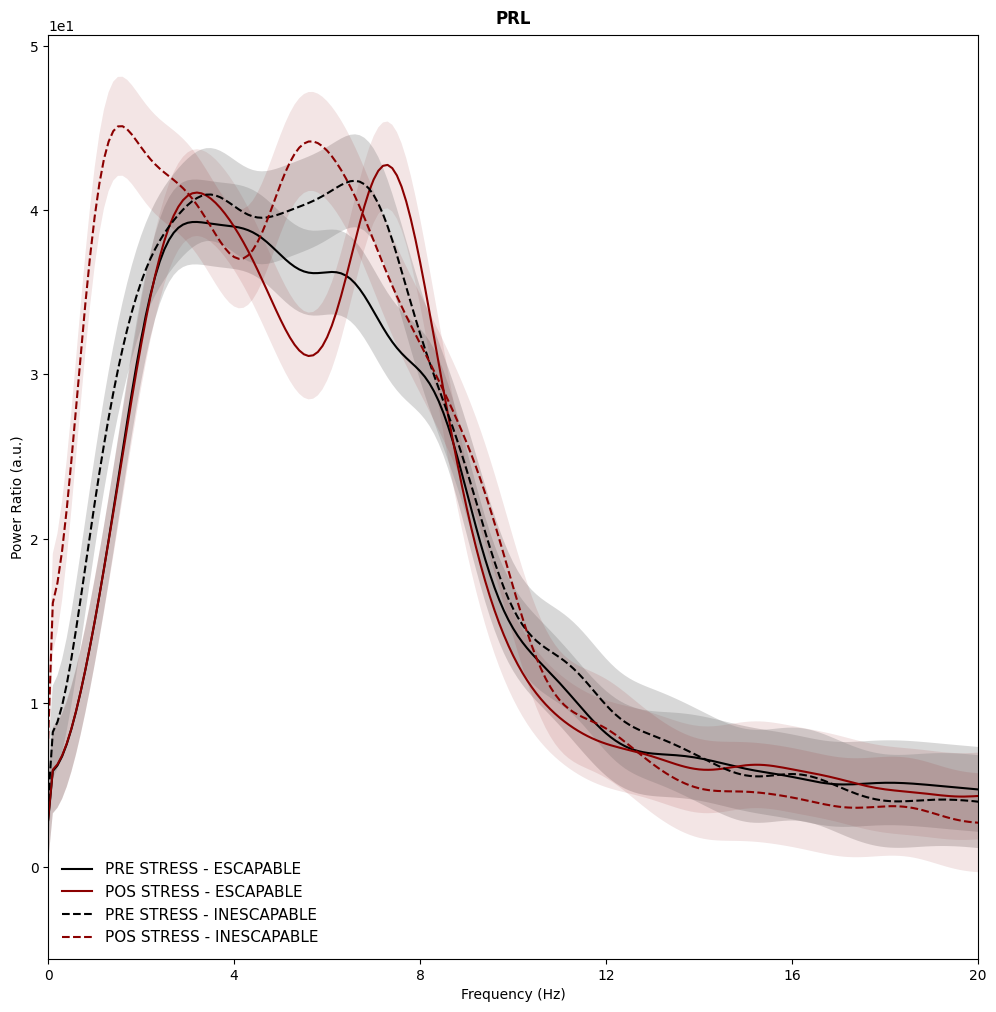

In [ ]:
figura = plt.figure(figsize=(12,12))


x = df_welch_pre_escap['f']
y_prl = (df_welch_pre_escap['mean_power_prl'] )
std = np.std(y_prl)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_prl = (df_welch_pos_escap['mean_power_prl'] )
std_pos = np.std(y_pos_prl)/np.sqrt(3)

plt.plot(x, y_prl, linewidth=1.5, color='black', label='PRE STRESS - ESCAPABLE')
plt.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='POS STRESS - ESCAPABLE')
plt.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1,  edgecolor=None)

x_inesc = df_welch_pre_inescap['f']
y_prl_inesc = (df_welch_pre_inescap['mean_power_prl'] ) #aqui foi adicionado uma constante para eliminar valores negativos do calculo e conseguir calcular o std
std_inesc = np.std(y_prl_inesc)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos_inesc = df_welch_pos_inescap['f']
y_pos_prl_inesc = (df_welch_pos_inescap['mean_power_prl'] )
std_pos_inesc = np.std(y_pos_prl_inesc)/np.sqrt(3)

plt.plot(x_inesc, y_prl_inesc, linewidth=1.5, linestyle='--', color='black', label='PRE STRESS - INESCAPABLE')
plt.fill_between(x_inesc, y_prl_inesc - std_inesc, y_prl_inesc + std_inesc, color='gray', alpha=0.3,  edgecolor=None)

plt.plot(x_pos_inesc, y_pos_prl_inesc, linewidth=1.5, linestyle='--', color='darkred', label='POS STRESS - INESCAPABLE')
plt.fill_between(x_pos_inesc, y_pos_prl_inesc - std_pos_inesc, y_pos_prl_inesc + std_pos_inesc, color='darkred', alpha=0.1,  edgecolor=None)








plt.grid(False)

# plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=11, loc='lower left', frameon=False)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Ratio (a.u.)')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))
# plt.yticks(np.arange(0, 6, 2))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('PRL', fontweight='bold',  pad = 8, fontsize = 12)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_theta_PRL_imovel.jpeg')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


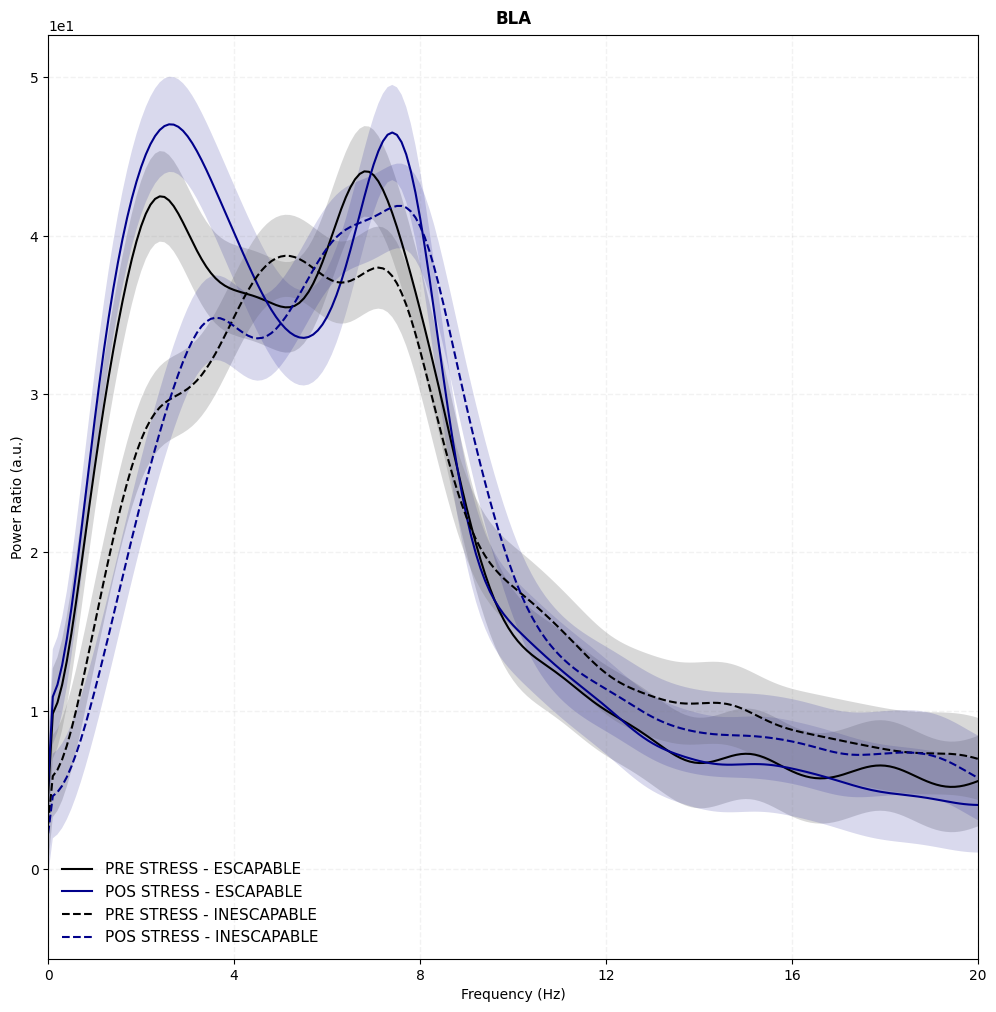

In [ ]:

figura = plt.figure(figsize=(12,12))


x = df_welch_pre_escap['f']
y_bla = (df_welch_pre_escap ['mean_power_bla'] + 1e-10)
std_bla = np.std(y_bla)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_bla = (df_welch_pos_escap ['mean_power_bla'] )
std_pos_bla = np.std(y_pos_bla)/np.sqrt(3)


plt.plot(x, y_bla, linewidth=1.5, color='black', label='PRE STRESS - ESCAPABLE')
plt.fill_between(x, y_bla - std_bla, y_bla + std_bla, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_bla, linewidth=1.5, color='darkblue', label='POS STRESS - ESCAPABLE')
plt.fill_between(x_pos, y_pos_bla - std_pos_bla, y_pos_bla + std_pos_bla, color='darkblue', alpha=0.15, edgecolor=None)


x_inescap = df_welch_pre_inescap['f']
y_bla_inescap = (df_welch_pre_inescap ['mean_power_bla'] )
std_bla_inescap = np.std(y_bla_inescap)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos_inescap = df_welch_pos_inescap['f']
y_pos_bla_inescap = (df_welch_pos_inescap ['mean_power_bla'] )
std_pos_bla_inescap = np.std(y_pos_bla_inescap)/np.sqrt(3)


plt.plot(x_inescap, y_bla_inescap, linewidth=1.5, linestyle='--', color='black', label='PRE STRESS - INESCAPABLE')
plt.fill_between(x_inescap, y_bla_inescap - std_bla_inescap, y_bla_inescap + std_bla_inescap, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos_inescap, y_pos_bla_inescap, linewidth=1.5,linestyle='--', color='darkblue', label='POS STRESS - INESCAPABLE')
plt.fill_between(x_pos_inescap, y_pos_bla_inescap - std_pos_bla_inescap, y_pos_bla_inescap + std_pos_bla_inescap, color='darkblue', alpha=0.15, edgecolor=None)



plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=11, loc='lower left', frameon=False)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Ratio (a.u.)')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('BLA', fontweight='bold',  pad = 8, fontsize = 12)


plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_theta_BLA_imovel.jpeg')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


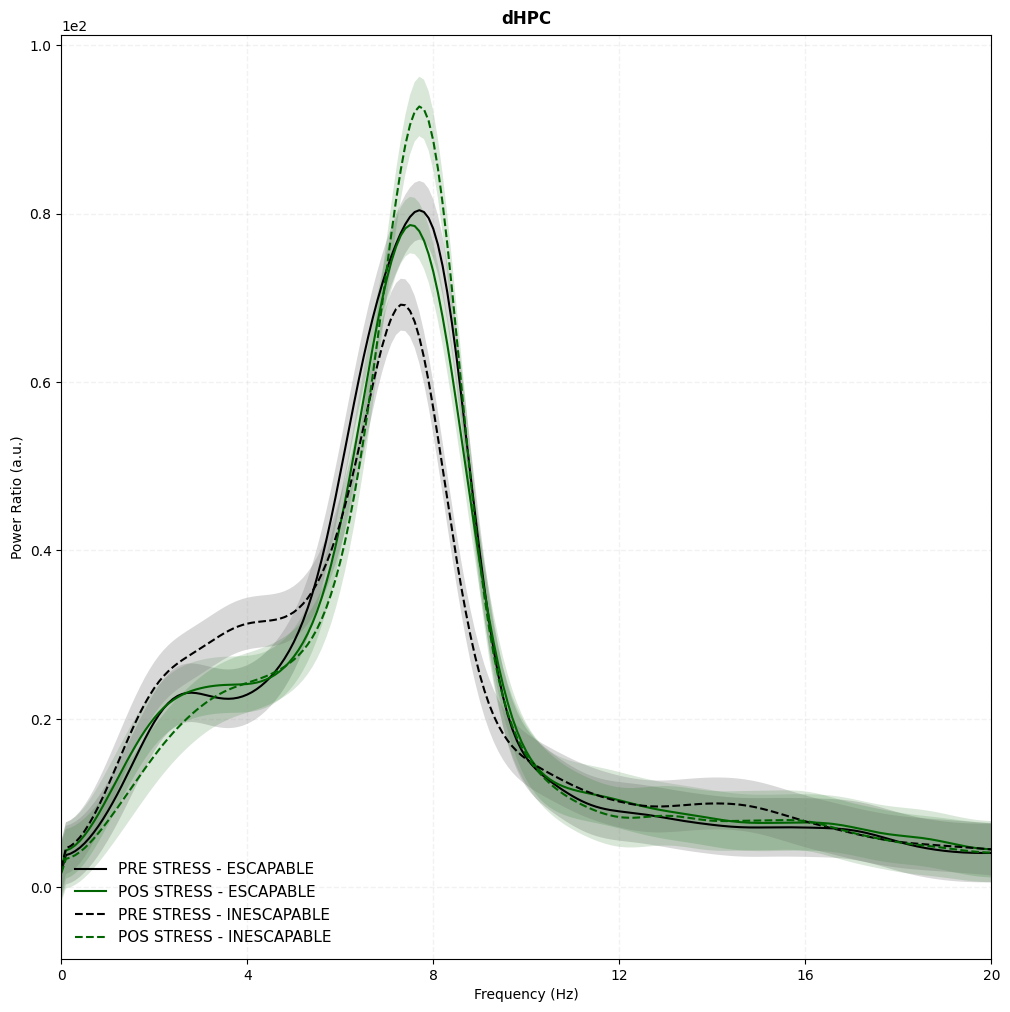

In [ ]:


figura = plt.figure(figsize=(12,12))


x = df_welch_pre_escap['f']
y_dhpc = (df_welch_pre_escap ['mean_power_dhpc'] )
std_dhpc = np.std(y_dhpc)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_dhpc = (df_welch_pos_escap ['mean_power_dhpc'] )
std_pos_dhpc = np.std(y_pos_dhpc)/np.sqrt(3)


plt.plot(x, y_dhpc, linewidth=1.5, color='k', label='PRE STRESS - ESCAPABLE')
plt.fill_between(x, y_dhpc - std_dhpc, y_dhpc + std_dhpc, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_dhpc, linewidth=1.5, color='darkgreen', label='POS STRESS - ESCAPABLE')
plt.fill_between(x_pos, y_pos_dhpc - std_pos_dhpc, y_pos_dhpc + std_pos_dhpc, color='darkgreen', alpha=0.15, edgecolor=None)


x_inescap = df_welch_pre_inescap['f']
y_dhpc_inescap = (df_welch_pre_inescap ['mean_power_dhpc'] )
std_dhpc_inescap = np.std(y_dhpc_inescap)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos_inescap = df_welch_pos_inescap['f']
y_pos_dhpc_inescap = (df_welch_pos_inescap ['mean_power_dhpc'] )
std_pos_dhpc_inescap = np.std(y_pos_dhpc_inescap)/np.sqrt(3)


plt.plot(x_inescap, y_dhpc_inescap, linewidth=1.5,linestyle='--', color='k', label='PRE STRESS - INESCAPABLE')
plt.fill_between(x_inescap, y_dhpc_inescap - std_dhpc_inescap, y_dhpc_inescap + std_dhpc_inescap, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos_inescap, y_pos_dhpc_inescap, linewidth=1.5, linestyle='--',color='darkgreen', label='POS STRESS - INESCAPABLE')
plt.fill_between(x_pos_inescap, y_pos_dhpc_inescap - std_pos_dhpc_inescap, y_pos_dhpc_inescap + std_pos_dhpc_inescap, color='darkgreen', alpha=0.15, edgecolor=None)











plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=11, loc='lower left', frameon=False)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Ratio (a.u.)')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('dHPC', fontweight='bold',  pad = 8, fontsize = 12)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_theta_dHPC_imovel.jpeg')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


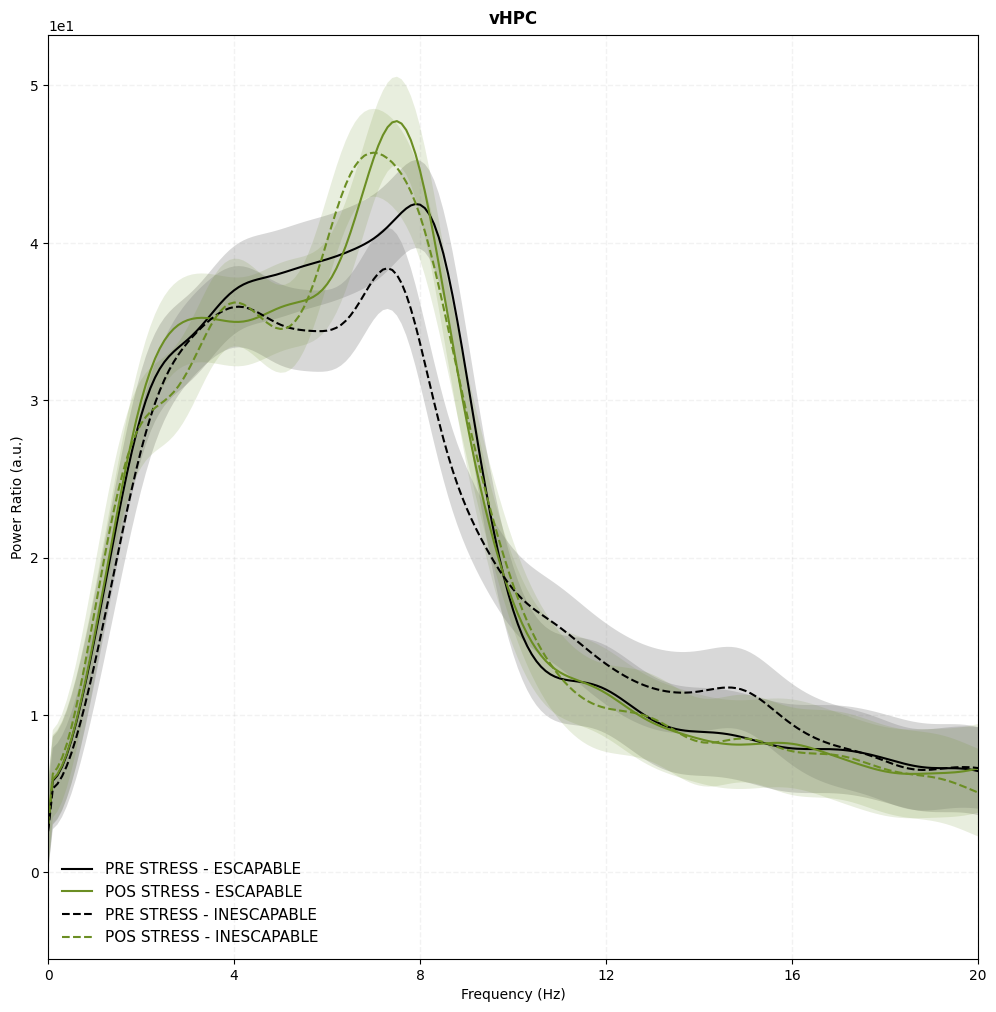

In [ ]:
figura = plt.figure(figsize=(12,12))

x = df_welch_pre_escap['f']
y_vhpc = (df_welch_pre_escap ['mean_power_vhpc'] )
std_vhpc = np.std(y_vhpc)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_vhpc = (df_welch_pos_escap ['mean_power_vhpc'] )
std_pos_vhpc = np.std(y_pos_vhpc)/np.sqrt(3)


plt.plot(x, y_vhpc, linewidth=1.5, color='k', label='PRE STRESS - ESCAPABLE')
plt.fill_between(x, y_vhpc - std_vhpc, y_vhpc + std_vhpc, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_vhpc, linewidth=1.5, color='olivedrab', label='POS STRESS - ESCAPABLE')
plt.fill_between(x_pos, y_pos_vhpc - std_pos_vhpc, y_pos_vhpc + std_pos_vhpc, color='olivedrab', alpha=0.15, edgecolor=None)


x_inescap = df_welch_pre_inescap['f']
y_vhpc_inescap = (df_welch_pre_inescap ['mean_power_vhpc'] )
std_vhpc_inescap = np.std(y_vhpc_inescap)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos_inescap = df_welch_pos_inescap['f']
y_pos_vhpc_inescap = (df_welch_pos_inescap ['mean_power_vhpc'] )
std_pos_vhpc_inescap = np.std(y_pos_vhpc_inescap)/np.sqrt(3)


plt.plot(x_inescap, y_vhpc_inescap, linewidth=1.5, linestyle='--',color='k', label='PRE STRESS - INESCAPABLE')
plt.fill_between(x_inescap, y_vhpc_inescap - std_vhpc_inescap, y_vhpc_inescap + std_vhpc_inescap, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos_inescap, y_pos_vhpc_inescap, linewidth=1.5,linestyle='--', color='olivedrab', label='POS STRESS - INESCAPABLE')
plt.fill_between(x_pos_inescap, y_pos_vhpc_inescap - std_pos_vhpc_inescap, y_pos_vhpc_inescap + std_pos_vhpc_inescap, color='olivedrab', alpha=0.15, edgecolor=None)










plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.1, axis='both', which='both')
plt.legend(fontsize=11, loc='lower left', frameon=False)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Ratio (a.u.)')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.title('vHPC', fontweight='bold',  pad = 8, fontsize = 12)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_theta_vHPC_imovel.jpeg')


# GRAFICO DE BARRAS THETA

In [ ]:
# FAZENDO O DF COM A MEDIA DO PSD DE CADA ANIMAL para o barplot


df_psd_animals_escap['banda'] = df_psd_animals_escap['F'].apply(mapear_banda)
agrupar_escap = df_psd_animals_escap.groupby(['ANIMAL', 'CONDICAO', 'REGIAO', 'banda'])

#  média para cada animal de cada grupo
mean_psd_animal_escap = agrupar_escap['PSD'].mean().reset_index()
mean_psd_animal_escap['GRUPO'] = 'ESCAPABLE'
psd_theta_por_animal_escap = pd.DataFrame(mean_psd_animal_escap[(mean_psd_animal_escap['banda'] == 'Theta') ])


df_psd_animals_inescap['banda'] = df_psd_animals_inescap['F'].apply(mapear_banda)
agrupar_inescap = df_psd_animals_inescap.groupby(['ANIMAL', 'CONDICAO', 'REGIAO', 'banda'])

#  média para cada grupo
mean_psd_animal_inescap = agrupar_inescap['PSD'].mean().reset_index()
mean_psd_animal_inescap['GRUPO'] = 'INESCAPABLE'
psd_theta_por_animal_inescap = pd.DataFrame(mean_psd_animal_inescap[(mean_psd_animal_inescap['banda'] == 'Theta') ])

psd_theta_por_animal = pd.concat([psd_theta_por_animal_escap,psd_theta_por_animal_inescap])

In [ ]:
# CRIANDO UM DF COM A MEDIA DO PSD DE TODOS OS ANIMAIS PARA FAZER O BARPLOT

mean_prl_pre_escap =   pd.DataFrame({'PSD' : np.array(df_welch_pre_escap[(df_welch_pre_escap['banda'] == 'Theta') ]['mean_power_prl']), 'CONDICAO': 'PRE', 'GRUPO': 'ESCAPABLE','REGIAO': 'PRL'})
mean_bla_pre_escap =   pd.DataFrame({'PSD' : np.array((df_welch_pre_escap[(df_welch_pre_escap['banda'] == 'Theta') ]['mean_power_bla'] )), 'CONDICAO': 'PRE', 'GRUPO': 'ESCAPABLE','REGIAO': 'BLA'})
mean_dhpc_pre_escap =   pd.DataFrame({'PSD' : np.array((df_welch_pre_escap[(df_welch_pre_escap['banda'] == 'Theta') ]['mean_power_dhpc'] )), 'CONDICAO': 'PRE','GRUPO': 'ESCAPABLE', 'REGIAO': 'dHPC'})
mean_vhpc_pre_escap =   pd.DataFrame({'PSD' : np.array((df_welch_pre_escap[(df_welch_pre_escap['banda'] == 'Theta') ]['mean_power_vhpc'] )), 'CONDICAO': 'PRE','GRUPO': 'ESCAPABLE', 'REGIAO': 'vHPC'})


mean_prl_pos_escap =   pd.DataFrame({'PSD' : (np.array(df_welch_pos_escap[(df_welch_pos_escap['banda'] == 'Theta') ]['mean_power_prl'] )), 'CONDICAO': 'POS', 'GRUPO': 'ESCAPABLE','REGIAO': 'PRL'})
mean_bla_pos_escap =   pd.DataFrame({'PSD' : (np.array(df_welch_pos_escap[(df_welch_pos_escap['banda'] == 'Theta') ]['mean_power_bla'] )), 'CONDICAO': 'POS','GRUPO': 'ESCAPABLE', 'REGIAO': 'BLA'})
mean_dhpc_pos_escap =   pd.DataFrame({'PSD' : (np.array(df_welch_pos_escap[(df_welch_pos_escap['banda'] == 'Theta') ]['mean_power_dhpc'] )), 'CONDICAO': 'POS','GRUPO': 'ESCAPABLE', 'REGIAO': 'dHPC'})
mean_vhpc_pos_escap =   pd.DataFrame({'PSD' : (np.array(df_welch_pos_escap[(df_welch_pos_escap['banda'] == 'Theta') ]['mean_power_vhpc'] )), 'CONDICAO': 'POS','GRUPO': 'ESCAPABLE', 'REGIAO': 'vHPC'})


df_barplot_theta_escap = pd.concat([mean_prl_pre_escap,mean_bla_pre_escap,mean_dhpc_pre_escap,mean_vhpc_pre_escap, mean_prl_pos_escap, mean_bla_pos_escap, mean_dhpc_pos_escap, mean_vhpc_pos_escap  ])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# CRIANDO UM DF COM A MEDIA DO PSD DE TODOS OS ANIMAIS PARA FAZER O BARPLOT

mean_prl_pre_inescap =   pd.DataFrame({'PSD' : np.array((df_welch_pre_inescap[(df_welch_pre_inescap['banda'] == 'Theta') ]['mean_power_prl'])), 'CONDICAO': 'PRE', 'GRUPO': 'INESCAPABLE','REGIAO': 'PRL'})
mean_bla_pre_inescap =   pd.DataFrame({'PSD' : np.array((df_welch_pre_inescap[(df_welch_pre_inescap['banda'] == 'Theta') ]['mean_power_bla'] )), 'CONDICAO': 'PRE', 'GRUPO': 'INESCAPABLE','REGIAO': 'BLA'})
mean_dhpc_pre_inescap =   pd.DataFrame({'PSD' : np.array((df_welch_pre_inescap[(df_welch_pre_inescap['banda'] == 'Theta') ]['mean_power_dhpc'] )), 'CONDICAO': 'PRE','GRUPO': 'INESCAPABLE', 'REGIAO': 'dHPC'})
mean_vhpc_pre_inescap =   pd.DataFrame({'PSD' : np.array((df_welch_pre_inescap[(df_welch_pre_inescap['banda'] == 'Theta') ]['mean_power_vhpc'] )), 'CONDICAO': 'PRE', 'GRUPO': 'INESCAPABLE','REGIAO': 'vHPC'})


mean_prl_pos_inescap =   pd.DataFrame({'PSD' : (np.array(df_welch_pos_inescap[(df_welch_pos_inescap['banda'] == 'Theta') ]['mean_power_prl'] )), 'CONDICAO': 'POS','GRUPO': 'INESCAPABLE', 'REGIAO': 'PRL'})
mean_bla_pos_inescap =   pd.DataFrame({'PSD' : (np.array(df_welch_pos_inescap[(df_welch_pos_inescap['banda'] == 'Theta') ]['mean_power_bla'] )), 'CONDICAO': 'POS','GRUPO': 'INESCAPABLE', 'REGIAO': 'BLA'})
mean_dhpc_pos_inescap =   pd.DataFrame({'PSD' : (np.array(df_welch_pos_inescap[(df_welch_pos_inescap['banda'] == 'Theta') ]['mean_power_dhpc'] )), 'CONDICAO': 'POS','GRUPO': 'INESCAPABLE', 'REGIAO': 'dHPC'})
mean_vhpc_pos_inescap =   pd.DataFrame({'PSD' : (np.array(df_welch_pos_inescap[(df_welch_pos_inescap['banda'] == 'Theta') ]['mean_power_vhpc'] )), 'CONDICAO': 'POS','GRUPO': 'INESCAPABLE', 'REGIAO': 'vHPC'})


df_barplot_theta_inescap = pd.concat([mean_prl_pre_inescap,mean_bla_pre_inescap,mean_dhpc_pre_inescap,mean_vhpc_pre_inescap, mean_prl_pos_inescap, mean_bla_pos_inescap, mean_dhpc_pos_inescap, mean_vhpc_pos_inescap  ])

df_barplot_theta = pd.concat([df_barplot_theta_escap,df_barplot_theta_inescap])

<ipython-input-57-3ce289443669>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta_PRL['CONDICAO'] = pd.Categorical(df_barplot_theta_PRL['CONDICAO'], categories=["PRE", "POS"], ordered=True)
<ipython-input-57-3ce289443669>:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(


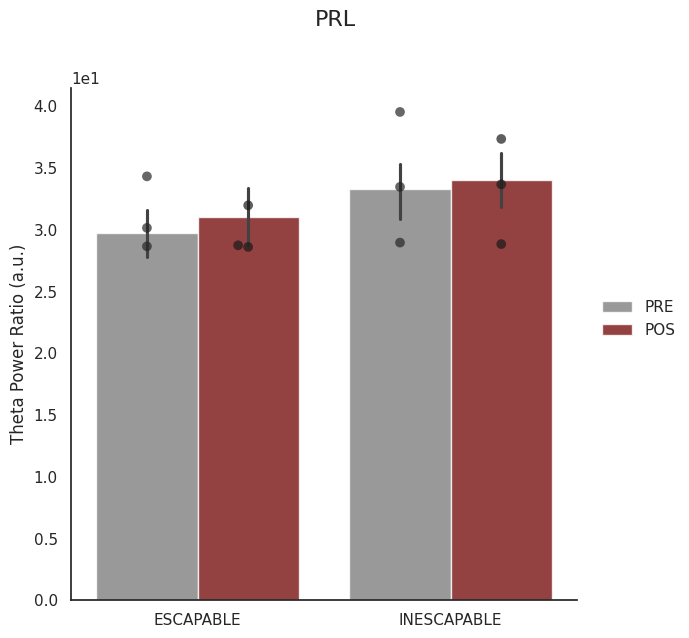

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_theta_PRL = df_barplot_theta[(df_barplot_theta['REGIAO'] == 'PRL')]
df_barplot_theta_PRL['CONDICAO'] = pd.Categorical(df_barplot_theta_PRL['CONDICAO'], categories=["PRE", "POS"], ordered=True)

g = sns.catplot(
    data=df_barplot_theta_PRL, kind="bar",
    x="GRUPO", y="PSD", hue="CONDICAO",
    errorbar='ci', palette=['grey', 'darkred'], alpha=0.8, height=6,
)

df_swarmplot_theta_PRL = psd_theta_por_animal[(psd_theta_por_animal['REGIAO'] == 'PRL')]


sns.swarmplot(
    data=df_swarmplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)



# g.ax.axhline(y=690, color='black', linestyle='-', linewidth=1.5, xmin=0.05, xmax=0.25)
# g.ax.text(0,690, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.4, xmax=0.6)
# g.ax.text(1,530, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.75, xmax=0.95)
# g.ax.text(2,530, '***', color='black', fontsize=12, ha='center')


titulo_principal = plt.suptitle("PRL", fontsize=16)
titulo_principal.set_y(1.1)

# g.despine(left=True)

# sns.despine(bottom=True)
g.set_axis_labels("", 'Theta Power Ratio (a.u.)')
g.legend.set_title("")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_barplot_theta_mean_PRL.jpeg')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-53-168b764ed376>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta_BLA['CONDICAO'] = pd.Categorical(df_barplot_theta_BLA['CONDICAO'], categories=["PRE", "POS"], ordered=True)
<ipython-input-53-168b764ed376>:24: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swar

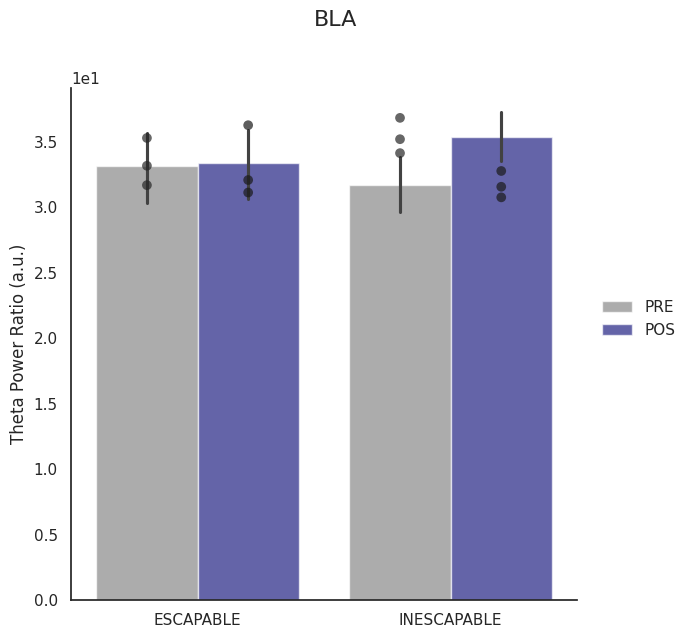

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="white")

# Filtrar DataFrame para a região 'BLA'
df_barplot_theta_BLA = df_barplot_theta[df_barplot_theta['REGIAO'] == 'BLA']

# Garantir que a ordem das condições seja 'PRE' seguido de 'POS'
df_barplot_theta_BLA['CONDICAO'] = pd.Categorical(df_barplot_theta_BLA['CONDICAO'], categories=["PRE", "POS"], ordered=True)


g = sns.catplot(
    data=df_barplot_theta_BLA, kind="bar",
    x="GRUPO", y="PSD", hue="CONDICAO",
    errorbar='ci', palette=['grey', 'darkblue'], alpha=0.65, height=6
)


df_swarmplot_theta_BLA = psd_theta_por_animal[psd_theta_por_animal['REGIAO'] == 'BLA']


sns.swarmplot(
    data=df_swarmplot_theta_BLA, x="GRUPO", y="PSD", hue="CONDICAO",
    color="k", size=7, dodge=True, alpha=0.7, legend=False
)


titulo_principal = plt.suptitle("BLA", fontsize=16)
titulo_principal.set_y(1.1)
g.set_axis_labels("", 'Theta Power Ratio (a.u.)')
g.legend.set_title("")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_barplot_theta_mean_BLA.jpeg')

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-54-f14bad86d7dc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta_dHPC['CONDICAO'] = pd.Categorical(df_barplot_theta_dHPC['CONDICAO'], categories=["PRE", "POS"], ordered=True)
<ipython-input-54-f14bad86d7dc>:17: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swa

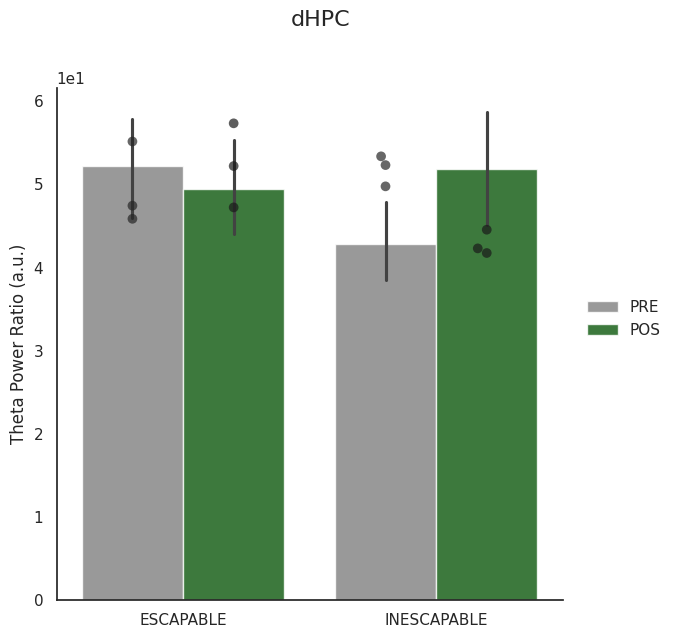

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_theta_dHPC = df_barplot_theta[(df_barplot_theta['REGIAO'] == 'dHPC')]
df_barplot_theta_dHPC['CONDICAO'] = pd.Categorical(df_barplot_theta_dHPC['CONDICAO'], categories=["PRE", "POS"], ordered=True)



g = sns.catplot(
    data=df_barplot_theta_dHPC, kind="bar",
    x="GRUPO", y="PSD", hue="CONDICAO",
    errorbar='ci', palette=['grey', 'darkgreen'], alpha=0.8, height=6,
)

df_swarmplot_theta_dHPC = psd_theta_por_animal[(psd_theta_por_animal['REGIAO'] == 'dHPC')]

sns.swarmplot(
    data=df_swarmplot_theta_dHPC, x="GRUPO", y="PSD", hue="CONDICAO",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)



# g.ax.axhline(y=60, color='black', linestyle='-', linewidth=1.5, xmin=0.25, xmax=0.8)
# g.ax.text(0,60, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.4, xmax=0.6)
# g.ax.text(1,530, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.75, xmax=0.95)
# g.ax.text(2,530, '***', color='black', fontsize=12, ha='center')


titulo_principal = plt.suptitle("dHPC", fontsize=16)
titulo_principal.set_y(1.1)

# g.despine(left=True)
g.set_axis_labels("", 'Theta Power Ratio (a.u.)')
g.legend.set_title("")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_barplot_theta_mean_dHPC.jpeg')

<ipython-input-64-df48a1d4119d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta_vHPC['CONDICAO'] = pd.Categorical(df_barplot_theta_vHPC['CONDICAO'], categories=["PRE", "POS"], ordered=True)
<ipython-input-64-df48a1d4119d>:20: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(


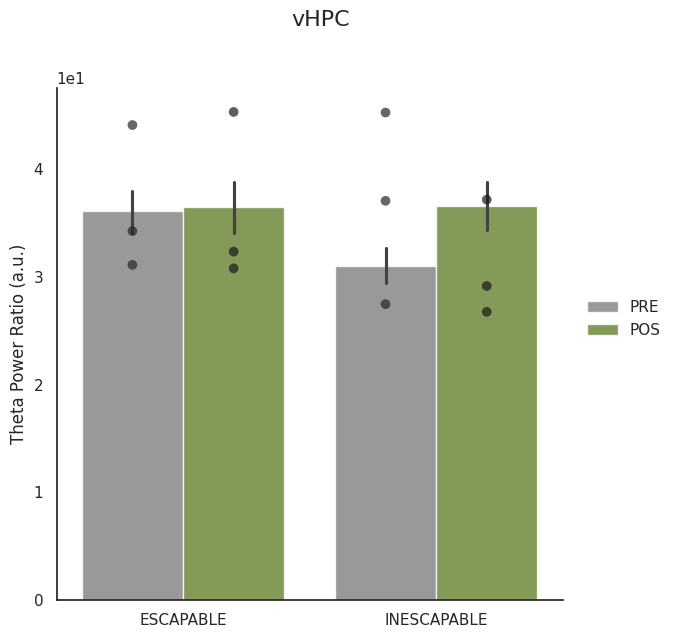

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_theta_vHPC = df_barplot_theta[(df_barplot_theta['REGIAO'] == 'vHPC')]
df_barplot_theta_vHPC['CONDICAO'] = pd.Categorical(df_barplot_theta_vHPC['CONDICAO'], categories=["PRE", "POS"], ordered=True)


g = sns.catplot(
    data=df_barplot_theta_vHPC, kind="bar",
    x="GRUPO", y="PSD", hue="CONDICAO",
    errorbar='ci', palette=['grey', 'olivedrab'], alpha=0.8, height=6,
)

# valor_maximo = df_barplot_theta_dHPC['PSD'].max()  # Ajuste conforme necessário
# axins.axhline(y=valor_maximo * 1.05, color='black', linestyle='-', linewidth=1.5, xmax=0.5)  # Ajuste o valor de xmax para posicionar a linha corretamente


df_swarmplot_theta_vHPC = psd_theta_por_animal[(psd_theta_por_animal['REGIAO'] == 'vHPC')]

sns.swarmplot(
    data=df_swarmplot_theta_vHPC, x="GRUPO", y="PSD", hue="CONDICAO",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)


# g.ax.axhline(y=690, color='black', linestyle='-', linewidth=1.5, xmin=0.05, xmax=0.25)
# g.ax.text(0,690, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.4, xmax=0.6)
# g.ax.text(1,530, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=5, color='black', linestyle='-', linewidth=1.5, xmin=0.75, xmax=0.95)
# g.ax.text(2,530, '***', color='black', fontsize=12, ha='center')
# g.ax.set_yticks(range(0, int(df_barplot_theta_vHPC['PSD'].max()) + 1, 1))



titulo_principal = plt.suptitle("vHPC", fontsize=16)
titulo_principal.set_y(1.1)

# g.despine(left=True)
g.set_axis_labels("", 'Theta Power Ratio (a.u.)')
g.legend.set_title("")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# g.ax.set_yticks(np.arange(0, int(df_barplot_theta_vHPC['PSD'].max()) + 1, 1))



# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_barplot_theta_mean_vHPC.jpeg')

> # PSD + GRAFICO DE BARRAS

<ipython-input-105-d971e4d0e8ff>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta_dHPC['CONDICAO'] = pd.Categorical(df_barplot_theta_dHPC['CONDICAO'], categories=["PRE", "POS"], ordered=True)
<ipython-input-105-d971e4d0e8ff>:69: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(data=df_swarmplot_theta_dHPC, x="GRUPO", y="PSD", hue="CONDICAO",


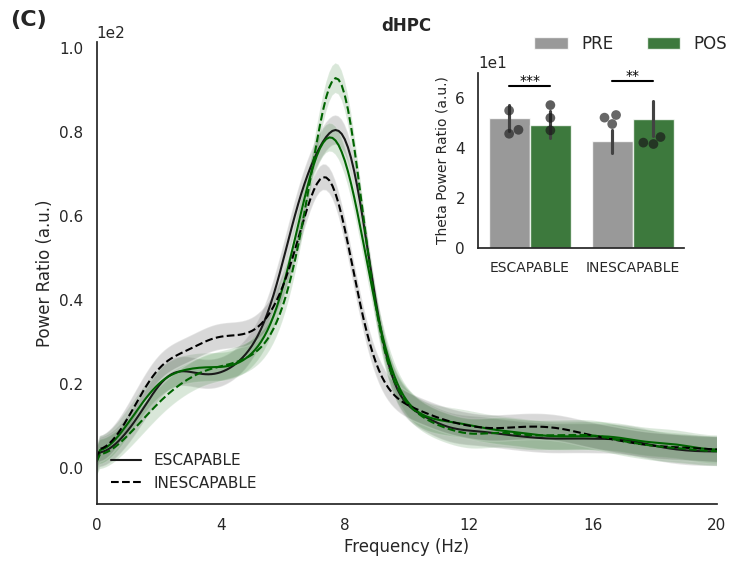

In [ ]:
fig, ax_main = plt.subplots(figsize=(8, 6))
ax_main.text(-0.14, 1.07, "(C)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")


x = df_welch_pre_escap['f']
y_dhpc = (df_welch_pre_escap ['mean_power_dhpc'] )
std_dhpc = np.std(y_dhpc)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_dhpc = (df_welch_pos_escap ['mean_power_dhpc'] )
std_pos_dhpc = np.std(y_pos_dhpc)/np.sqrt(3)


plt.plot(x, y_dhpc, linewidth=1.5, color='k', label='ESCAPABLE')
plt.fill_between(x, y_dhpc - std_dhpc, y_dhpc + std_dhpc, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_dhpc, linewidth=1.5, color='darkgreen') #, label='POS STRESS - ESCAPABLE'
plt.fill_between(x_pos, y_pos_dhpc - std_pos_dhpc, y_pos_dhpc + std_pos_dhpc, color='darkgreen', alpha=0.15, edgecolor=None)


x_inescap = df_welch_pre_inescap['f']
y_dhpc_inescap = (df_welch_pre_inescap ['mean_power_dhpc'] )
std_dhpc_inescap = np.std(y_dhpc_inescap)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos_inescap = df_welch_pos_inescap['f']
y_pos_dhpc_inescap = (df_welch_pos_inescap ['mean_power_dhpc'] )
std_pos_dhpc_inescap = np.std(y_pos_dhpc_inescap)/np.sqrt(3)


ax_main.plot(x_inescap, y_dhpc_inescap, linewidth=1.5, linestyle='--', color='black', label='INESCAPABLE')
ax_main.fill_between(x_inescap, y_dhpc_inescap - std_dhpc_inescap, y_dhpc_inescap + std_dhpc_inescap, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos_inescap, y_pos_dhpc_inescap, linewidth=1.5,linestyle='--', color='darkgreen' ) #label='POS STRESS - INESCAPABLE'
ax_main.fill_between(x_pos_inescap, y_pos_dhpc_inescap - std_pos_dhpc_inescap, y_pos_dhpc_inescap + std_pos_dhpc_inescap, color='darkgreen', alpha=0.15, edgecolor=None)

ax_main.grid(False)
ax_main.legend(fontsize=11, loc='lower left', frameon=False)
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Power Ratio (a.u.)')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_main.set_title('dHPC', fontweight='bold', pad=8, fontsize=12)
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)

sns.set_theme(style="white")

df_barplot_theta_dHPC = df_barplot_theta[(df_barplot_theta['REGIAO'] == 'dHPC')]
df_barplot_theta_dHPC['CONDICAO'] = pd.Categorical(df_barplot_theta_dHPC['CONDICAO'], categories=["PRE", "POS"], ordered=True)
df_swarmplot_theta_dHPC = psd_theta_por_animal[(psd_theta_por_animal['REGIAO'] == 'dHPC')]


# Inserir subplot no canto superior direito
axins = inset_axes(ax_main, width="35%", height="40%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 0.95, 0.95),
                   bbox_transform=ax_main.transAxes)

sns.barplot(data=df_barplot_theta_dHPC, x="GRUPO", y="PSD", hue="CONDICAO",
            palette=['grey', 'darkgreen'], alpha=0.8, ax=axins)

# Adiciona uma linha preta horizontal acima do grupo "INESCAPABLE" no plot de barras
valor_maximo = df_barplot_theta_dHPC['PSD'].max()
axins.axhline(y=67 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
axins.axhline(y=65 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.text(1,67.5, '**', color='black', fontsize=10, ha='center')
axins.text(0,65.5, '***', color='black', fontsize=10, ha='center')

sns.swarmplot(data=df_swarmplot_theta_dHPC, x="GRUPO", y="PSD", hue="CONDICAO",
              color="k", size=7, dodge=True, alpha=0.7, ax=axins, legend=False)

leg = axins.legend(loc='upper left', bbox_to_anchor=(0.2, 1.3), fontsize='medium', title='', title_fontsize='medium', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Theta Power Ratio (a.u.)', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='small')
axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_and_barplot_theta_DHPC.jpeg')


plt.show()

<ipython-input-104-d82dfb859ddc>:68: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(data=df_swarmplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",


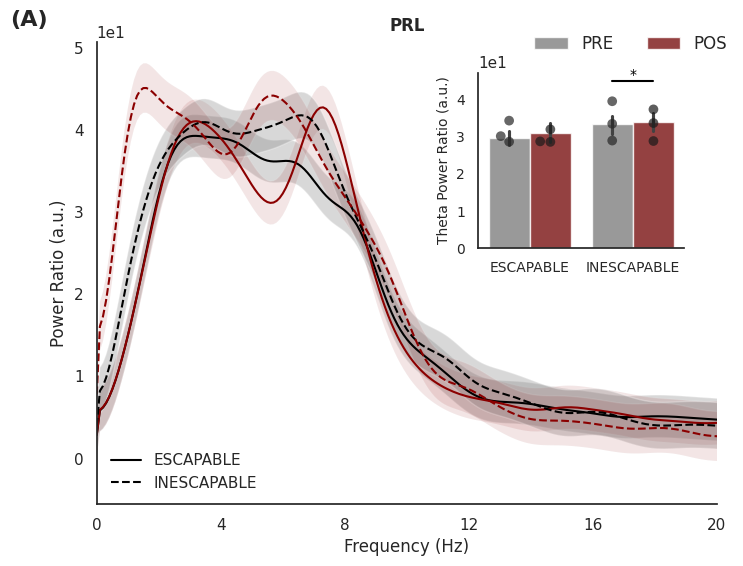

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import pandas as pd

# PRL

fig, ax_main = plt.subplots(figsize=(8, 6))
ax_main.text(-0.14, 1.07, "(A)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")

# Configure o subplot principal
x = df_welch_pre_escap['f']
y_prl = df_welch_pre_escap['mean_power_prl']
std = np.std(y_prl) / np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_prl = df_welch_pos_escap['mean_power_prl']
std_pos = np.std(y_pos_prl) / np.sqrt(3)

ax_main.plot(x, y_prl, linewidth=1.5, color='black', label='ESCAPABLE')
ax_main.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred') #, label='POS STRESS - ESCAPABLE'
ax_main.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1, edgecolor=None)

x_inesc = df_welch_pre_inescap['f']
y_prl_inesc = df_welch_pre_inescap['mean_power_prl']
std_inesc = np.std(y_prl_inesc) / np.sqrt(3)

x_pos_inesc = df_welch_pos_inescap['f']
y_pos_prl_inesc = df_welch_pos_inescap['mean_power_prl']
std_pos_inesc = np.std(y_pos_prl_inesc) / np.sqrt(3)

ax_main.plot(x_inesc, y_prl_inesc, linewidth=1.5, linestyle='--', color='black', label='INESCAPABLE')
ax_main.fill_between(x_inesc, y_prl_inesc - std_inesc, y_prl_inesc + std_inesc, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos_inesc, y_pos_prl_inesc, linewidth=1.5, linestyle='--', color='darkred') #, label='POS STRESS - INESCAPABLE'
ax_main.fill_between(x_pos_inesc, y_pos_prl_inesc - std_pos_inesc, y_pos_prl_inesc + std_pos_inesc, color='darkred', alpha=0.1, edgecolor=None)

ax_main.grid(False)
ax_main.legend(fontsize=11, loc='lower left', frameon=False)
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Power Ratio (a.u.)')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_main.set_title('PRL', fontweight='bold', pad=8, fontsize=12)
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)

# Inserir subplot no canto superior direito

axins = inset_axes(ax_main, width="35%", height="40%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 0.95, 0.95),  # x0, y0, largura, altura
                   bbox_transform=ax_main.transAxes)

sns.barplot(data=df_barplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",
            palette=['grey', 'darkred'], alpha=0.8, ax=axins)

# valor_maximo = df_barplot_theta_dHPC['PSD'].max()
axins.axhline(y=45 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
# axins.axhline(y=65 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.text(1,45.5, '*', color='black', fontsize=10, ha='center')
# axins.text(0,65.5, '***', color='black', fontsize=10, ha='center')


sns.swarmplot(data=df_swarmplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",
              color="k", size=7, dodge=True, alpha=0.7, ax=axins, legend = False)
leg = axins.legend(loc='upper left', bbox_to_anchor=(0.2, 1.3), fontsize='medium', title='', title_fontsize='medium', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Theta Power Ratio (a.u.)', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='small')
axins.tick_params(axis='y', labelsize='small')
axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_and_barplot_theta_PRL.jpeg')

plt.show()


In [ ]:
valor_maximo

92.71443253150557

<ipython-input-112-fb94d8d47595>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta_BLA['CONDICAO'] = pd.Categorical(df_barplot_theta_BLA['CONDICAO'], categories=["PRE", "POS"], ordered=True)
<ipython-input-112-fb94d8d47595>:75: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(data=df_swarmplot_theta_BLA, x="GRUPO", y="PSD", hue="CONDICAO",


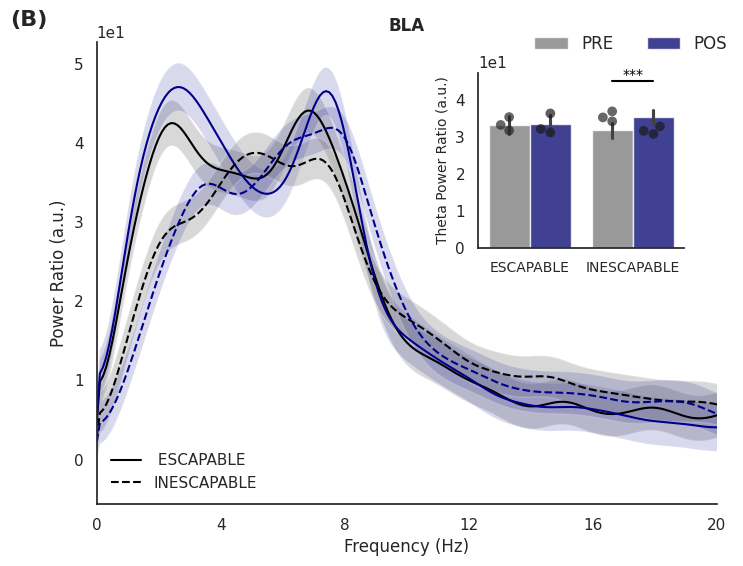

In [ ]:
# BLA



fig, ax_main = plt.subplots(figsize=(8, 6))
ax_main.text(-0.14, 1.07, "(B)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")

# Configure o subplot principal

x = df_welch_pre_escap['f']
y_bla = (df_welch_pre_escap ['mean_power_bla'] + 1e-10)
std_bla = np.std(y_bla)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_bla = (df_welch_pos_escap ['mean_power_bla'] )
std_pos_bla = np.std(y_pos_bla)/np.sqrt(3)


plt.plot(x, y_bla, linewidth=1.5, color='black', label= ' ESCAPABLE')
plt.fill_between(x, y_bla - std_bla, y_bla + std_bla, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_bla, linewidth=1.5, color='darkblue') #, label='POS STRESS - ESCAPABLE'
plt.fill_between(x_pos, y_pos_bla - std_pos_bla, y_pos_bla + std_pos_bla, color='darkblue', alpha=0.15, edgecolor=None)


x_inescap = df_welch_pre_inescap['f']
y_bla_inescap = (df_welch_pre_inescap ['mean_power_bla'] )
std_bla_inescap = np.std(y_bla_inescap)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos_inescap = df_welch_pos_inescap['f']
y_pos_bla_inescap = (df_welch_pos_inescap ['mean_power_bla'] )
std_pos_bla_inescap = np.std(y_pos_bla_inescap)/np.sqrt(3)

ax_main.plot(x_inescap, y_bla_inescap, linewidth=1.5, linestyle='--', color='black', label='INESCAPABLE')
ax_main.fill_between(x_inescap, y_bla_inescap - std_bla_inescap, y_bla_inescap + std_bla_inescap, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos_inescap, y_pos_bla_inescap, linewidth=1.5,linestyle='--', color='darkblue' ) #label='POS STRESS - INESCAPABLE'
ax_main.fill_between(x_pos_inescap, y_pos_bla_inescap - std_pos_bla_inescap, y_pos_bla_inescap + std_pos_bla_inescap, color='darkblue', alpha=0.15, edgecolor=None)

ax_main.grid(False)
ax_main.legend(fontsize=11, loc='lower left', frameon=False)
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Power Ratio (a.u.)')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_main.set_title('BLA', fontweight='bold', pad=8, fontsize=12)
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)

# Inserir subplot no canto superior direito

sns.set_theme(style="white")

df_barplot_theta_BLA = df_barplot_theta[df_barplot_theta['REGIAO'] == 'BLA']
df_barplot_theta_BLA['CONDICAO'] = pd.Categorical(df_barplot_theta_BLA['CONDICAO'], categories=["PRE", "POS"], ordered=True)


df_swarmplot_theta_BLA = psd_theta_por_animal[psd_theta_por_animal['REGIAO'] == 'BLA']


axins = inset_axes(ax_main, width="35%", height="40%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 0.95, 0.95),  # x0, y0, largura, altura
                   bbox_transform=ax_main.transAxes)

sns.barplot(data=df_barplot_theta_BLA, x="GRUPO", y="PSD", hue="CONDICAO",
            palette=['grey', 'darkblue'], alpha=0.8, ax=axins)

axins.axhline(y=45 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
# axins.axhline(y=65 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.text(1,45.5, '***', color='black', fontsize=10, ha='center')
# axins.text(0,65.5, '***', color='black', fontsize=10, ha='center')


sns.swarmplot(data=df_swarmplot_theta_BLA, x="GRUPO", y="PSD", hue="CONDICAO",
              color="k", size=7, dodge=True, alpha=0.7, ax=axins, legend = False)
# axins.legend(loc='upper left', bbox_to_anchor=(0.2, 1.3), fontsize='medium', title='', title_fontsize='medium', ncol=2)

leg = axins.legend(loc='upper left', bbox_to_anchor=(0.2, 1.3), fontsize='medium', title='', title_fontsize='medium', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Theta Power Ratio (a.u.)', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='small')
axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_and_barplot_theta_BLA.jpeg')



plt.show()

<ipython-input-111-ab32fed0522e>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta_vHPC['CONDICAO'] = pd.Categorical(df_barplot_theta_vHPC['CONDICAO'], categories=["PRE", "POS"], ordered=True)
<ipython-input-111-ab32fed0522e>:74: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(data=df_swarmplot_theta_vHPC, x="GRUPO", y="PSD", hue="CONDICAO",


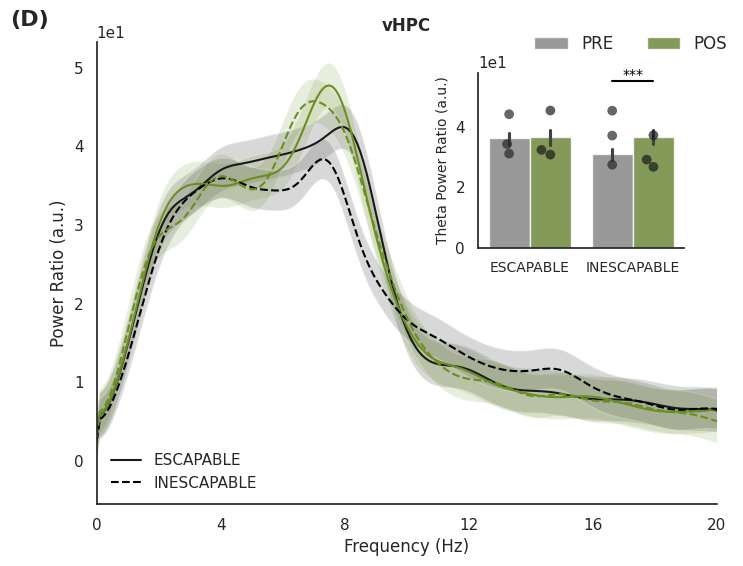

In [ ]:
# vHPC



fig, ax_main = plt.subplots(figsize=(8, 6))
ax_main.text(-0.14, 1.07, "(D)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")

# Configure o subplot principal
x = df_welch_pre_escap['f']
y_vhpc = (df_welch_pre_escap ['mean_power_vhpc'] )
std_vhpc = np.std(y_vhpc)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_vhpc = (df_welch_pos_escap ['mean_power_vhpc'] )
std_pos_vhpc = np.std(y_pos_vhpc)/np.sqrt(3)


plt.plot(x, y_vhpc, linewidth=1.5, color='k', label='ESCAPABLE')
plt.fill_between(x, y_vhpc - std_vhpc, y_vhpc + std_vhpc, color='gray', alpha=0.3, edgecolor=None)

plt.plot(x_pos, y_pos_vhpc, linewidth=1.5, color='olivedrab') #, label='POS STRESS - ESCAPABLE'
plt.fill_between(x_pos, y_pos_vhpc - std_pos_vhpc, y_pos_vhpc + std_pos_vhpc, color='olivedrab', alpha=0.15, edgecolor=None)


x_inescap = df_welch_pre_inescap['f']
y_vhpc_inescap = (df_welch_pre_inescap ['mean_power_vhpc'] )
std_vhpc_inescap = np.std(y_vhpc_inescap)/np.sqrt(3)  # Cálculo do desvio padrão

x_pos_inescap = df_welch_pos_inescap['f']
y_pos_vhpc_inescap = (df_welch_pos_inescap ['mean_power_vhpc'] )
std_pos_vhpc_inescap = np.std(y_pos_vhpc_inescap)/np.sqrt(3)


ax_main.plot(x_inescap, y_vhpc_inescap,linewidth=1.5, linestyle='--', color='black', label='INESCAPABLE')
ax_main.fill_between(x_inescap, y_vhpc_inescap - std_vhpc_inescap, y_vhpc_inescap + std_vhpc_inescap, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos_inescap, y_pos_vhpc_inescap, linewidth=1.5,linestyle='--', color='olivedrab' ) #label='POS STRESS - INESCAPABLE'
ax_main.fill_between(x_pos_inescap, y_pos_vhpc_inescap - std_pos_vhpc_inescap, y_pos_vhpc_inescap + std_pos_vhpc_inescap, color='olivedrab', alpha=0.15, edgecolor=None)

ax_main.grid(False)
ax_main.legend(fontsize=11, loc='lower left', frameon=False)
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Power Ratio (a.u.)')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_main.set_title('vHPC', fontweight='bold', pad=8, fontsize=12)
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)

# Inserir subplot no canto superior direito

sns.set_theme(style="white")

df_barplot_theta_vHPC = df_barplot_theta[(df_barplot_theta['REGIAO'] == 'vHPC')]
df_barplot_theta_vHPC['CONDICAO'] = pd.Categorical(df_barplot_theta_vHPC['CONDICAO'], categories=["PRE", "POS"], ordered=True)
df_swarmplot_theta_vHPC = psd_theta_por_animal[(psd_theta_por_animal['REGIAO'] == 'vHPC')]


axins = inset_axes(ax_main, width="35%", height="40%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 0.95, 0.95),  # x0, y0, largura, altura
                   bbox_transform=ax_main.transAxes)

sns.barplot(data=df_barplot_theta_vHPC, x="GRUPO", y="PSD", hue="CONDICAO",
            palette=['grey', 'olivedrab'], alpha=0.8, ax=axins)

axins.axhline(y=55 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
# axins.axhline(y=65 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.text(1,55.5, '***', color='black', fontsize=10, ha='center')
# axins.text(0,65.5, '***', color='black', fontsize=10, ha='center')



sns.swarmplot(data=df_swarmplot_theta_vHPC, x="GRUPO", y="PSD", hue="CONDICAO",
              color="k", size=7, dodge=True, alpha=0.7, ax=axins, legend = False)
# axins.legend(loc='upper left', bbox_to_anchor=(0.2, 1.3), fontsize='medium', title='', title_fontsize='medium', ncol=2)

leg = axins.legend(loc='upper left', bbox_to_anchor=(0.2, 1.3), fontsize='medium', title='', title_fontsize='medium', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Theta Power Ratio (a.u.)', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='small')
axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/psd_and_barplot_theta_VHPC.jpeg')



plt.show()

> # ESTATÍSTICA

In [ ]:
# #PRL
# # ESCAPAVEL x INESCAPAVEL PRE
# A = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'ESCAPABLE_PRE' )& (df_barplot_theta['REGIAO'] == 'PRL')]['PSD']
# B = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'INESCAPABLE_PRE' )& (df_barplot_theta['REGIAO'] == 'PRL')]['PSD']

# # ESCAPAVEL X INESCAPAVEL POS
# C = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'ESCAPABLE_POS' )& (df_barplot_theta['REGIAO'] == 'PRL')]['PSD']
# D = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'INESCAPABLE_POS' )& (df_barplot_theta['REGIAO'] == 'PRL')]['PSD']


RESULTADOS_PRL_1 = pd.DataFrame({'t_stat': '-1.7139815909776723', 'p_valor': '0.08963019342230083', 'teste': 'ESCAPxINESCAP', 'CONDICAO': 'POS' , 'REGIAO': 'PRL' }, index=[0]  )
RESULTADOS_PRL_2 = pd.DataFrame({'t_stat': '-2.2403334565049637', 'p_valor': ' 0.02728201270608721', 'teste': 'ESCAPxINESCAP', 'CONDICAO': 'PRE' , 'REGIAO': 'PRL' }, index=[0]  )
RESULTADOS_PRL_3 = pd.DataFrame({'t_stat': '-1.773912322244264', 'p_valor': ' 0.08216724764627521', 'teste': 'ESCAP', 'CONDICAO': 'PRExPOS' , 'REGIAO': 'PRL' }, index=[0]  )
RESULTADOS_PRL_4 = pd.DataFrame({'t_stat': '-2.3975173753388237', 'p_valor': ' 0.020283080692761593', 'teste': 'INESCAP', 'CONDICAO': 'PRExPOS' , 'REGIAO': 'PRL' }, index=[0]  )
RESULTADOS_PRL = pd.concat([RESULTADOS_PRL_1, RESULTADOS_PRL_2, RESULTADOS_PRL_3, RESULTADOS_PRL_4  ])

In [ ]:
# #BLA
# # ESCAPAVEL x INESCAPAVEL PRE
# A = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'ESCAPABLE_PRE' )& (df_barplot_theta['REGIAO'] == 'BLA')]['PSD']
# B = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'INESCAPABLE_PRE' )& (df_barplot_theta['REGIAO'] == 'BLA')]['PSD']

# # ESCAPAVEL X INESCAPAVEL POS
# C = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'ESCAPABLE_POS' )& (df_barplot_theta['REGIAO'] == 'BLA')]['PSD']
# D = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'INESCAPABLE_POS' )& (df_barplot_theta['REGIAO'] == 'BLA')]['PSD']


# RESULTADOS_BLA_1 = pd.DataFrame({'t_stat': '-1.1896005643516667', 'p_valor': '0.23702024006371747', 'teste': 'ESCAPxINESCAP', 'CONDICAO': 'POS' , 'REGIAO': 'BLA' }, index=[0]  )
# RESULTADOS_BLA_2 = pd.DataFrame({'t_stat': '0.8640809989770482', 'p_valor': ' 0.389611300757267', 'teste': 'ESCAPxINESCAP', 'CONDICAO': 'PRE' , 'REGIAO': 'BLA' }, index=[0]  )
# RESULTADOS_BLA_3 = pd.DataFrame({'t_stat': '-0.47914814673053496', 'p_valor': '0.6339222534930015 ', 'teste': 'ESCAP', 'CONDICAO': 'PRExPOS' , 'REGIAO': 'BLA' }, index=[0]  )
# RESULTADOS_BLA_4 = pd.DataFrame({'t_stat': '-7.426530160755167', 'p_valor': ' 1.2936087340696926e-09 ', 'teste': 'INESCAP', 'CONDICAO': 'PRExPOS' , 'REGIAO': 'BLA' }, index=[0]  )
# RESULTADOS_BLA = pd.concat([RESULTADOS_BLA_1, RESULTADOS_BLA_2, RESULTADOS_BLA_3, RESULTADOS_BLA_4  ])

In [ ]:
# #dHPC
# # ESCAPAVEL x INESCAPAVEL PRE
# A = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'ESCAPABLE_PRE' )& (df_barplot_theta['REGIAO'] == 'dHPC')]['PSD']
# B = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'INESCAPABLE_PRE' )& (df_barplot_theta['REGIAO'] == 'dHPC')]['PSD']

# # ESCAPAVEL X INESCAPAVEL POS
# C = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'ESCAPABLE_POS' )& (df_barplot_theta['REGIAO'] == 'dHPC')]['PSD']
# D = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'INESCAPABLE_POS' )& (df_barplot_theta['REGIAO'] == 'dHPC')]['PSD']



RESULTADOS_dHPC_1 = pd.DataFrame({'t_stat': '-0.5175071022418691', 'p_valor': ' 0.6059451120517858', 'teste': 'ESCAPxINESCAP', 'CONDICAO': 'POS' , 'REGIAO': 'dHPC' }, index=[0]  )
RESULTADOS_dHPC_2 = pd.DataFrame({'t_stat': '2.4507007818548145', 'p_valor': '0.015993927233689097 ', 'teste': 'ESCAPxINESCAP', 'CONDICAO': 'PRE' , 'REGIAO': 'dHPC' }, index=[0]  )
RESULTADOS_dHPC_3 = pd.DataFrame({'t_stat': '7.798215023711863', 'p_valor': '3.41603712395698e-10 ', 'teste': 'ESCAP', 'CONDICAO': 'PRExPOS' , 'REGIAO': 'dHPC' }, index=[0]  )
RESULTADOS_dHPC_4 = pd.DataFrame({'t_stat': '-4.8817750416490036', 'p_valor': '1.11665611368575e-05 ', 'teste': 'INESCAP', 'CONDICAO': 'PRExPOS' , 'REGIAO': 'dHPC' }, index=[0]  )
RESULTADOS_dHPC = pd.concat([RESULTADOS_dHPC_1, RESULTADOS_dHPC_2, RESULTADOS_dHPC_3, RESULTADOS_dHPC_4  ])

In [ ]:
#vHPC
# ESCAPAVEL x INESCAPAVEL PRE
A = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'ESCAPABLE_PRE' )& (df_barplot_theta['REGIAO'] == 'vHPC')]['PSD']
B = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'INESCAPABLE_PRE' )& (df_barplot_theta['REGIAO'] == 'vHPC')]['PSD']

# ESCAPAVEL X INESCAPAVEL POS
C = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'ESCAPABLE_POS' )& (df_barplot_theta['REGIAO'] == 'vHPC')]['PSD']
D = df_barplot_theta[(df_barplot_theta['Grupo_Condicao'] == 'INESCAPABLE_POS' )& (df_barplot_theta['REGIAO'] == 'vHPC')]['PSD']

RESULTADOS_vHPC_1 = pd.DataFrame({'t_stat': '-0.06324143760582397', 'p_valor': '0.9497004878984736', 'teste': 'ESCAPxINESCAP', 'CONDICAO': 'POS' , 'REGIAO': 'vHPC' }, index=[0]  )
RESULTADOS_vHPC_2 = pd.DataFrame({'t_stat': '3.7081950715961653', 'p_valor': '0.0003428703621170692 ', 'teste': 'ESCAPxINESCAP', 'CONDICAO': 'PRE' , 'REGIAO': 'vHPC' }, index=[0]  )
RESULTADOS_vHPC_3 = pd.DataFrame({'t_stat': '-0.8002027445377893', 'p_valor': '0.42737907124122154 ', 'teste': 'ESCAP', 'CONDICAO': 'PRExPOS' , 'REGIAO': 'vHPC' }, index=[0]  )
RESULTADOS_vHPC_4 = pd.DataFrame({'t_stat': '-13.104088091462087', 'p_valor': '8.563387267244044e-18 ', 'teste': 'INESCAP', 'CONDICAO': 'PRExPOS' , 'REGIAO': 'vHPC' }, index=[0]  )
RESULTADOS_vHPC = pd.concat([RESULTADOS_vHPC_1, RESULTADOS_vHPC_2, RESULTADOS_vHPC_3, RESULTADOS_vHPC_4  ])

In [ ]:
RESULTADOS_dHPC

,t_stat,p_valor,teste,CONDICAO,REGIAO
0,-0.5175071022418691,0.6059451120517858,ESCAPxINESCAP,POS,dHPC
0,2.4507007818548145,0.015993927233689097,ESCAPxINESCAP,PRE,dHPC
0,7.798215023711863,3.41603712395698e-10,ESCAP,PRExPOS,dHPC
0,-4.8817750416490036,1.11665611368575e-05,INESCAP,PRExPOS,dHPC


In [ ]:
RESULTADOS_vHPC

,t_stat,p_valor,teste,CONDICAO,REGIAO
0,-0.06324143760582397,0.9497004878984736,ESCAPxINESCAP,POS,vHPC
0,3.7081950715961653,0.0003428703621170692,ESCAPxINESCAP,PRE,vHPC
0,-0.8002027445377893,0.42737907124122154,ESCAP,PRExPOS,vHPC
0,-13.104088091462087,8.563387267244044e-18,INESCAP,PRExPOS,vHPC


In [ ]:
df_anova = df_barplot_theta
# df_anova['REGIAO'] = df_anova['REGIAO'].astype('category')
# df_anova['CONDICAO'] = df_anova['CONDICAO'].astype('category')
# df_anova['GRUPO'] = df_anova['GRUPO'].astype('category')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_anova

,PSD,CONDICAO,GRUPO,REGIAO
0,37.270300,PRE,ESCAPABLE,PRL
1,37.007070,PRE,ESCAPABLE,PRL
2,36.765270,PRE,ESCAPABLE,PRL
3,36.556229,PRE,ESCAPABLE,PRL
4,36.388692,PRE,ESCAPABLE,PRL
...,...,...,...,...
46,22.090266,POS,INESCAPABLE,vHPC
47,21.057569,POS,INESCAPABLE,vHPC
48,20.071658,POS,INESCAPABLE,vHPC
49,19.136214,POS,INESCAPABLE,vHPC


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd



# Ajustar o modelo ANOVA
modelo = ols('PSD ~ C(CONDICAO) + C(GRUPO) + C(REGIAO) +  C(REGIAO):C(GRUPO)', data=df_anova).fit()
resultado_anova = sm.stats.anova_lm(modelo, typ=2)

# Teste de Tukey HSD
tukey_condicao = pairwise_tukeyhsd(endog=df_anova['PSD'], groups=df_anova['CONDICAO'], alpha=0.05)
tukey_grupo = pairwise_tukeyhsd(endog=df_anova['PSD'], groups=df_anova['GRUPO'], alpha=0.05)
tukey_regiao = pairwise_tukeyhsd(endog=df_anova['PSD'], groups=df_anova['REGIAO'], alpha=0.05)

# Exibir resultados
print(resultado_anova)
print(tukey_condicao)
print(tukey_grupo)
print(tukey_regiao)


                           sum_sq     df          F        PR(>F)
C(CONDICAO)           1029.025566    1.0   6.287722  1.235307e-02
C(GRUPO)                81.813378    1.0   0.499910  4.797440e-01
C(REGIAO)            38144.429252    3.0  77.692130  3.719560e-44
C(REGIAO):C(GRUPO)    1410.654647    3.0   2.873205  3.544164e-02
Residual            132070.668071  807.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   POS    PRE  -2.2459 0.0275 -4.2419 -0.2499   True
----------------------------------------------------
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
ESCAPABLE INESCAPABLE  -0.6333 0.5347 -2.6348 1.3682  False
-----------------------------------------------------------
 Multiple Comparison of Means - Tukey H

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Modelo ANOVA de duas vias
modelo = ols('PSD ~ C(GRUPO) + C(CONDICAO) + C(GRUPO):C(CONDICAO)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)


                             sum_sq     df         F    PR(>F)
C(GRUPO)                  81.813378    1.0  0.389929  0.532512
C(CONDICAO)             1029.025566    1.0  4.904417  0.027065
C(GRUPO):C(CONDICAO)    1255.088808    1.0  5.981852  0.014665
Residual              170370.663162  812.0       NaN       NaN


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Convertendo colunas 'Categorical' para 'str' e concatenando
df_anova['Grupo_Condicao'] = df_anova['GRUPO'].astype(str) + "_" + df_anova['CONDICAO'].astype(str)
df_anova['Grupo_Condicao'] = df_anova['GRUPO'].astype(str) + "_" + df_anova['CONDICAO'].astype(str)
# Agora aplicando o teste Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_anova['PSD'], groups=df_anova['Grupo_Condicao'], alpha=0.05)
print(tukey)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
  ESCAPABLE_POS   ESCAPABLE_PRE   0.2345 0.9984 -3.4578  3.9267  False
  ESCAPABLE_POS INESCAPABLE_POS   1.8471 0.5709 -1.8451  5.5393  False
  ESCAPABLE_POS INESCAPABLE_PRE  -2.8792  0.186 -6.5714   0.813  False
  ESCAPABLE_PRE INESCAPABLE_POS   1.6127 0.6745 -2.0796  5.3049  False
  ESCAPABLE_PRE INESCAPABLE_PRE  -3.1137 0.1322 -6.8059  0.5785  False
INESCAPABLE_POS INESCAPABLE_PRE  -4.7263 0.0056 -8.4186 -1.0341   True
----------------------------------------------------------------------


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

for regiao in df_anova['REGIAO'].unique():
    # Filtrando o DataFrame para a região atual
    df_regiao = df_anova[df_anova['REGIAO'] == regiao]

    # Ajustando o modelo ANOVA
    modelo = ols('PSD ~ C(GRUPO) + C(CONDICAO) + C(GRUPO):C(CONDICAO)', data=df_regiao).fit()

    # Realizando a ANOVA
    anova_table = sm.stats.anova_lm(modelo, typ=2)

    # Imprimindo os resultados para a região atual
    print(f'ANOVA para a região: {regiao}')
    print(anova_table)


ANOVA para a região: PRL
                            sum_sq     df         F    PR(>F)
C(GRUPO)                532.696911    1.0  7.707811  0.006020
C(CONDICAO)              49.480252    1.0  0.715950  0.398487
C(GRUPO):C(CONDICAO)      4.134469    1.0  0.059823  0.807026
Residual              13822.262116  200.0       NaN       NaN
ANOVA para a região: BLA
                            sum_sq     df         F    PR(>F)
C(GRUPO)                  3.757967    1.0  0.051792  0.820206
C(CONDICAO)             195.235401    1.0  2.690743  0.102505
C(GRUPO):C(CONDICAO)    152.923759    1.0  2.107602  0.148136
Residual              14511.636736  200.0       NaN       NaN
ANOVA para a região: dHPC
                            sum_sq     df         F    PR(>F)
C(GRUPO)                635.880142    1.0  1.425234  0.233958
C(CONDICAO)             486.566185    1.0  1.090569  0.297606
C(GRUPO):C(CONDICAO)   1752.939212    1.0  3.928963  0.048831
Residual              89231.655817  200.0       NaN     

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> # ESPECTROGRAMA PRE

In [ ]:
srate = 1000
w = 12.
freq = np.linspace(1, int(srate/2), int(srate/2))
widths = w*srate / (2*freq*np.pi)

spec = np.abs(signal.cwt(data_dhpc, signal.morlet2, widths, w=w))


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
im = axs[0].imshow(spec, interpolation='gaussian', cmap='jet', vmin=0, vmax=5000, aspect='auto', alpha=1, label='Spectrogram')
axs[0].set_ylim([0, 20])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('T (s)')
axs[0].set_xticks([])
axs[0].set_title('PRL: Spectrogram OF pre screening', fontweight='bold')


cbar = fig.colorbar(im, ax=axs[0], aspect=15, pad=0.01, shrink=0.9, location='right')
cbar.set_label('Power (a.u.)')
cbar.set_ticks([0,500, 1000])

axs[0].hlines(y=75, xmin=80000, xmax=85000, color='white', linewidth = 2)
axs[0].text(82500, 70, '5s', ha='right', va='top', color='white', fontweight = 'bold', fontsize = 8)

In [ ]:
data_dhpc = df_full[(df_full['animal'] == 'CCM68') & (df_full['condicao'] == 'OF_pre')]['data_DHPC']

data_acel = df_acel[(df_acel['animal'] == 'CCM68') & (df_acel['condicao'] == 'OF_pre')]['acel']

acel = np.array(data_acel)
acel = np.diff(acel, axis = 0)
acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()



In [ ]:
frequencies, times, Sxx = spectrogram(data_dhpc, fs=1000, nperseg=1000, noverlap=int(0.9*1000), nfft = 10 * 1000 )
Sxx = Sxx/np.mean(Sxx)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nperseg = 1000
sampling_rate = 1000

acc = data_acel
win_size_s = nperseg / sampling_rate
time_array = np.arange(len(data_dhpc))/sampling_rate

win_acc = np.zeros(len(times))

for win_i in range(0, len(times)):
        win_edges_s = [times[win_i] - win_size_s / 2, times[win_i] + win_size_s / 2]
        tmask = (time_array >= win_edges_s[0]) & (time_array < win_edges_s[1])
        win_acc_ = np.mean(acc.values[tmask])
        win_acc[win_i] = win_acc_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 20.0)

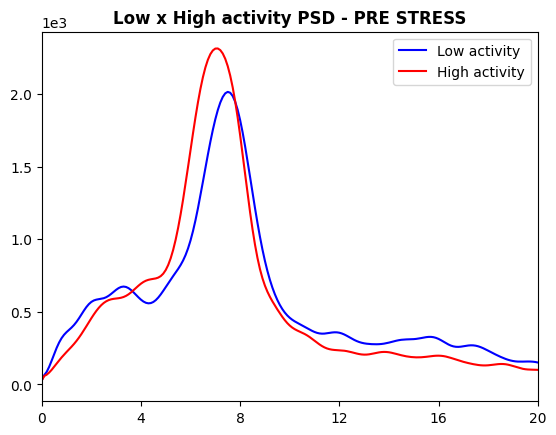

In [ ]:
thrs_high = np.percentile(win_acc, 75)
mask_acchigh = win_acc > thrs_high
Sxx_high = np.mean(Sxx[:, mask_acchigh], axis=1)

thrs_low = np.percentile(win_acc, 25)
mask_acclow = win_acc < thrs_low
Sxx_low = np.mean(Sxx[:, mask_acclow], axis=1)

plt.plot(frequencies, Sxx_low, color='b', label = 'Low activity')
plt.plot(frequencies, Sxx_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Low x High activity PSD - PRE STRESS', fontweight='bold')
plt.legend()
plt.xlim(0,20)

# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/LOW_VERSUS_HIGH_activity_PSD_CCM68_DHPC_PRE.jpeg')

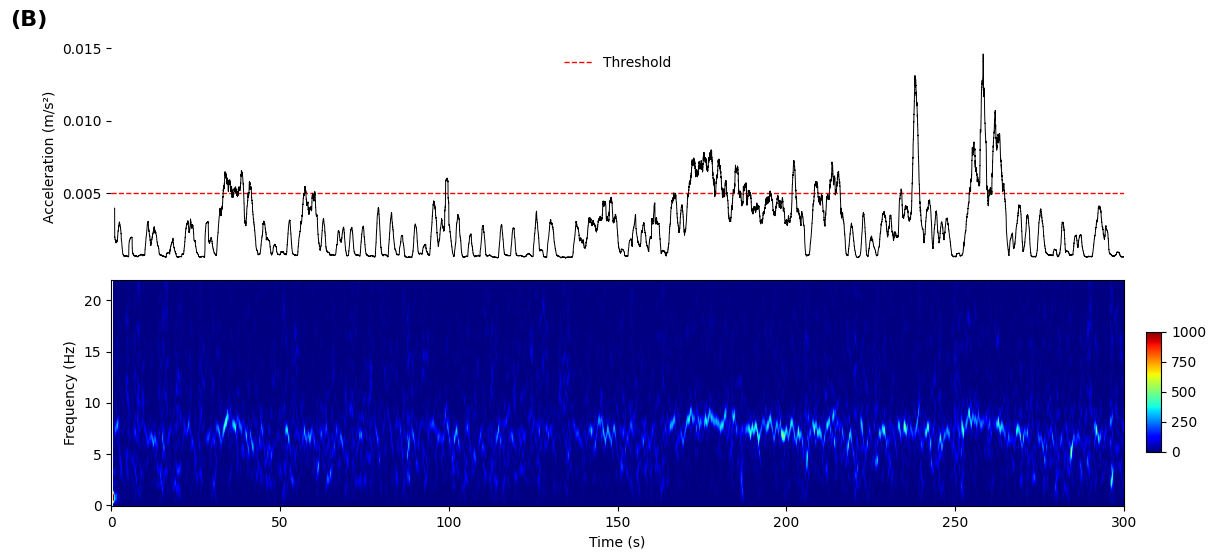

In [ ]:
fmax = 22
fmask = frequencies < fmax

figura = plt.figure(figsize=(15, 6))
figura.subplots_adjust(right=0.8)

# Primeiro subplot para aceleração
ax1 = figura.add_subplot(211)
ax1.text(-0.10, 1.15, "(B)", transform=ax1.transAxes, fontsize=16, fontweight="bold", va="top")

ax1.axhline(y=0.005, color='r', linestyle='--', linewidth=1, label='Threshold')
ax1.plot(acel, color='k', lw=0.7)
ax1.set_ylabel('Acceleration (m/s²)')
ax1.legend(frameon=False, loc='upper center')
ax1.set_xlim(0, 300000)
ax1.set_xticks([])
ax1.set_yticks([0.005, 0.01, 0.015])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Segundo subplot para espectrograma
ax2 = figura.add_subplot(212)
pcm = ax2.pcolormesh(times, frequencies[fmask], Sxx[fmask], cmap='jet'  , vmin=0, vmax=1000)
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlabel('Time (s)')
ax2.set_xlim(0, 300)

# Colorbar
cbar_ax = figura.add_axes([0.815, 0.2, 0.01, 0.2])  # Ajusta conforme necessário
figura.colorbar(pcm, cax=cbar_ax)

# cbar_ax.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)


plt.subplots_adjust(hspace=0.05)
# plt.show()
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/acceleration_versus_espec.jpeg')

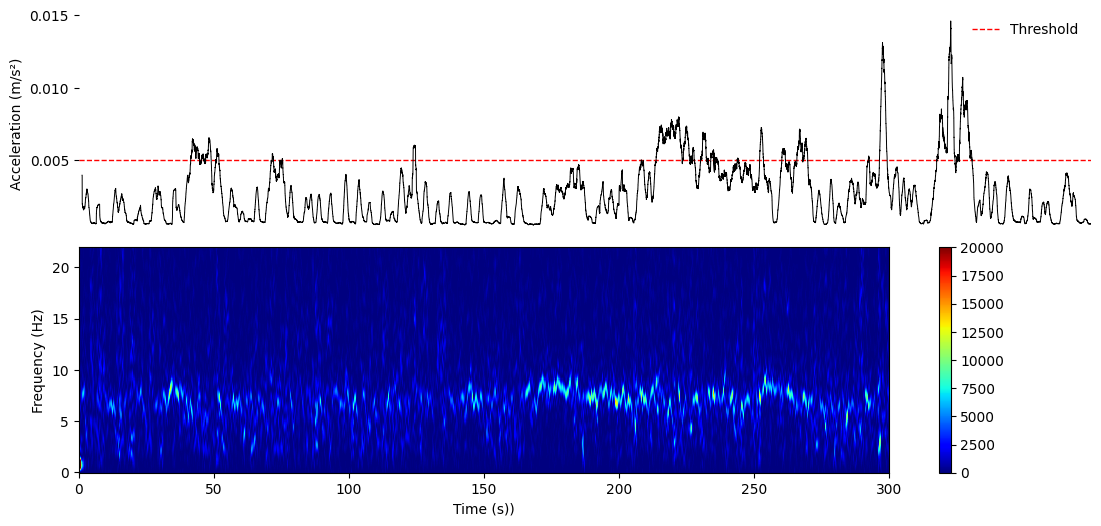

In [ ]:
fmax = 22
fmask = frequencies < fmax

ticks = np.arange(0, 20001, 5000)




figura = plt.figure(figsize = (15,6))
# plt.suptitle('Acceleration x Spectrogram - PRE STRESS', fontweight='bold')
figura.subplots_adjust(right=0.8)

figura.add_subplot(211)
# plt.subplot(2, 1, 1)

ax = plt.gca()
ax.axhline(y=0.005, color='r', linestyle='--', linewidth=1, label = 'Threshold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.plot(  acel, color = 'k',  lw=0.7)
plt.ylabel('Acceleration (m/s²)')
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(frameon = False)

plt.xlim(0,300000)
plt.xticks([])


ax.set_yticks([0.005,0.01, 0.015])


figura.add_subplot(212)


plt.pcolormesh(times, frequencies[fmask], Sxx[fmask], cmap='jet', vmin = 0, vmax = 20000)
plt.colorbar()

plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s))')
plt.xlim(0,300)
plt.subplots_adjust(hspace=0.05)
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/acceleration_versus_espec_CCM68_DHPC_PRE.jpeg')

> # ESPECTROGRAMA POS

In [ ]:
data_dhpc_pos = df_full[(df_full['animal'] == 'CCM68') & (df_full['condicao'] == 'OF_pos')]['data_DHPC']

data_acel_pos = df_acel[(df_acel['animal'] == 'CCM68') & (df_acel['condicao'] == 'OF_pos')]['acel']

acel_pos = np.array(data_acel)
acel_pos = np.diff(acel, axis = 0)
acel_pos = abs(pd.DataFrame(acel)).rolling(window=1000).mean()



In [ ]:
frequencies_pos, times_pos, Sxx_pos = spectrogram(data_dhpc_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000), nfft = 10 * 1000 )

In [ ]:
nperseg = 1000
sampling_rate = 1000

acc_pos = data_acel_pos
win_size_s = nperseg / sampling_rate
time_array_pos = np.arange(len(data_dhpc_pos))/sampling_rate

win_acc_pos = np.zeros(len(times_pos))

for win_i_pos in range(0, len(times_pos)):
        win_edges_s_pos = [times_pos[win_i_pos] - win_size_s / 2, times_pos[win_i_pos] + win_size_s / 2]
        tmask_pos = (time_array_pos >= win_edges_s_pos[0]) & (time_array_pos < win_edges_s_pos[1])
        win_acc__pos = np.mean(acc_pos.values[tmask_pos])
        win_acc_pos[win_i_pos] = win_acc__pos

In [ ]:
thrs_high_pos = np.percentile(win_acc_pos, 75)
mask_acchigh_pos = win_acc_pos > thrs_high_pos
Sxx_high_pos = np.mean(Sxx_pos[:, mask_acchigh_pos], axis=1)

thrs_low_pos = np.percentile(win_acc_pos, 25)
mask_acclow_pos = win_acc_pos < thrs_low_pos
Sxx_low_pos = np.mean(Sxx_pos[:, mask_acclow_pos], axis=1)

plt.plot(frequencies_pos, Sxx_low_pos, color='b', label = 'Low activity')
plt.plot(frequencies_pos, Sxx_high_pos, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Low x High activity PSD - POS STRESS', fontweight='bold')
plt.legend()
plt.xlim(0,20)

# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/LOW_VERSUS_HIGH_activity_PSD_CCM68_DHPC_POS.jpeg')

In [ ]:
fmax = 22
fmask = frequencies < fmax

ticks = np.arange(0, 20001, 5000)
plt.figure()
plt.suptitle('Acceleration x Spectrogram - POS STRESS', fontweight='bold')

plt.subplot(2, 1, 1)

ax = plt.gca()
# ax.axhline(y=0.04, color='gray', linestyle='--', linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.plot(  acel_pos, color = 'k',  lw=0.7)
plt.ylabel('Acceleration (m/s²)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


plt.xlim(0,250000)
plt.xticks([])


ax.set_yticks([0.005,0.01, 0.015])



plt.subplot(2, 1, 2)

plt.pcolormesh(times_pos, frequencies_pos[fmask], Sxx_pos[fmask], cmap='jet', vmin = 0, vmax = 20000)
plt.subplots_adjust(hspace=0.05)



plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s))')
plt.xlim(0,250)

# plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/acceleration_versus_espec_CCM68_DHPC_POS.jpeg')

> # TESTES

In [ ]:
path = '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO ESCAPAVEL/CCM68_OF_PRE_EXP'
load = Session(path).recordnodes[0].recordings[0]
t_raw= load.continuous[0].timestamps
t = t_raw-t_raw[0]

data_teste = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

In [ ]:
data_teste

In [ ]:
sampling_rate = 1000
nperseg = sampling_rate * 2
noverlap = nperseg // 2
psd_frqs, psd = signal.welch(data_teste, fs=sampling_rate, \
                             nperseg=nperseg, noverlap=noverlap, nfft=nperseg, axis=0)

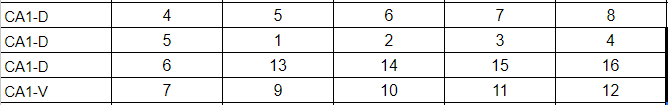

In [ ]:

lentaVector = np.arange(1,16,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

phase_prl = [] #d-1
phase_bla = [] #d-2
phase_dhpc = [] #d-3
phase_vhpc = [] #v-1

data_acel = df_acel[(df_acel['animal'] == 'CCM68' ) & (df_acel['condicao'] == 'OF_pre')]['acel']

data_prl = data_teste[5]
mask_prl_pre = generating_masks_parado(data_prl,data_acel,'PRL')
mask_prl_pre = mask_prl_pre['MASK'].values
phase_amp_hist_prl_pre = pac_histogram(data_prl,data_prl,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_prl_pre)
phase_prl.append(phase_amp_hist_prl_pre)

data_bla = data_teste[1]
mask_bla_pre = generating_masks_parado(data_bla,data_acel,'BLA')
mask_bla_pre = mask_bla_pre['MASK'].values
phase_amp_hist_bla_pre = pac_histogram(data_bla,data_bla,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_bla_pre)
phase_bla.append(phase_amp_hist_bla_pre)

data_dhpc = data_teste[13]
mask_dhpc_pre = generating_masks_parado(data_dhpc,data_acel,'dHPC')
mask_dhpc_pre = mask_dhpc_pre['MASK'].values
phase_amp_hist_dhpc_pre = pac_histogram(data_dhpc,data_dhpc,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_dhpc_pre)
phase_dhpc.append(phase_amp_hist_dhpc_pre)

data_vhpc = data_teste[9]
mask_vhpc_pre = generating_masks_parado(data_vhpc,data_acel,'vHPC')
mask_vhpc_pre = mask_vhpc_pre['MASK'].values
phase_amp_hist_vhpc_pre = pac_histogram(data_vhpc,data_vhpc,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_vhpc_pre)
phase_vhpc.append(phase_amp_hist_vhpc_pre)

In [ ]:
t = np.linspace(0,36,1000)
sine_wave = 2*np.sin(2*np.pi*t*0.055)+8

# extent = [0,720,altaVector[-1]+alta_BandWidth/2,altaVector[0]+alta_BandWidth/2]
extent = [0,720,30,150]

pac_plot = phase_amp_hist_vhpc_pre
vmin = 0.055
vmax = np.percentile(pac_plot, 97.5)


plt.imshow(np.hstack([pac_plot,pac_plot,pac_plot]),interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto')

plt.yticks(ticks = np.arange(0.5,12.5),labels = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.xticks(ticks = np.arange(16,52,3),labels = np.round(np.arange(0,720,60)).astype(int),rotation = 30)
plt.plot(np.linspace(16,52,1000),sine_wave,color = 'white',linewidth = 4)
plt.ylim([0,11])
plt.xlim([16,52])

plt.ylabel('Amp Frequency (Hz)')
plt.xlabel('Theta Phase (deg)')

plt.colorbar()


plt.tight_layout()

In [ ]:
plotfreq = [4, 20]
plotfreq_mask = (psd_frqs>plotfreq[0]) & (psd_frqs<plotfreq[1])
plt.pcolormesh(psd_frqs[plotfreq_mask], np.arange(35), psd[plotfreq_mask].T, cmap='jet')

In [ ]:
len(psd[0])

In [ ]:
plotfreq = [4, 20]
plotfreq_mask = (psd_frqs>plotfreq[0]) & (psd_frqs<plotfreq[1])
plt.pcolormesh(psd_frqs[plotfreq_mask], np.arange(35), psd[plotfreq_mask].T, cmap='jet')

In [ ]:
def bandpass(data, cutfreq, filtorder, sampling_rate):

        fny = sampling_rate/2

        b, a = signal.butter(N = filtorder, Wn=np.array(cutfreq) / fny,
                                         btype='bandpass')
        dataout = signal.filtfilt(b, a, data)

        return dataout

In [ ]:

# def phase_amp_hist(amp,fase_lenta,numbin):

#     position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
#     winsize = 2*np.pi/numbin # bin de fase

#     position = []
#     for j in np.arange(1,numbin+1):
#         position.append(-np.pi+(j-1)*winsize)


#     nbin=numbin
#     mean_amp = []
#     for j in np.arange(0,nbin):
#         boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
#         I = np.where(boolean_array)[0]
#         mean_amp.append(np.mean(amp[I]))

#     mean_amp = [x for x in mean_amp if str(x) != 'nan']
#     p = mean_amp/np.sum(mean_amp)

#     return(p)


# def pac_histogram(lfp,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

#     amplitude = []

#     AmpFreq= bandpass(np.array(lfp),[30,150],3,1000)

#     analytic_signal_alta = signal.hilbert(AmpFreq)
#     amplitude.append(np.abs(analytic_signal_alta)[mask])


#     PhaseFreq = bandpass(np.array(lfp),[4,18],3,1000)
#     analytic_signal_baixa = signal.hilbert(PhaseFreq)
#     faselenta = np.angle(analytic_signal_baixa)[mask]

#     hist_freqs = []

#     for count_rapida,rapida in enumerate(amplitude):

#         hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


#     return(hist_freqs)

In [ ]:
def phase_amp_hist(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)


    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    return(p)


def pac_histogram(lfp_amp,lfp_fase,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_amp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])

    Pf1 = 4
    Pf2 = 18
    PhaseFreq=eegfilt(lfp_fase,srate,Pf1,Pf2)
    analytic_signal = signal.hilbert(PhaseFreq)
    faselenta = np.angle(analytic_signal)[mask]

    hist_freqs = []

    for count_rapida,rapida in enumerate(AmpFreqTransformed1):

        hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


    return(hist_freqs)

In [ ]:

# Identificar os grupos de índices consecutivos não-NaN e seus comprimentos para cortar momentos de imobilidade menores que 2s
def find_consecutive_groups(arr):
    # Encontrar as mudanças de NaN para não-NaN e vice-versa
    diff = np.diff(np.isnan(arr).view(np.int8))
    idx, = diff.nonzero()

    # Adicionar o índice do primeiro e último elemento
    idx = np.r_[0, idx + 1, len(arr)]
    idx_pairs = zip(idx[:-1], idx[1:])  # Formar pares de índices

    return [(start, end) for start, end in idx_pairs if not np.isnan(arr[start])]

In [ ]:
def generating_masks_parado(DATA,data_acel,regiao): #ANIMAL PARADO



  # Recuperando dado da acelerometria para definir momentos de atividade

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )
  parado_bool = np.append(parado_bool, 0) #aqui foi adicionado um 0 pois a função diff retira um elemento do vetor, assim ele volta ao tamanho original


  index_parado_all = []
  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)


  vector_nan = np.full(len(DATA), np.nan)

  vector_nan[index_parado_all] = DATA[index_parado_all]


  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups = find_consecutive_groups(vector_nan)

  for start, end in groups:
      length = end - start
      if length < 2000:
            vector_nan[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask = np.where(~np.isnan(vector_nan))[0] #pegando apenas os indices dos valores que não são Nan


  return(pd.DataFrame({'MASK': mask, 'regiao': regiao}))

In [ ]:
lfp = df_full[(df_full['animal'] == 'CCM68') & (df_full['condicao'] == 'OF_pre')]['data_VHPC']
sampling_rate = 1000
theta_fcut = [4, 18]
theta = bandpass(lfp, theta_fcut, 3, 1000)

theta_maxf = 12
theta_peaks = signal.find_peaks(theta, height=0, distance=int(sampling_rate/theta_maxf))[0] #detectando picos para centralizar a janela
#a variavel distance dentro de theta_peaks garante que não vai pegar dois picos de theta muito próximos

In [ ]:
plt.plot(lfp, color='k', lw=2)
plt.plot(theta, color='r', lw=1)
plt.plot(theta_peaks, theta[theta_peaks], lw=0, color='r', marker='^', markersize=8)
plt.xlim(10000,11000)

In [ ]:
def do_ta(time_ref, signal_2trigger, ta_winlen): # função para achar o trigger avaerage (é a média de um sinal centralizado em um evento, nesse caso o evento é o pico de theta)

        time_ref = time_ref[time_ref > ta_winlen//2]
        time_ref = time_ref[time_ref < (len(signal_2trigger) - ta_winlen//2)]
        rel_samples = np.arange(ta_winlen) - ta_winlen//2 # essa variavel vai compor o eixo x

        ta_mat = np.zeros((len(time_ref),ta_winlen))
        for ta_win_i in range(0, len(time_ref)):
                win_samples = rel_samples + time_ref[ta_win_i]
                ta_mat[ta_win_i] = signal_2trigger[win_samples]

        ta = np.mean(ta_mat, axis=0)
        return ta, rel_samples #

ta_winlen = 400

gamma_fcut = [30, 150]
gamma = bandpass(lfp, gamma_fcut, 3, sampling_rate)
gamma_hilb = signal.hilbert(gamma) #usando trasf hilbert para fazer o envelope
gamma_env = np.abs(gamma_hilb)


ta_lfp, rel_samples  = do_ta(theta_peaks, lfp, ta_winlen)
ta_gammaenv, rel_samples_gamma = do_ta(theta_peaks, gamma_env, ta_winlen)


plt.figure(figsize=(5,3))
plt.subplot(2,1,1)
plt.plot(rel_samples, ta_lfp, color='k', lw=2)
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(rel_samples_gamma, ta_gammaenv, color='darkgreen', lw=2)

plt.grid(True)

In [ ]:
time_ref = theta_peaks

signal_2trigger = lfp
ta_winlen = 400

time_ref = time_ref[time_ref > ta_winlen//2]
time_ref = time_ref[time_ref < (len(signal_2trigger) - ta_winlen//2)]

ta_win_i = 3
time_ref[ta_win_i]

rel_samples = np.arange(ta_winlen) - ta_winlen//2
win_samples = rel_samples + time_ref[ta_win_i]

plt.plot(rel_samples,signal_2trigger[win_samples] )

plt.plot(rel_samples, theta[win_samples])
plt.grid(True)

In [ ]:
def wvfilt(lfp,mfreq,sr=1250., w=5, s=1, normwv=True):

        # computing the length of the wavelet for the desired frequency
        wavelen = int(np.round(2*w*s*sr/mfreq))

        # constructs morlet wavelet with given parameters
        wave = signal.morlet(wavelen,w=w,s=s,complete=True)

        # cutting borders
        cumulativeEnvelope = np.cumsum(np.abs(wave))/np.sum(np.abs(wave))
        Cut1 = next(i for (i,val) in enumerate(cumulativeEnvelope[::-1]) if val<=(1./2000))
        Cut2 = Cut1
        Cut1 = len(cumulativeEnvelope)-Cut1-1
        wave = wave[range(Cut1,Cut2)]

        # normalizes wavelet energy
        if normwv:
                wave = wave/(.5*sum(abs(wave)))

        if (len(wave))>len(lfp):
                print('ERROR: input signal needs at least '+str(len(wave))+\
                                                            ' time points for '+str(mfreq)+\
                                                                      'Hz-wavelet convolution')
                return None

        # convolving signal with wavelet
        fsignal = np.convolve(lfp,wave,'same')
        return fsignal


def wvSpect(lfp,freqs,sampling_rate):

        freqs = np.array(freqs).reshape(-1,1)
        tfr = np.zeros((np.size(freqs),len(lfp)),dtype=complex)
        for (fi,f) in enumerate(freqs):
                f = float(f)
                tfr[fi,:] = wvfilt(lfp,f,sampling_rate)

        output = np.abs(tfr).squeeze()

        return output


In [ ]:
frequencies, times, Sxx = spectrogram(data_dhpc, fs=1000, nperseg=1000, noverlap=int(0.9*1000), nfft = 10 * 1000 )

In [ ]:
lfp = df_full[(df_full['animal'] == 'CCM68') & (df_full['condicao'] == 'OF_pre')]['data_DHPC']

In [ ]:
freqs = np.arange(30, 90)

wvspect = wvSpect(lfp,freqs,sampling_rate)

ta_wvspect = do_ta(theta_peaks, wvspect, ta_winlen)



In [ ]:
plt.figure(figsize=(5,3))
plt.pcolormesh(rel_samples,freqs, ta_wvspect[0],cmap='jet')
plt.colorbar()
plt.grid(True)

In [ ]:

lentaVector = np.arange(1,12,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

phase_prl = []
phase_bla = []
phase_dhpc = []
phase_vhpc = []

for rato in ratos.keys():


  data_acel = df_acel[(df_acel['animal'] == str(rato) ) & (df_acel['condicao'] == 'OF_pre')]['acel']

  data_prl = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_PRL']
  mask_prl_pre = generating_masks_parado(data_prl,data_acel,'PRL')
  mask_prl_pre = mask_prl_pre['MASK'].values
  phase_amp_hist_prl_pre = pac_histogram(data_prl,data_prl,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_prl_pre)
  phase_prl.append(phase_amp_hist_prl_pre)

  data_bla = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_BLA']
  mask_bla_pre = generating_masks_parado(data_bla,data_acel,'BLA')
  mask_bla_pre = mask_bla_pre['MASK'].values
  phase_amp_hist_bla_pre = pac_histogram(data_bla,data_bla,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_bla_pre)
  phase_bla.append(phase_amp_hist_bla_pre)

  data_dhpc = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_DHPC']
  mask_dhpc_pre = generating_masks_parado(data_dhpc,data_acel,'dHPC')
  mask_dhpc_pre = mask_dhpc_pre['MASK'].values
  phase_amp_hist_dhpc_pre = pac_histogram(data_dhpc,data_dhpc,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_dhpc_pre)
  phase_dhpc.append(phase_amp_hist_dhpc_pre)

  data_vhpc = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_VHPC']
  mask_vhpc_pre = generating_masks_parado(data_vhpc,data_acel,'vHPC')
  mask_vhpc_pre = mask_vhpc_pre['MASK'].values
  phase_amp_hist_vhpc_pre = pac_histogram(data_vhpc,data_vhpc,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_vhpc_pre)
  phase_vhpc.append(phase_amp_hist_vhpc_pre)

In [ ]:
t = np.linspace(0,36,1000)
sine_wave = 2*np.sin(2*np.pi*t*0.055)+8

# extent = [0,720,altaVector[-1]+alta_BandWidth/2,altaVector[0]+alta_BandWidth/2]
extent = [0,720,30,150]

pac_plot = np.mean(phase_dhpc, axis = 0)
vmin = 0.055
vmax = np.percentile(pac_plot, 97.5)


plt.imshow(np.hstack([pac_plot,pac_plot,pac_plot]),interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto')

plt.yticks(ticks = np.arange(0.5,12.5),labels = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.xticks(ticks = np.arange(16,52,3),labels = np.round(np.arange(0,720,60)).astype(int),rotation = 30)
plt.plot(np.linspace(16,52,1000),sine_wave,color = 'white',linewidth = 4)
plt.ylim([0,11])
plt.xlim([16,52])

plt.ylabel('Amp Frequency (Hz)')
plt.xlabel('Theta Phase (deg)')

plt.colorbar()


plt.tight_layout()

In [ ]:

def activity_versus_imobility( rato, condicao,regiao  ):
  nperseg = 1000
  sampling_rate = 1000

  data = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == str(condicao))][str(regiao)]
  cutfreq = [4,18]

  data_filt = bandpass(data, cutfreq, 3, sampling_rate)

  frequencies, times, Sxx = spectrogram(data_filt, fs=1000, nperseg=1000, noverlap=int(0.9*1000), nfft = 10 * 1000 )

  data_acel = df_acel[(df_acel['animal'] == str(rato)) & (df_acel['condicao'] == str(condicao))]['acel']
  acc = data_acel
  win_size_s = nperseg / sampling_rate
  time_array = np.arange(len(data_filt))/sampling_rate

  win_acc = np.zeros(len(times))

  for win_i in range(0, len(times)):
          win_edges_s = [times[win_i] - win_size_s / 2, times[win_i] + win_size_s / 2]
          tmask = (time_array >= win_edges_s[0]) & (time_array < win_edges_s[1])
          win_acc_ = np.mean(acc.values[tmask])
          win_acc[win_i] = win_acc_

  thrs_high = np.percentile(win_acc, 75)
  mask_acchigh = win_acc > thrs_high
  Sxx_high = np.mean(Sxx[:, mask_acchigh], axis=1)

  thrs_low = np.percentile(win_acc, 25)
  mask_acclow = win_acc < thrs_low
  Sxx_low = np.mean(Sxx[:, mask_acclow], axis=1)

  return frequencies, Sxx_low, Sxx_high


In [ ]:
data1 = df_full[(df_full['animal'] == 'CCM68') & (df_full['condicao'] == 'OF_pre')]['data_DHPC']
data2 = df_full[(df_full['animal'] == 'CCM191') & (df_full['condicao'] == 'OF_pre')]['data_DHPC']

In [ ]:
len(data1)

In [ ]:
f, s_low, s_high = activity_versus_imobility( 'CCM191', 'OF_pre','data_DHPC'  )

In [ ]:
len(data2)

In [ ]:
sxx_low = []
sxx_high = []

for rato in ratos.keys():
  f, s_low, s_high = activity_versus_imobility( str(rato), 'OF_pos','data_DHPC'  )
  sxx_low.append(s_low)
  sxx_high.append(s_high)

  # plt.figure()
  # plt.plot(f, s_low, color='b', label = 'Low activity')
  # plt.plot(f, s_high, color='r', label = 'High activity')
  # plt.xlim(0,20)
  # plt.xticks(np.arange(0, 21, 4))

  # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
  # plt.title(str(rato), fontweight='bold')
  # plt.legend()
  # plt.xlim(0,20)

In [ ]:
sxx_low = []
sxx_high = []

for rato in ratos.keys():
  f, s_low, s_high = activity_versus_imobility( str(rato), 'OF_pos','data_DHPC'  )
  sxx_low.append(s_low)
  sxx_high.append(s_high)


s_low = np.mean(sxx_low, 0)
s_high = np.mean(sxx_high, 0)

plt.figure()
plt.plot(f, s_low, color='b', label = 'Low activity')
plt.plot(f, s_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.title(str(rato), fontweight='bold')
plt.legend()
plt.xlim(0,20)

In [ ]:
s_low = np.mean(sxx_low, 0)
s_high = np.mean(sxx_high, 0)

plt.figure()
plt.plot(f, s_low, color='b', label = 'Low activity')
plt.plot(f, s_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.title(str(rato), fontweight='bold')
plt.legend()
plt.xlim(0,20)

In [ ]:
F_ANIMALS_PRE = []
S_LOW_ANIMALS_PRE = []
S_HIGH_ANIMALS_PRE = []

for rato in ratos.keys():
  f, s_low, s_high = activity_versus_imobility( str(rato), 'OF_pre','data_DHPC'  )
  F_ANIMALS_PRE.append(f)
  S_LOW_ANIMALS_PRE.append(s_low)
  S_HIGH_ANIMALS_PRE.append(s_high)



In [ ]:
s_low = np.mean(S_LOW_ANIMALS_PRE, axis = 0)
s_high = np.mean(S_HIGH_ANIMALS_PRE, axis = 0)
f =  np.mean(F_ANIMALS_PRE, axis = 0)

In [ ]:

plt.plot(f, s_low, color='b', label = 'Low activity')
plt.plot(f, s_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Low x High activity PSD - PRE STRESS', fontweight='bold')
plt.legend()
plt.xlim(0,20)

In [ ]:

plt.plot(frequencies, Sxx_low, color='b', label = 'Low activity')
plt.plot(frequencies, Sxx_high, color='r', label = 'High activity')
plt.xlim(0,20)
plt.xticks(np.arange(0, 21, 4))

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Low x High activity PSD - PRE STRESS', fontweight='bold')
plt.legend()
plt.xlim(0,20)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



fig, ax_main = plt.subplots(figsize=(8, 6))

# Configure o subplot principal para o espectrograma
plt.pcolormesh(times, frequencies[fmask], Sxx[fmask], cmap='jet', vmin=0, vmax=20000)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, 300)

# Crie um subplot menor para o gráfico de aceleração dentro do subplot principal
axins = inset_axes(ax_main, width="30%", height="30%", loc='upper right')
axins.plot(acel, color='k')
axins.set_ylabel('Acceleration (m/s²)')
axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
axins.set_xlim(0, 300000)

# Remova os ticks do eixo x do subplot principal
ax_main.set_xticks([])

# Resto do seu código para personalizar e mostrar a figura
plt.show()


In [ ]:

fmax = 22
fmask = frequencies < fmax

plt.pcolormesh(times, frequencies[fmask], Sxx[fmask], cmap='jet')

plt.ylim(0,20)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import pandas as pd



fig, ax_main = plt.subplots(figsize=(8, 6))

# Configure o subplot principal
x = df_welch_pre_escap['f']
y_prl = df_welch_pre_escap['mean_power_prl']
std = np.std(y_prl) / np.sqrt(3)  # Cálculo do desvio padrão

x_pos = df_welch_pos_escap['f']
y_pos_prl = df_welch_pos_escap['mean_power_prl']
std_pos = np.std(y_pos_prl) / np.sqrt(3)

ax_main.plot(x, y_prl, linewidth=1.5, color='black', label='PRE STRESS - ESCAPABLE')
ax_main.fill_between(x, y_prl - std, y_prl + std, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos, y_pos_prl, linewidth=1.5, color='darkred', label='POS STRESS - ESCAPABLE')
ax_main.fill_between(x_pos, y_pos_prl - std_pos, y_pos_prl + std_pos, color='darkred', alpha=0.1, edgecolor=None)

x_inesc = df_welch_pre_inescap['f']
y_prl_inesc = df_welch_pre_inescap['mean_power_prl']
std_inesc = np.std(y_prl_inesc) / np.sqrt(3)

x_pos_inesc = df_welch_pos_inescap['f']
y_pos_prl_inesc = df_welch_pos_inescap['mean_power_prl']
std_pos_inesc = np.std(y_pos_prl_inesc) / np.sqrt(3)

ax_main.plot(x_inesc, y_prl_inesc, linewidth=1.5, linestyle='--', color='black', label='PRE STRESS - INESCAPABLE')
ax_main.fill_between(x_inesc, y_prl_inesc - std_inesc, y_prl_inesc + std_inesc, color='gray', alpha=0.3, edgecolor=None)

ax_main.plot(x_pos_inesc, y_pos_prl_inesc, linewidth=1.5, linestyle='--', color='darkred', label='POS STRESS - INESCAPABLE')
ax_main.fill_between(x_pos_inesc, y_pos_prl_inesc - std_pos_inesc, y_pos_prl_inesc + std_pos_inesc, color='darkred', alpha=0.1, edgecolor=None)

ax_main.grid(False)
ax_main.legend(fontsize=11, loc='lower left', frameon=False)
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Power Ratio (a.u.)')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_main.set_title('PRL', fontweight='bold', pad=8, fontsize=12)
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)

# Inserir subplot no canto superior direito

axins = inset_axes(ax_main, width="35%", height="40%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 0.95, 0.95),  # x0, y0, largura, altura
                   bbox_transform=ax_main.transAxes)

sns.barplot(data=df_barplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",
            palette=['grey', 'darkred'], alpha=0.8, ax=axins)
sns.swarmplot(data=df_swarmplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",
              color="k", size=7, dodge=True, alpha=0.7, ax=axins, legend = False)
axins.legend(loc='upper left', bbox_to_anchor=(0.2, 1.3), fontsize='small', title='', title_fontsize='medium', ncol=2)

axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Theta Power Ratio (a.u.)', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='small')
axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()

